In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset, DataLoader
import glob
import matplotlib.pyplot as plt
import os

# 3D CNN Model
class CNN3D(nn.Module):
    def __init__(self):
        super(CNN3D, self).__init__()
        
        self.conv0 = nn.Conv3d(in_channels=23, out_channels=64, kernel_size=1, stride=1, padding=0) # play around with output channels
        self.conv1 = nn.Conv3d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool3d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv3d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool3d(kernel_size=2, stride=2, padding=0)

        #self.dropout_conv = nn.Dropout3d(p=0.05)
        
        # After two pooling layers, spatial dimensions reduce from 40x40x40 -> 5x5x5
        self.fc1 = nn.Linear(128 * 3 * 3 * 3, 256)  # Try increasing over 256
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 2)  # Assuming 1 output for docking status/position

        #self.dropout_fc = nn.Dropout(p=0.15)
        
    def forward(self, x):
        # Forward pass through Conv layers
        x = self.pool(torch.relu(self.conv0(x)))  # Conv0 -> ReLU -> Pooling
        #x = self.dropout_conv(x)
        x = self.pool(torch.relu(self.conv1(x)))  # Conv1 -> ReLU -> Pooling
        x = self.pool2(torch.relu(self.conv2(x)))  # Conv2 -> ReLU -> Pooling

        # Flatten the input for fully connected layers
        x = x.view(-1, 128 * 3 * 3 * 3)
        
        # Forward pass through fully connected layers
        x = torch.relu(self.fc1(x)) #use tanh activation
        #x = self.dropout_fc(x)
        x = torch.relu(self.fc2(x))
        x = torch.nn.functional.softmax(self.fc3(x), dim=1)  # Final layer (output layer)
        #x = torch.clamp(x, min=1e-7, max=1 - 1e-7)  # Clamp outputs to avoid extreme values
        
        return x

In [2]:
class GridDataset(Dataset):
    def __init__(self, data_dict):
        self.data = list(data_dict.values())

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        grid = sample['grid_tensor']
        label = sample['label']
        return grid, label

In [3]:
# Training function
def train_model(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=3.0)

        total_grad_norm = 0
        for name, param in model.named_parameters():
            if param.grad is not None:
                total_grad_norm += param.grad.norm().item()
        optimizer.step()
        
        running_loss += loss.item()
    return (running_loss / len(dataloader)), total_grad_norm

# Validation function
def validate_model(model, dataloader, criterion, device):
    model.eval()  # Set model to evaluation mode
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():  # Disable gradient calculation
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            
            # Compute accuracy
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    
    validation_loss = running_loss / len(dataloader)
    accuracy = correct / total
    return validation_loss, accuracy

In [4]:
# Create a dictionary with file names as keys and label + tensor grid as values
positive_grids = glob.glob('../../../Data/SplitData/Cholesterol/cholesterol-grid-5A_exp4/PositiveWithoutSpies/*.npy')
validation_grids = glob.glob('../../../Data/SplitData/Cholesterol/cholesterol-grid-5A_exp4/Validation_Set/*.npy')
file_data = {} # format is filename as key, label and grid tensor are values

for file in positive_grids:
    # Load the numpy array and convert it to a PyTorch tensor
    grid = np.load(file)
    grid_tensor = torch.tensor(grid, dtype=torch.float32).permute(3, 0, 1, 2)  # Fix input format
    file_data[file] = {'label': 1, 'grid_tensor': grid_tensor}
positive_grids = file_data
print(len(positive_grids), "is length of positive")

file_data = {} # format is filename as key, label and grid tensor are values

positive_validation_count = 0
unlabeled_validation_count = 0

for file in validation_grids:
    # Load the numpy array and convert it to a PyTorch tensor
    grid = np.load(file)
    grid_tensor = torch.tensor(grid, dtype=torch.float32).permute(3, 0, 1, 2)  # Fix input format
    if any(f"-f{i}" in file for i in range(1, 6)):
        label = 0
        unlabeled_validation_count += 1
    else:
        label = 1
        positive_validation_count += 1

    file_data[file] = {'label': label, 'grid_tensor': grid_tensor}
print("In validation directory there are", positive_validation_count, "positives and", unlabeled_validation_count, "fragments")
validation_grids = file_data
print(len(validation_grids), "is length of validation grids")

1925 is length of positive
In validation directory there are 385 positives and 1385 fragments
1770 is length of validation grids


In [5]:
def plot_graphs(train_losses, validation_losses, validation_accuracies, learning_rates):
    # Plot Training Loss vs Validation Loss
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
    plt.plot(range(1, len(validation_losses) + 1), validation_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss vs Validation Loss')
    plt.legend()
    plt.grid()
    plt.show()

    # Plot Validation Accuracy
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(validation_accuracies) + 1), validation_accuracies, label='Validation Accuracy', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy over Epochs')
    plt.legend()
    plt.grid()
    plt.show()

    # Plot Learning Rate
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(learning_rates) + 1), learning_rates, label='Learning Rates', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy over Epochs')
    plt.legend()
    plt.grid()
    plt.show()

1925 is length of subset grid
Training on bin 1
Bin 1, Epoch 1/150, Train Loss: 0.6929, Validation Loss: 0.6863, Validation Accuracy: 0.7825, Grad Norm: 0.0286, LR: 0.000050
Bin 1, Epoch 11/150, Train Loss: 0.6143, Validation Loss: 0.5357, Validation Accuracy: 0.8559, Grad Norm: 1.3080, LR: 0.000050
Bin 1, Epoch 21/150, Train Loss: 0.4701, Validation Loss: 0.4747, Validation Accuracy: 0.8503, Grad Norm: 1.6986, LR: 0.000050
Bin 1, Epoch 31/150, Train Loss: 0.4538, Validation Loss: 0.4366, Validation Accuracy: 0.8808, Grad Norm: 1.4018, LR: 0.000050
Bin 1, Epoch 41/150, Train Loss: 0.4468, Validation Loss: 0.4270, Validation Accuracy: 0.8836, Grad Norm: 5.4589, LR: 0.000050
Bin 1, Epoch 51/150, Train Loss: 0.4431, Validation Loss: 0.4279, Validation Accuracy: 0.8836, Grad Norm: 1.2503, LR: 0.000050
Bin 1, Epoch 61/150, Train Loss: 0.4420, Validation Loss: 0.4362, Validation Accuracy: 0.8791, Grad Norm: 6.3730, LR: 0.000025
Bin 1, Epoch 71/150, Train Loss: 0.4388, Validation Loss: 0.4232

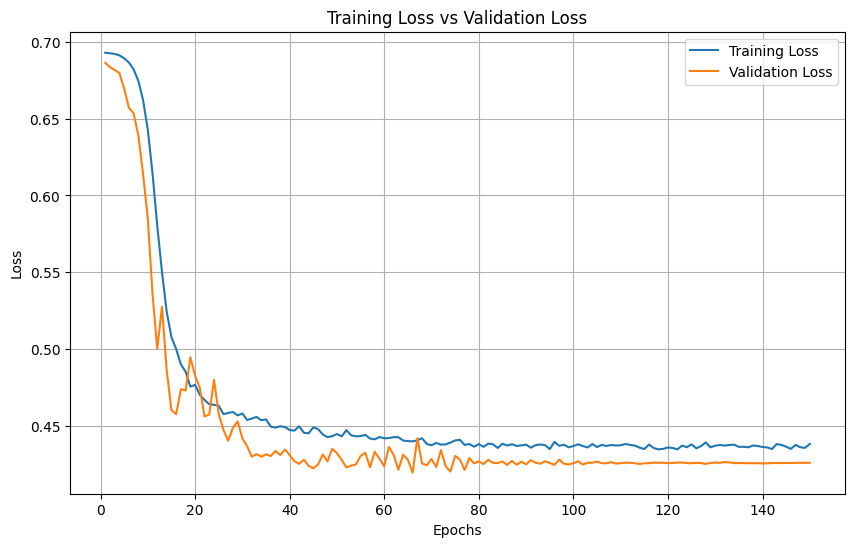

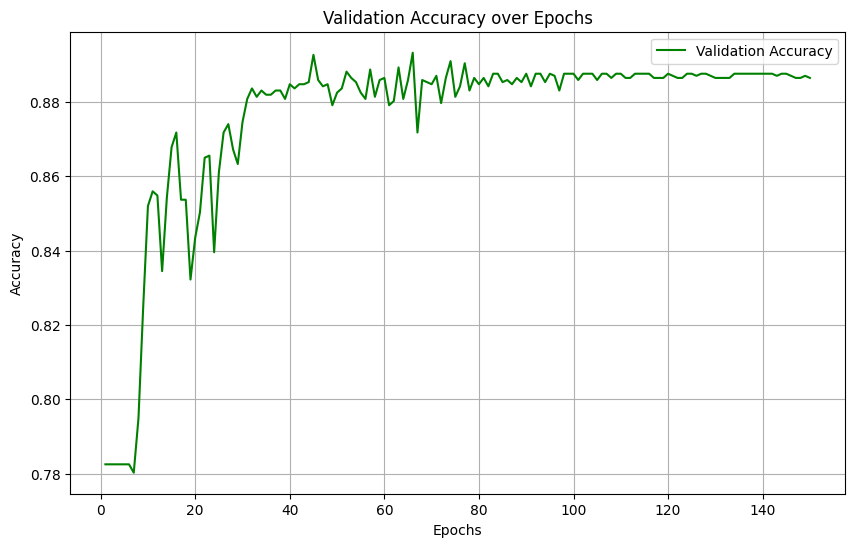

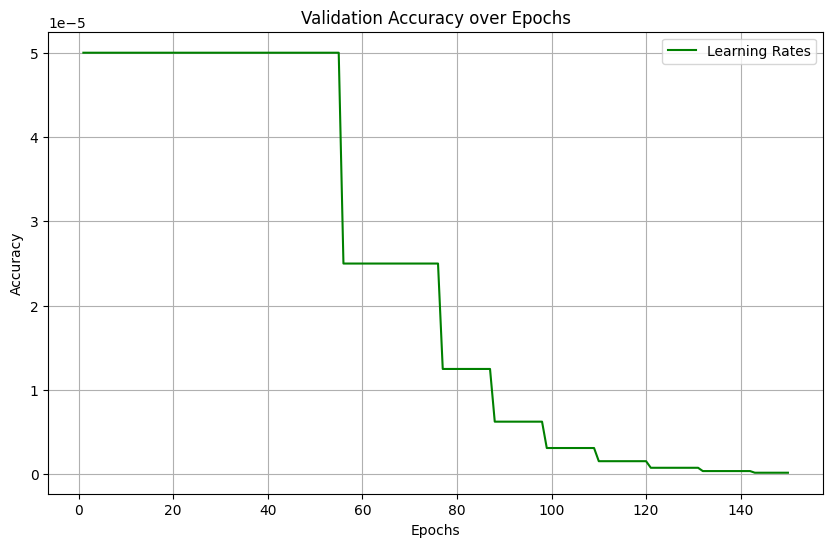

Model for bin 1 saved to 3DCholesterolModels-5A_exp4/model_bin_1.pth
1925 is length of subset grid
Training on bin 2
Bin 2, Epoch 1/150, Train Loss: 0.6931, Validation Loss: 0.6992, Validation Accuracy: 0.2175, Grad Norm: 0.0562, LR: 0.000050
Bin 2, Epoch 11/150, Train Loss: 0.6269, Validation Loss: 0.5762, Validation Accuracy: 0.8520, Grad Norm: 1.5037, LR: 0.000050
Bin 2, Epoch 21/150, Train Loss: 0.4780, Validation Loss: 0.4758, Validation Accuracy: 0.8401, Grad Norm: 6.3054, LR: 0.000050
Bin 2, Epoch 31/150, Train Loss: 0.4606, Validation Loss: 0.4503, Validation Accuracy: 0.8621, Grad Norm: 2.1581, LR: 0.000050
Bin 2, Epoch 41/150, Train Loss: 0.4559, Validation Loss: 0.4434, Validation Accuracy: 0.8672, Grad Norm: 0.4392, LR: 0.000050
Bin 2, Epoch 51/150, Train Loss: 0.4504, Validation Loss: 0.4328, Validation Accuracy: 0.8797, Grad Norm: 5.9117, LR: 0.000050
Bin 2, Epoch 61/150, Train Loss: 0.4478, Validation Loss: 0.4301, Validation Accuracy: 0.8836, Grad Norm: 6.3023, LR: 0.00

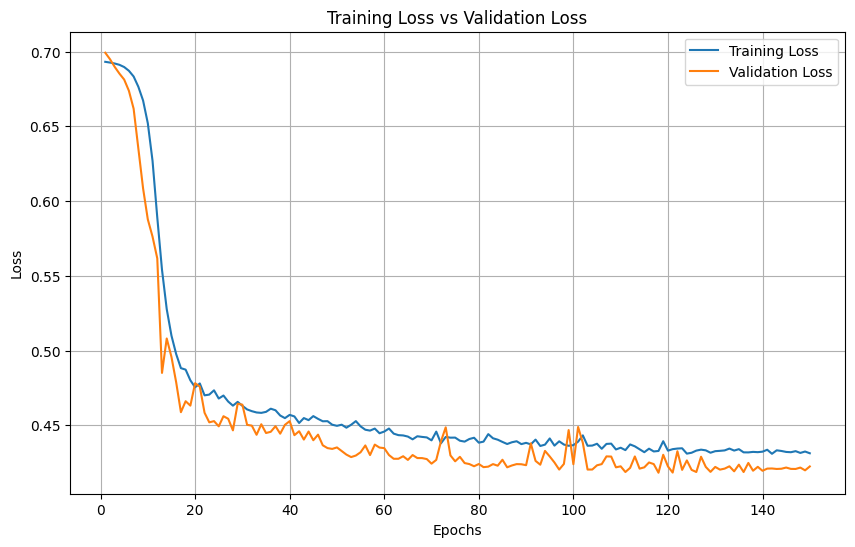

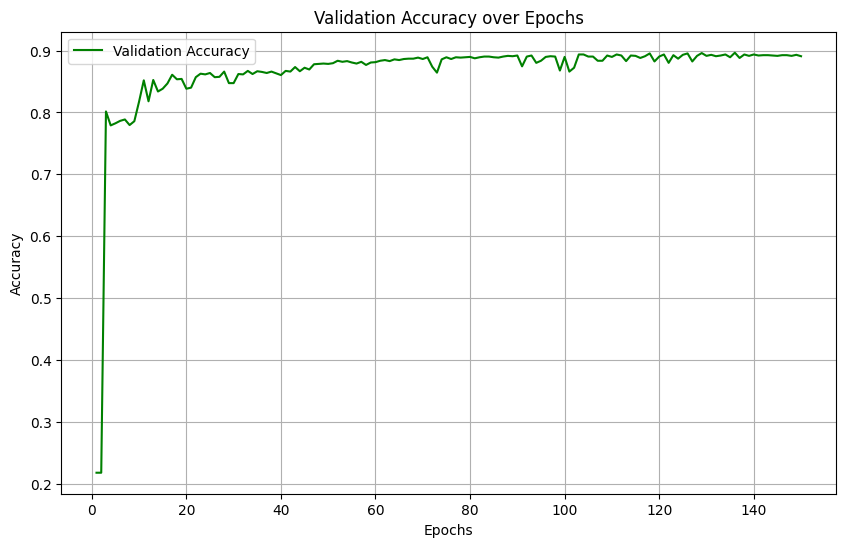

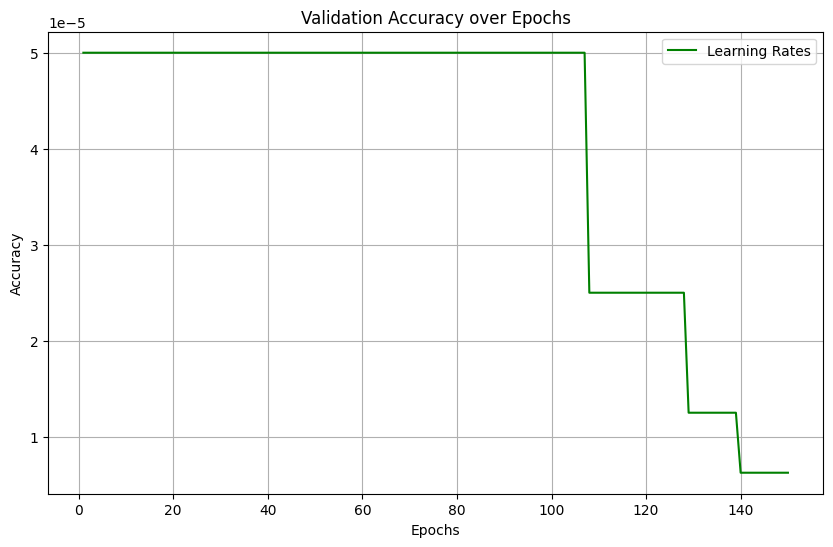

Model for bin 2 saved to 3DCholesterolModels-5A_exp4/model_bin_2.pth
1925 is length of subset grid
Training on bin 3
Bin 3, Epoch 1/150, Train Loss: 0.6931, Validation Loss: 0.6837, Validation Accuracy: 0.7825, Grad Norm: 0.0518, LR: 0.000050
Bin 3, Epoch 11/150, Train Loss: 0.5926, Validation Loss: 0.5124, Validation Accuracy: 0.8458, Grad Norm: 1.5124, LR: 0.000050
Bin 3, Epoch 21/150, Train Loss: 0.4742, Validation Loss: 0.4514, Validation Accuracy: 0.8667, Grad Norm: 6.2017, LR: 0.000050
Bin 3, Epoch 31/150, Train Loss: 0.4581, Validation Loss: 0.4363, Validation Accuracy: 0.8774, Grad Norm: 3.6262, LR: 0.000050
Bin 3, Epoch 41/150, Train Loss: 0.4495, Validation Loss: 0.4489, Validation Accuracy: 0.8638, Grad Norm: 3.6438, LR: 0.000050
Bin 3, Epoch 51/150, Train Loss: 0.4446, Validation Loss: 0.4393, Validation Accuracy: 0.8757, Grad Norm: 4.9903, LR: 0.000025
Bin 3, Epoch 61/150, Train Loss: 0.4416, Validation Loss: 0.4318, Validation Accuracy: 0.8814, Grad Norm: 1.8826, LR: 0.00

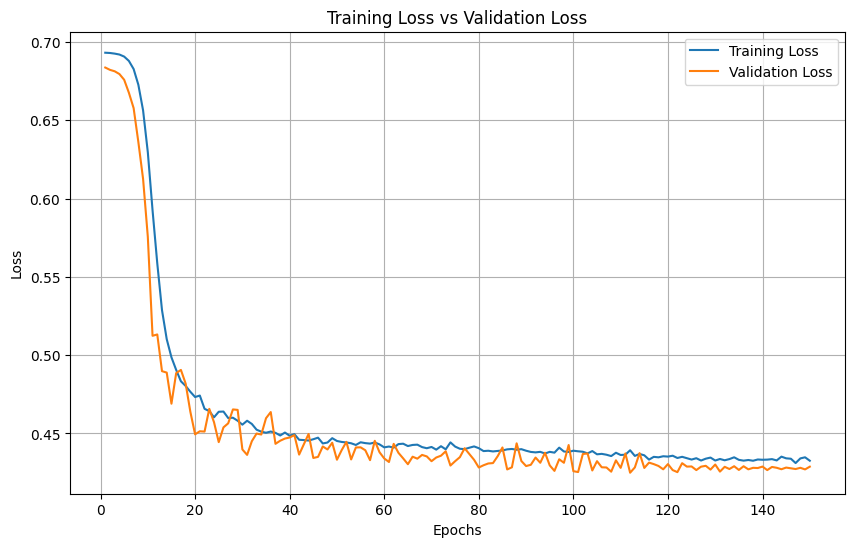

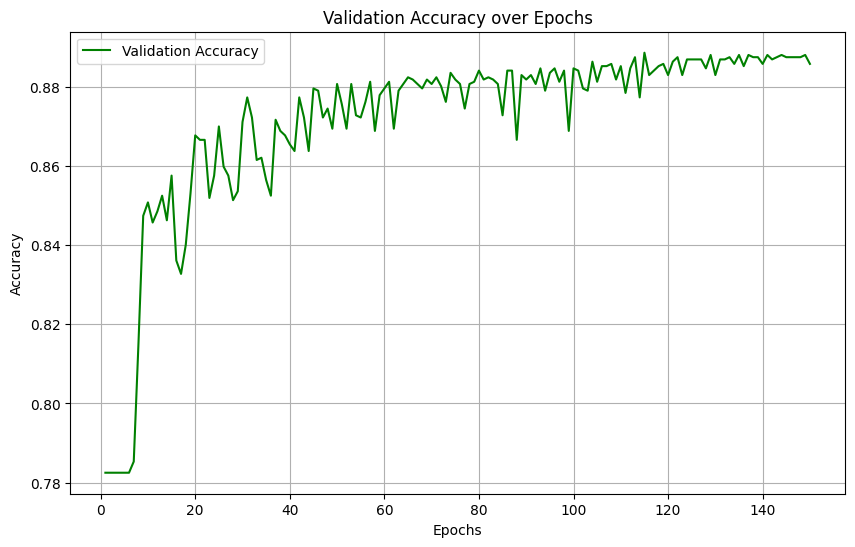

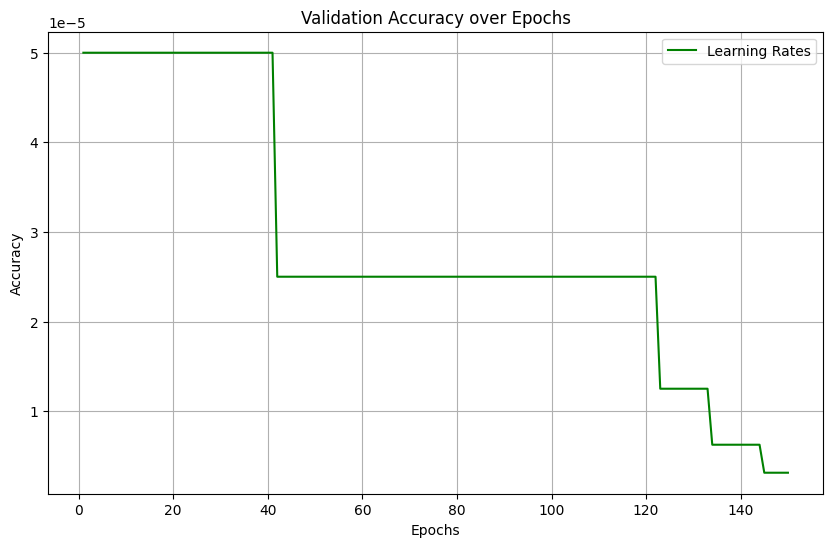

Model for bin 3 saved to 3DCholesterolModels-5A_exp4/model_bin_3.pth
1925 is length of subset grid
Training on bin 4
Bin 4, Epoch 1/150, Train Loss: 0.6935, Validation Loss: 0.7082, Validation Accuracy: 0.2175, Grad Norm: 0.0285, LR: 0.000050
Bin 4, Epoch 11/150, Train Loss: 0.6515, Validation Loss: 0.5965, Validation Accuracy: 0.8395, Grad Norm: 1.7445, LR: 0.000050
Bin 4, Epoch 21/150, Train Loss: 0.4819, Validation Loss: 0.4646, Validation Accuracy: 0.8610, Grad Norm: 6.1491, LR: 0.000050
Bin 4, Epoch 31/150, Train Loss: 0.4574, Validation Loss: 0.4419, Validation Accuracy: 0.8763, Grad Norm: 6.2642, LR: 0.000050
Bin 4, Epoch 41/150, Train Loss: 0.4502, Validation Loss: 0.4464, Validation Accuracy: 0.8723, Grad Norm: 3.0698, LR: 0.000050
Bin 4, Epoch 51/150, Train Loss: 0.4494, Validation Loss: 0.4547, Validation Accuracy: 0.8616, Grad Norm: 0.6738, LR: 0.000050
Bin 4, Epoch 61/150, Train Loss: 0.4426, Validation Loss: 0.4271, Validation Accuracy: 0.8859, Grad Norm: 0.3569, LR: 0.00

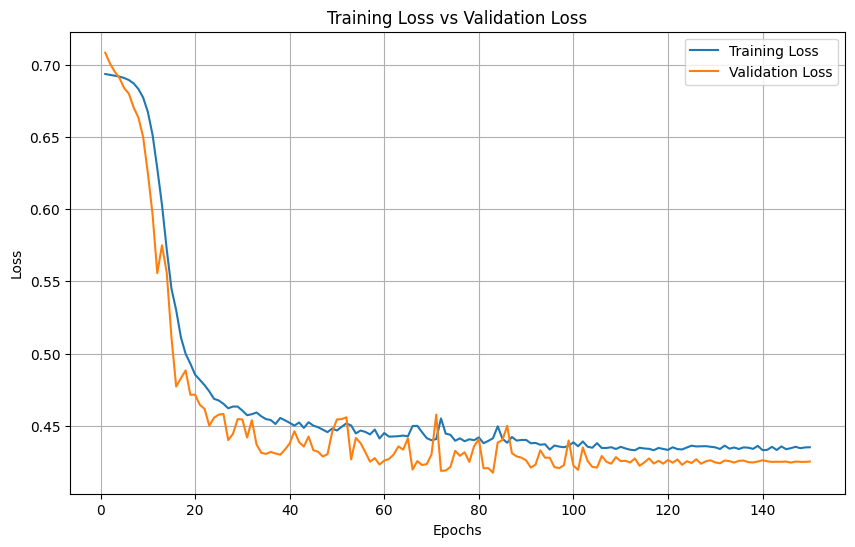

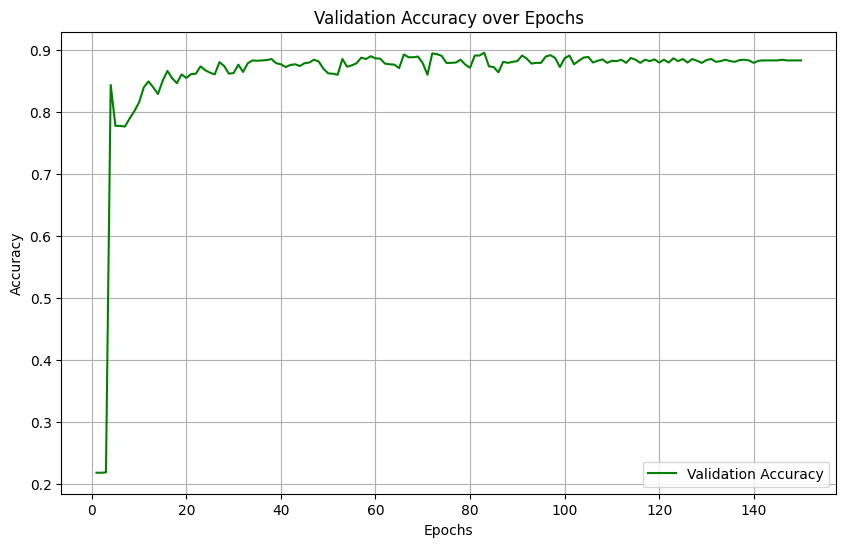

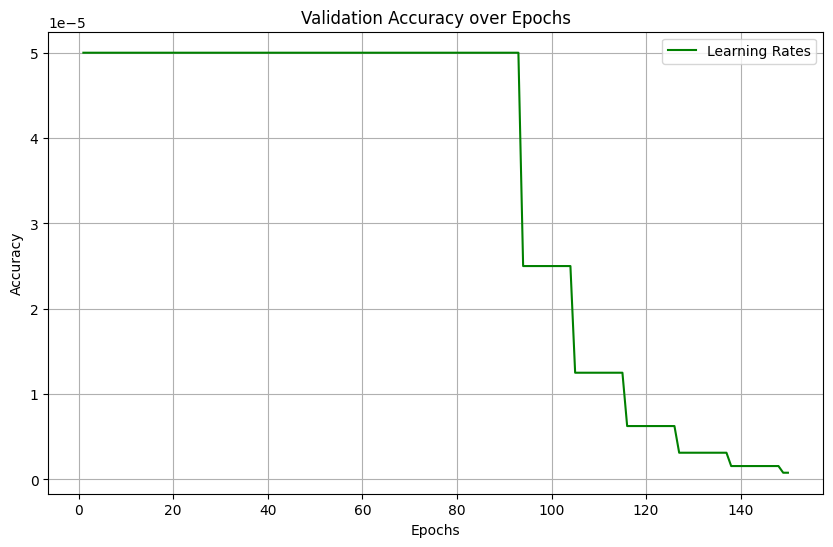

Model for bin 4 saved to 3DCholesterolModels-5A_exp4/model_bin_4.pth
1925 is length of subset grid
Training on bin 5
Bin 5, Epoch 1/150, Train Loss: 0.6934, Validation Loss: 0.6803, Validation Accuracy: 0.7825, Grad Norm: 0.0325, LR: 0.000050
Bin 5, Epoch 11/150, Train Loss: 0.5841, Validation Loss: 0.5608, Validation Accuracy: 0.8316, Grad Norm: 2.7707, LR: 0.000050
Bin 5, Epoch 21/150, Train Loss: 0.4642, Validation Loss: 0.4426, Validation Accuracy: 0.8768, Grad Norm: 0.3572, LR: 0.000050
Bin 5, Epoch 31/150, Train Loss: 0.4500, Validation Loss: 0.4426, Validation Accuracy: 0.8746, Grad Norm: 1.2058, LR: 0.000050
Bin 5, Epoch 41/150, Train Loss: 0.4465, Validation Loss: 0.4406, Validation Accuracy: 0.8746, Grad Norm: 5.7390, LR: 0.000050
Bin 5, Epoch 51/150, Train Loss: 0.4428, Validation Loss: 0.4212, Validation Accuracy: 0.8898, Grad Norm: 4.4560, LR: 0.000050
Bin 5, Epoch 61/150, Train Loss: 0.4363, Validation Loss: 0.4209, Validation Accuracy: 0.8910, Grad Norm: 3.3488, LR: 0.00

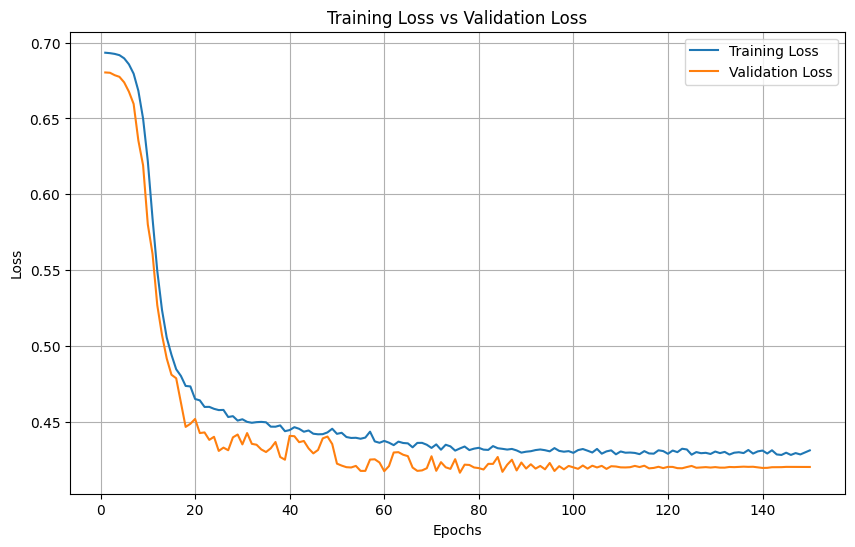

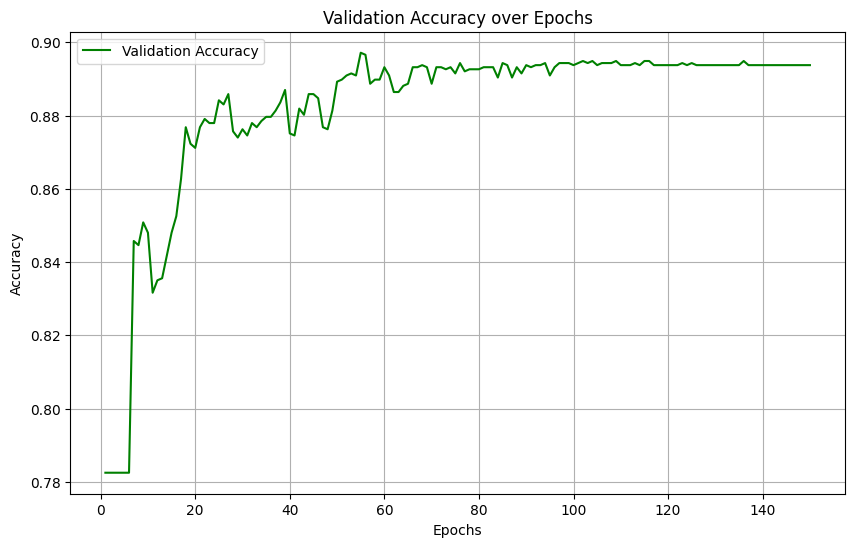

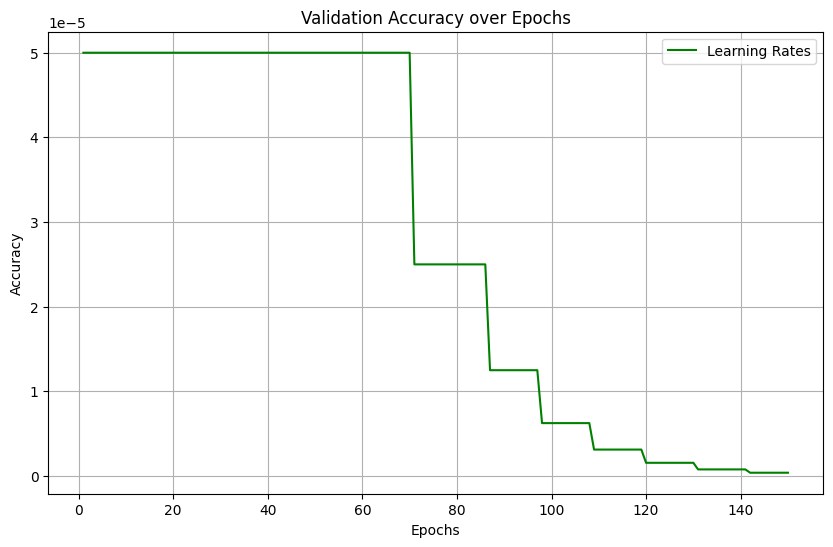

Model for bin 5 saved to 3DCholesterolModels-5A_exp4/model_bin_5.pth
1925 is length of subset grid
Training on bin 6
Bin 6, Epoch 1/150, Train Loss: 0.6931, Validation Loss: 0.6993, Validation Accuracy: 0.2175, Grad Norm: 0.0446, LR: 0.000050
Bin 6, Epoch 11/150, Train Loss: 0.6207, Validation Loss: 0.5405, Validation Accuracy: 0.8446, Grad Norm: 0.9900, LR: 0.000050
Bin 6, Epoch 21/150, Train Loss: 0.4657, Validation Loss: 0.4582, Validation Accuracy: 0.8576, Grad Norm: 3.3931, LR: 0.000050
Bin 6, Epoch 31/150, Train Loss: 0.4531, Validation Loss: 0.4486, Validation Accuracy: 0.8695, Grad Norm: 4.0808, LR: 0.000050
Bin 6, Epoch 41/150, Train Loss: 0.4454, Validation Loss: 0.4352, Validation Accuracy: 0.8768, Grad Norm: 3.1859, LR: 0.000050
Bin 6, Epoch 51/150, Train Loss: 0.4422, Validation Loss: 0.4298, Validation Accuracy: 0.8814, Grad Norm: 0.7065, LR: 0.000025
Bin 6, Epoch 61/150, Train Loss: 0.4431, Validation Loss: 0.4274, Validation Accuracy: 0.8859, Grad Norm: 1.2257, LR: 0.00

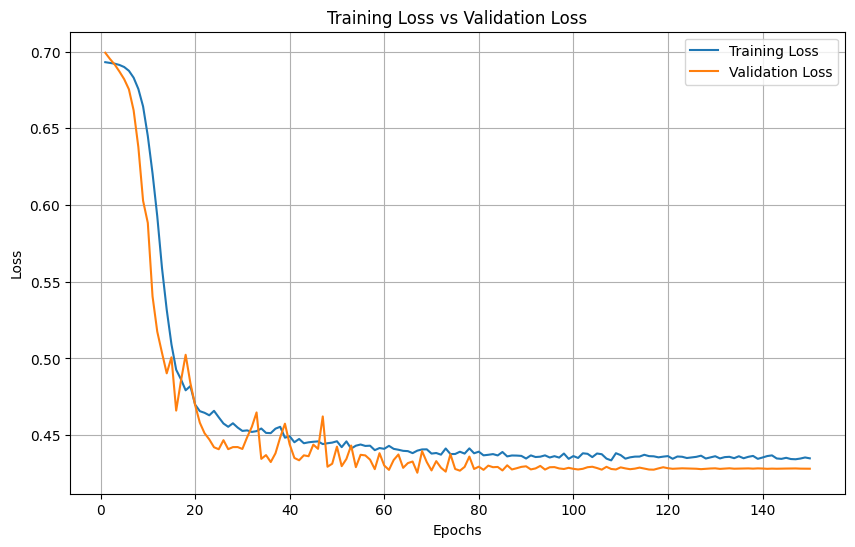

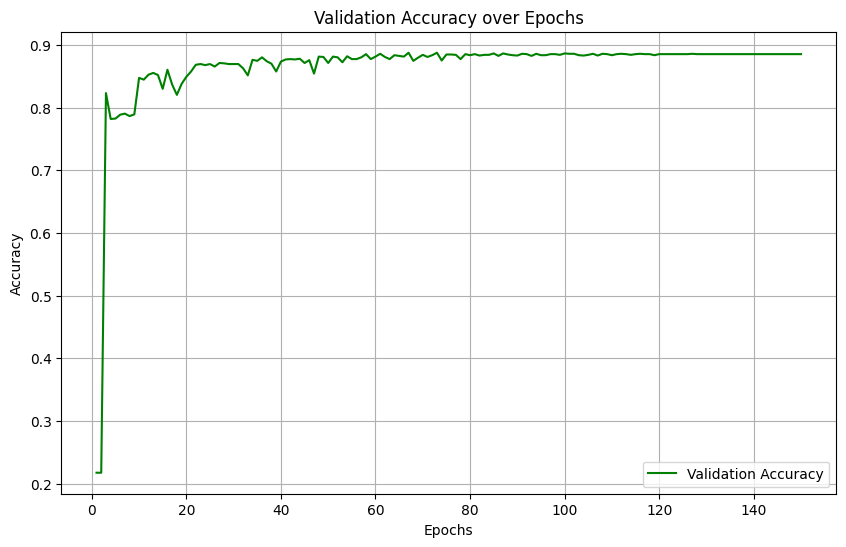

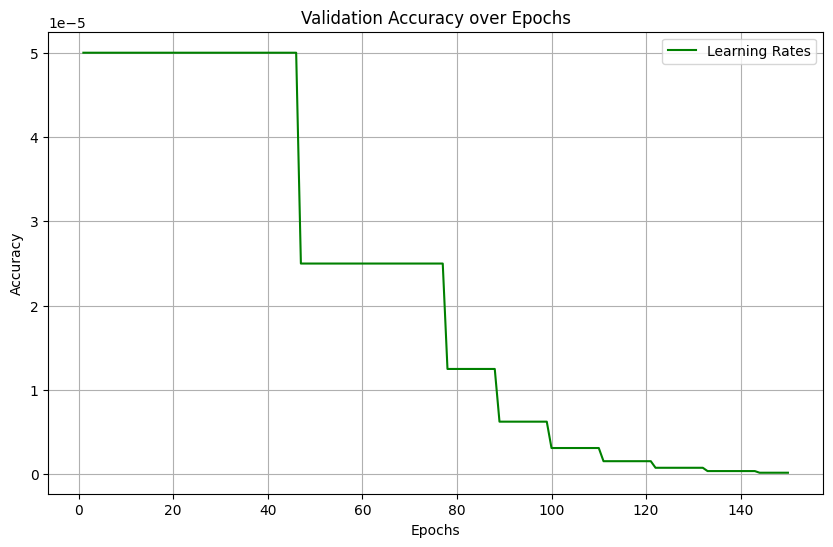

Model for bin 6 saved to 3DCholesterolModels-5A_exp4/model_bin_6.pth
1925 is length of subset grid
Training on bin 7
Bin 7, Epoch 1/150, Train Loss: 0.6936, Validation Loss: 0.6759, Validation Accuracy: 0.7825, Grad Norm: 0.0436, LR: 0.000050
Bin 7, Epoch 11/150, Train Loss: 0.6087, Validation Loss: 0.5580, Validation Accuracy: 0.8492, Grad Norm: 4.4623, LR: 0.000050
Bin 7, Epoch 21/150, Train Loss: 0.4780, Validation Loss: 0.4543, Validation Accuracy: 0.8667, Grad Norm: 2.2048, LR: 0.000050
Bin 7, Epoch 31/150, Train Loss: 0.4570, Validation Loss: 0.4483, Validation Accuracy: 0.8701, Grad Norm: 3.7455, LR: 0.000050
Bin 7, Epoch 41/150, Train Loss: 0.4517, Validation Loss: 0.4626, Validation Accuracy: 0.8554, Grad Norm: 4.0126, LR: 0.000050
Bin 7, Epoch 51/150, Train Loss: 0.4480, Validation Loss: 0.4243, Validation Accuracy: 0.8870, Grad Norm: 1.3260, LR: 0.000050
Bin 7, Epoch 61/150, Train Loss: 0.4436, Validation Loss: 0.4308, Validation Accuracy: 0.8842, Grad Norm: 1.0362, LR: 0.00

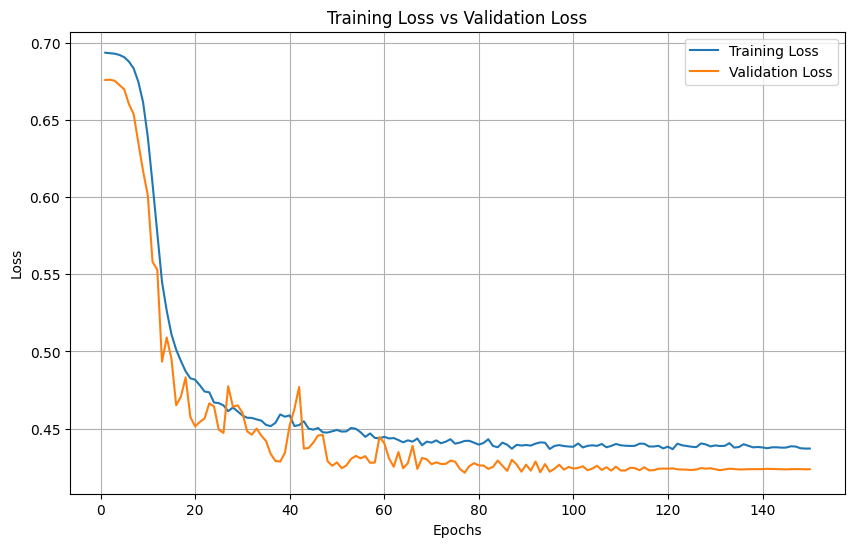

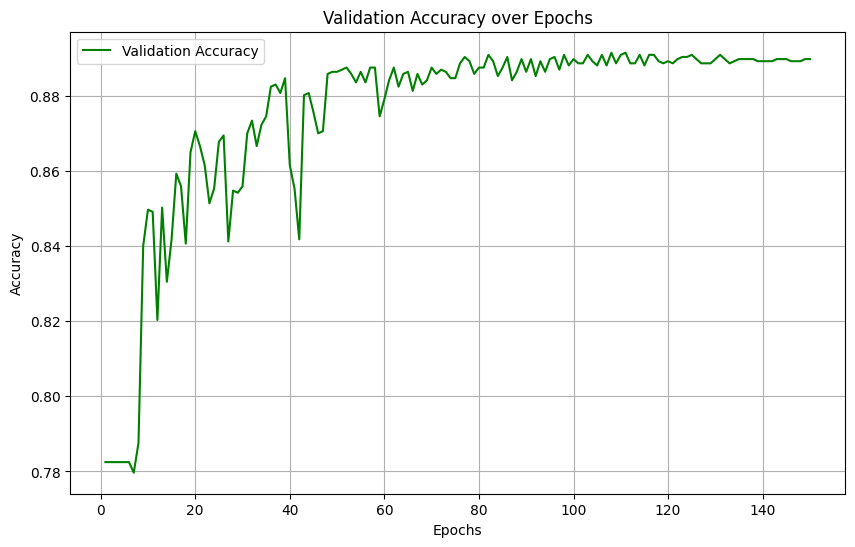

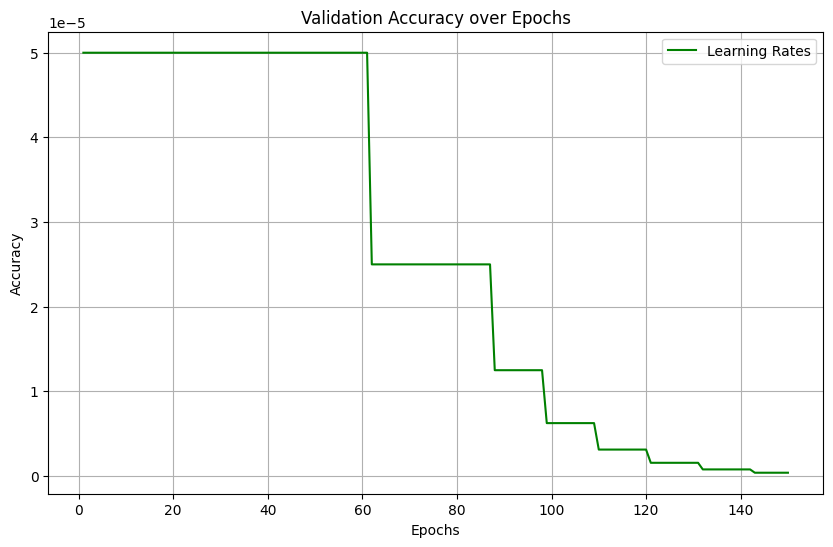

Model for bin 7 saved to 3DCholesterolModels-5A_exp4/model_bin_7.pth
1925 is length of subset grid
Training on bin 8
Bin 8, Epoch 1/150, Train Loss: 0.6930, Validation Loss: 0.6903, Validation Accuracy: 0.7825, Grad Norm: 0.0235, LR: 0.000050
Bin 8, Epoch 11/150, Train Loss: 0.5962, Validation Loss: 0.5388, Validation Accuracy: 0.8588, Grad Norm: 0.8909, LR: 0.000050
Bin 8, Epoch 21/150, Train Loss: 0.4626, Validation Loss: 0.4446, Validation Accuracy: 0.8768, Grad Norm: 2.8630, LR: 0.000050
Bin 8, Epoch 31/150, Train Loss: 0.4479, Validation Loss: 0.4329, Validation Accuracy: 0.8831, Grad Norm: 1.5502, LR: 0.000050
Bin 8, Epoch 41/150, Train Loss: 0.4444, Validation Loss: 0.4245, Validation Accuracy: 0.8853, Grad Norm: 4.1744, LR: 0.000025
Bin 8, Epoch 51/150, Train Loss: 0.4409, Validation Loss: 0.4251, Validation Accuracy: 0.8876, Grad Norm: 2.7421, LR: 0.000025
Bin 8, Epoch 61/150, Train Loss: 0.4371, Validation Loss: 0.4251, Validation Accuracy: 0.8887, Grad Norm: 2.2722, LR: 0.00

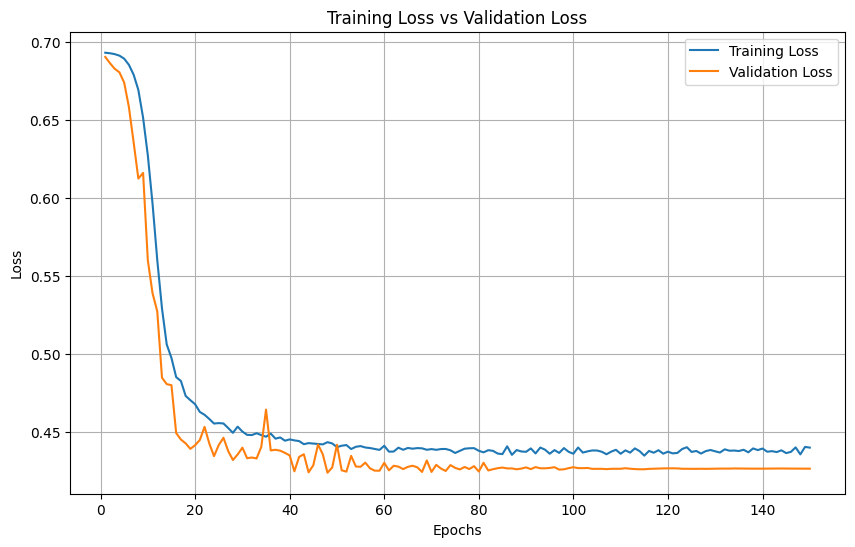

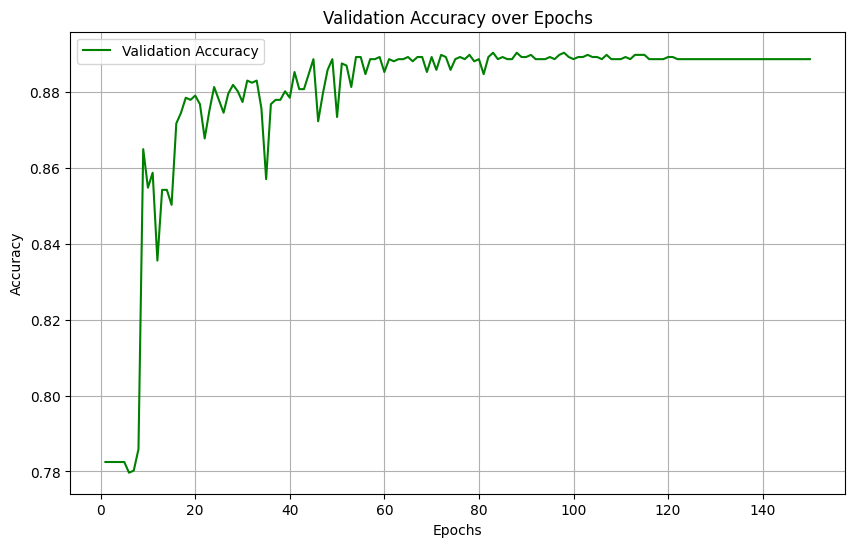

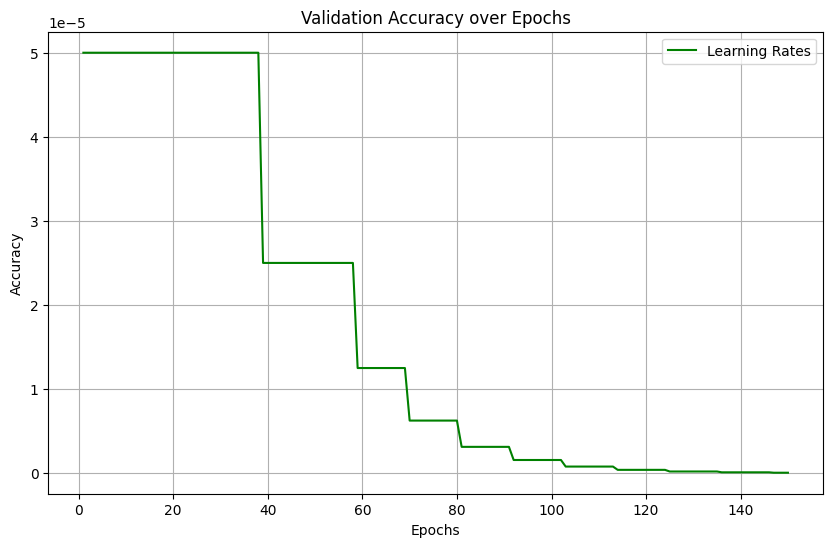

Model for bin 8 saved to 3DCholesterolModels-5A_exp4/model_bin_8.pth
1925 is length of subset grid
Training on bin 9
Bin 9, Epoch 1/150, Train Loss: 0.6930, Validation Loss: 0.6895, Validation Accuracy: 0.7825, Grad Norm: 0.0267, LR: 0.000050
Bin 9, Epoch 11/150, Train Loss: 0.6012, Validation Loss: 0.5397, Validation Accuracy: 0.8531, Grad Norm: 5.9289, LR: 0.000050
Bin 9, Epoch 21/150, Train Loss: 0.4808, Validation Loss: 0.4595, Validation Accuracy: 0.8588, Grad Norm: 4.2440, LR: 0.000050
Bin 9, Epoch 31/150, Train Loss: 0.4686, Validation Loss: 0.4411, Validation Accuracy: 0.8740, Grad Norm: 2.1541, LR: 0.000050
Bin 9, Epoch 41/150, Train Loss: 0.4621, Validation Loss: 0.4529, Validation Accuracy: 0.8655, Grad Norm: 4.7276, LR: 0.000050
Bin 9, Epoch 51/150, Train Loss: 0.4587, Validation Loss: 0.4288, Validation Accuracy: 0.8847, Grad Norm: 6.1078, LR: 0.000050
Bin 9, Epoch 61/150, Train Loss: 0.4503, Validation Loss: 0.4223, Validation Accuracy: 0.8921, Grad Norm: 6.1399, LR: 0.00

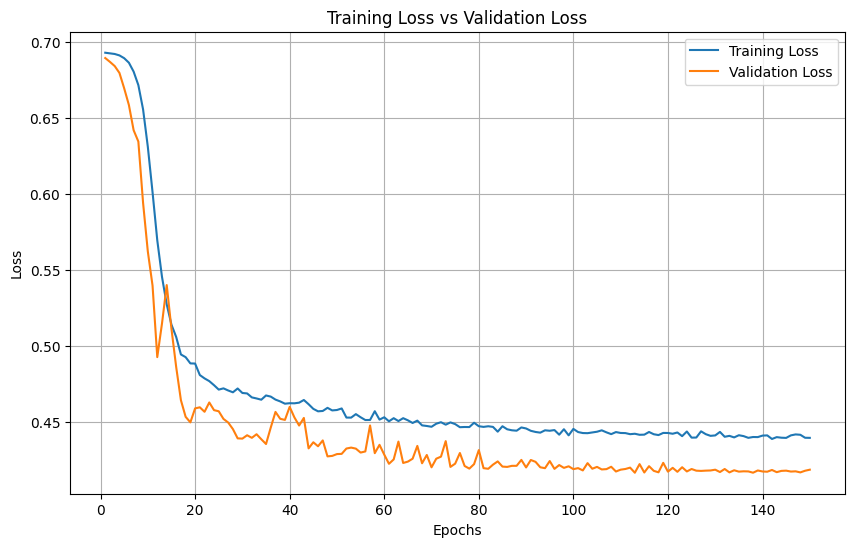

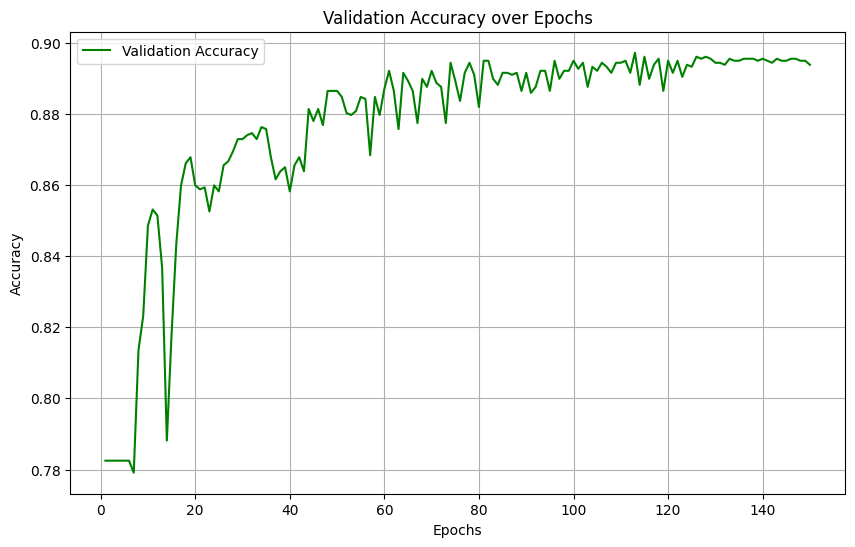

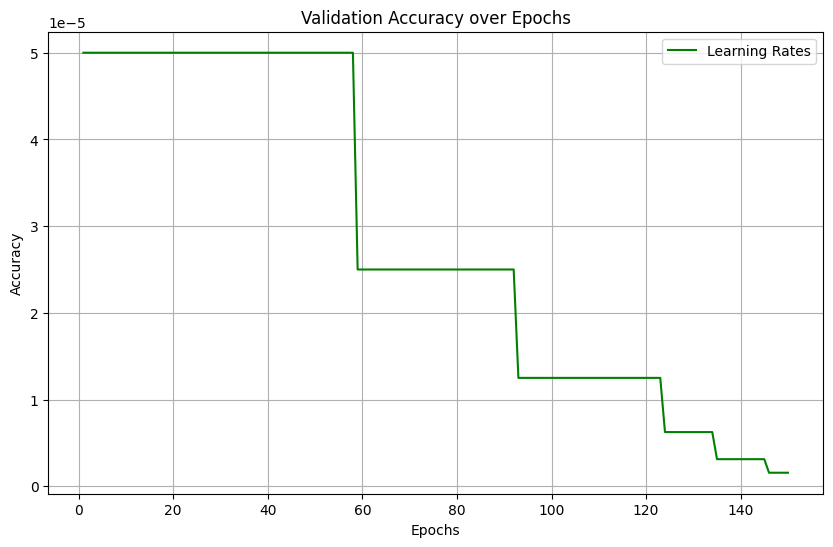

Model for bin 9 saved to 3DCholesterolModels-5A_exp4/model_bin_9.pth
1925 is length of subset grid
Training on bin 10
Bin 10, Epoch 1/150, Train Loss: 0.6932, Validation Loss: 0.6827, Validation Accuracy: 0.7825, Grad Norm: 0.0726, LR: 0.000050
Bin 10, Epoch 11/150, Train Loss: 0.6123, Validation Loss: 0.5728, Validation Accuracy: 0.8531, Grad Norm: 2.7912, LR: 0.000050
Bin 10, Epoch 21/150, Train Loss: 0.4695, Validation Loss: 0.4665, Validation Accuracy: 0.8559, Grad Norm: 0.5252, LR: 0.000050
Bin 10, Epoch 31/150, Train Loss: 0.4553, Validation Loss: 0.4367, Validation Accuracy: 0.8768, Grad Norm: 1.3056, LR: 0.000050
Bin 10, Epoch 41/150, Train Loss: 0.4489, Validation Loss: 0.4445, Validation Accuracy: 0.8712, Grad Norm: 2.2424, LR: 0.000050
Bin 10, Epoch 51/150, Train Loss: 0.4467, Validation Loss: 0.4330, Validation Accuracy: 0.8825, Grad Norm: 2.7528, LR: 0.000050
Bin 10, Epoch 61/150, Train Loss: 0.4395, Validation Loss: 0.4207, Validation Accuracy: 0.8910, Grad Norm: 1.0957, 

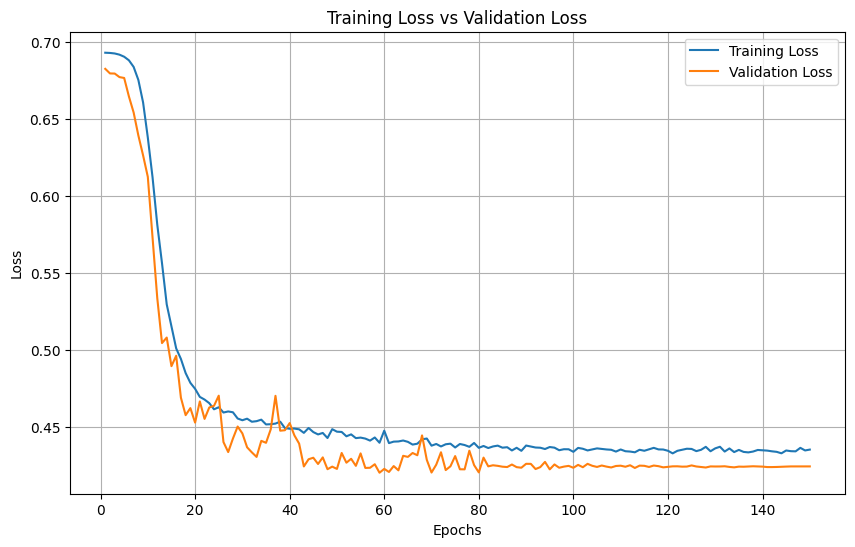

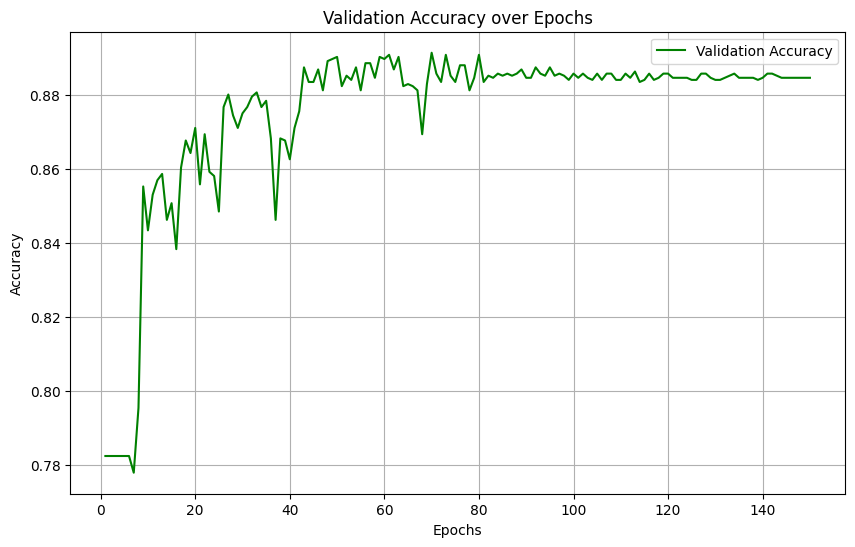

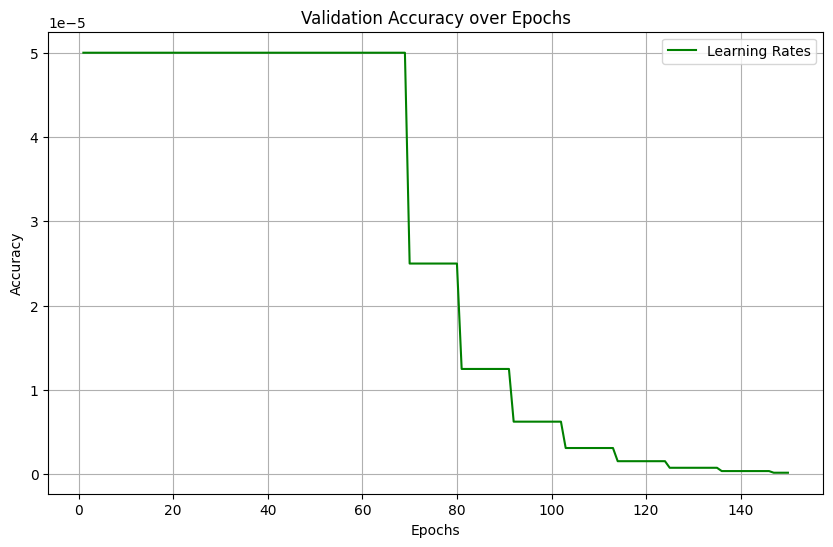

Model for bin 10 saved to 3DCholesterolModels-5A_exp4/model_bin_10.pth
1925 is length of subset grid
Training on bin 11
Bin 11, Epoch 1/150, Train Loss: 0.6930, Validation Loss: 0.6858, Validation Accuracy: 0.7825, Grad Norm: 0.0480, LR: 0.000050
Bin 11, Epoch 11/150, Train Loss: 0.6367, Validation Loss: 0.5663, Validation Accuracy: 0.8525, Grad Norm: 1.1816, LR: 0.000050
Bin 11, Epoch 21/150, Train Loss: 0.4720, Validation Loss: 0.4555, Validation Accuracy: 0.8706, Grad Norm: 0.4281, LR: 0.000050
Bin 11, Epoch 31/150, Train Loss: 0.4531, Validation Loss: 0.4451, Validation Accuracy: 0.8734, Grad Norm: 5.3650, LR: 0.000050
Bin 11, Epoch 41/150, Train Loss: 0.4461, Validation Loss: 0.4315, Validation Accuracy: 0.8853, Grad Norm: 5.8613, LR: 0.000050
Bin 11, Epoch 51/150, Train Loss: 0.4428, Validation Loss: 0.4241, Validation Accuracy: 0.8887, Grad Norm: 1.8204, LR: 0.000050
Bin 11, Epoch 61/150, Train Loss: 0.4370, Validation Loss: 0.4195, Validation Accuracy: 0.8921, Grad Norm: 3.3684

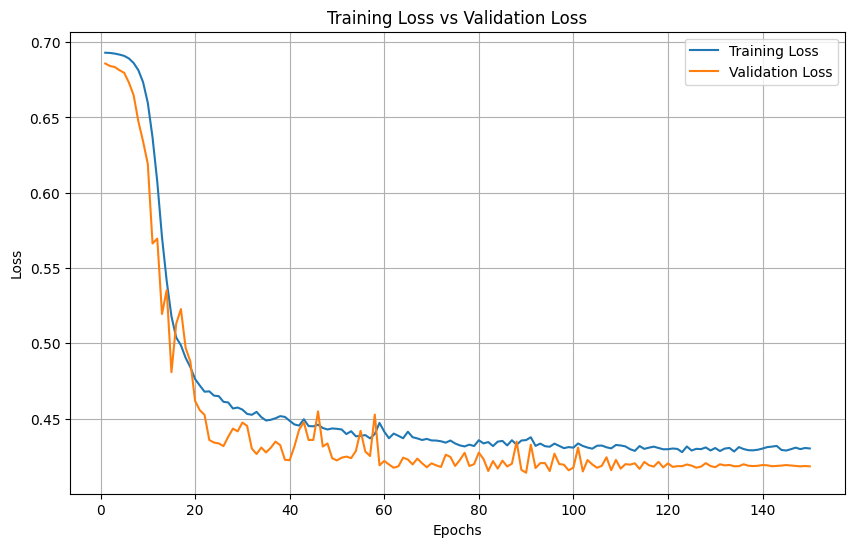

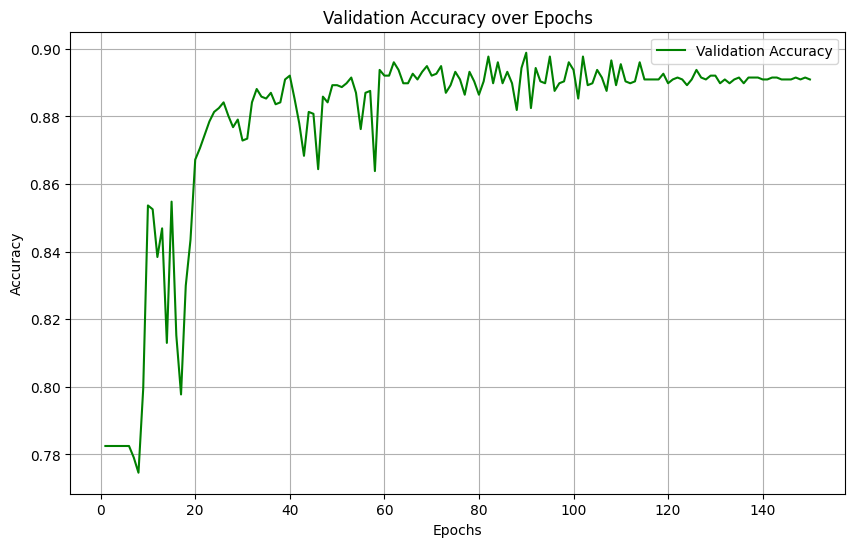

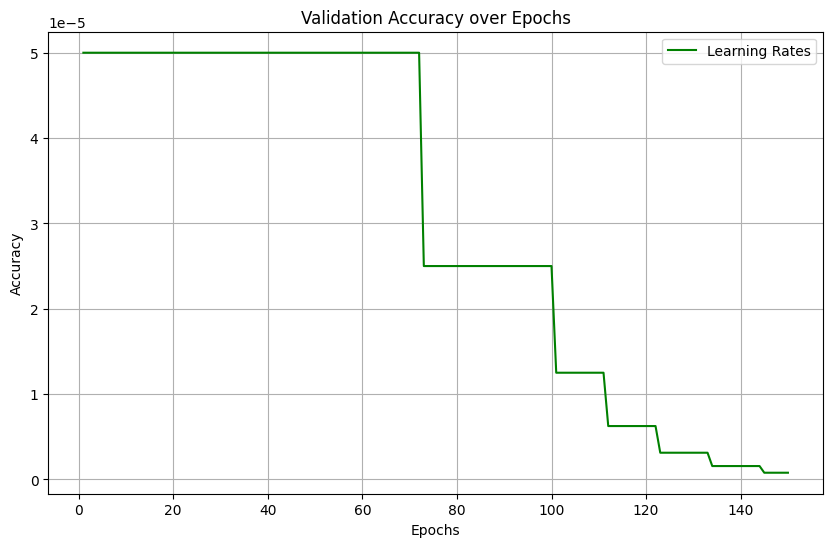

Model for bin 11 saved to 3DCholesterolModels-5A_exp4/model_bin_11.pth
1925 is length of subset grid
Training on bin 12
Bin 12, Epoch 1/150, Train Loss: 0.6931, Validation Loss: 0.6992, Validation Accuracy: 0.2175, Grad Norm: 0.0330, LR: 0.000050
Bin 12, Epoch 11/150, Train Loss: 0.6165, Validation Loss: 0.5936, Validation Accuracy: 0.8153, Grad Norm: 5.6971, LR: 0.000050
Bin 12, Epoch 21/150, Train Loss: 0.4786, Validation Loss: 0.4587, Validation Accuracy: 0.8605, Grad Norm: 6.0779, LR: 0.000050
Bin 12, Epoch 31/150, Train Loss: 0.4581, Validation Loss: 0.4428, Validation Accuracy: 0.8706, Grad Norm: 3.4202, LR: 0.000050
Bin 12, Epoch 41/150, Train Loss: 0.4496, Validation Loss: 0.4360, Validation Accuracy: 0.8802, Grad Norm: 5.0902, LR: 0.000050
Bin 12, Epoch 51/150, Train Loss: 0.4405, Validation Loss: 0.4353, Validation Accuracy: 0.8785, Grad Norm: 2.7586, LR: 0.000050
Bin 12, Epoch 61/150, Train Loss: 0.4438, Validation Loss: 0.4677, Validation Accuracy: 0.8469, Grad Norm: 6.1338

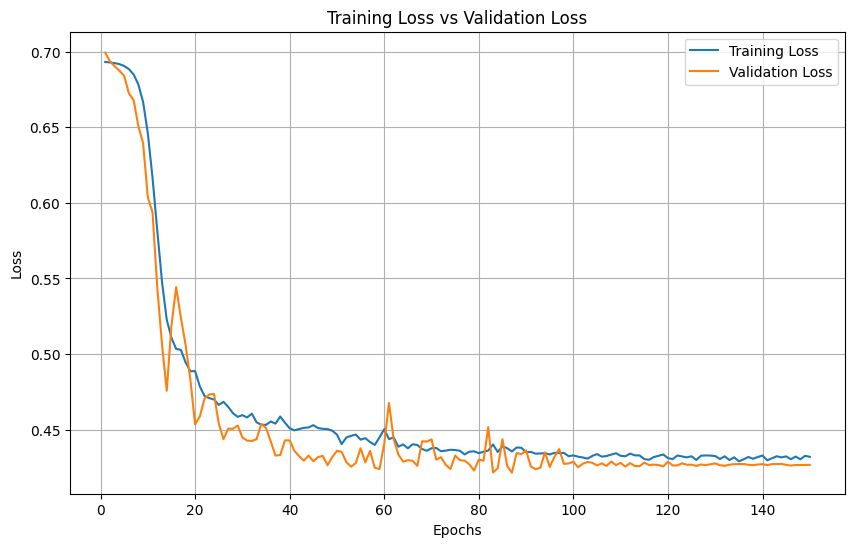

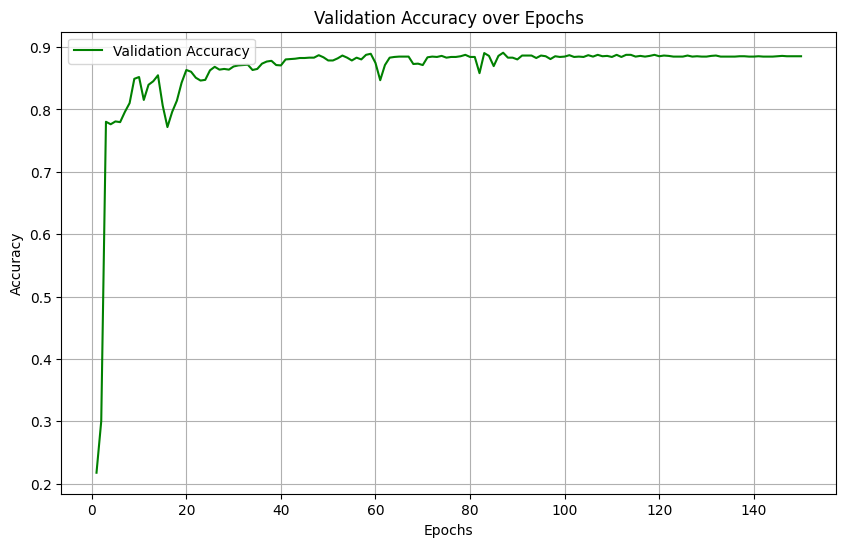

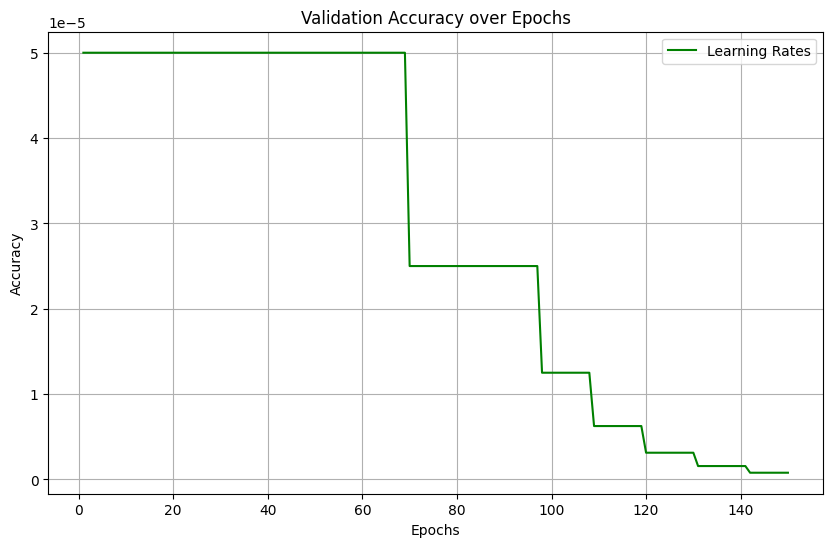

Model for bin 12 saved to 3DCholesterolModels-5A_exp4/model_bin_12.pth
1925 is length of subset grid
Training on bin 13
Bin 13, Epoch 1/150, Train Loss: 0.6937, Validation Loss: 0.6704, Validation Accuracy: 0.7825, Grad Norm: 0.0941, LR: 0.000050
Bin 13, Epoch 11/150, Train Loss: 0.6341, Validation Loss: 0.5643, Validation Accuracy: 0.8469, Grad Norm: 1.0227, LR: 0.000050
Bin 13, Epoch 21/150, Train Loss: 0.4857, Validation Loss: 0.4789, Validation Accuracy: 0.8412, Grad Norm: 1.0728, LR: 0.000050
Bin 13, Epoch 31/150, Train Loss: 0.4664, Validation Loss: 0.4495, Validation Accuracy: 0.8672, Grad Norm: 2.5503, LR: 0.000050
Bin 13, Epoch 41/150, Train Loss: 0.4597, Validation Loss: 0.4362, Validation Accuracy: 0.8774, Grad Norm: 3.4145, LR: 0.000050
Bin 13, Epoch 51/150, Train Loss: 0.4580, Validation Loss: 0.4263, Validation Accuracy: 0.8870, Grad Norm: 6.3033, LR: 0.000050
Bin 13, Epoch 61/150, Train Loss: 0.4508, Validation Loss: 0.4493, Validation Accuracy: 0.8644, Grad Norm: 0.4867

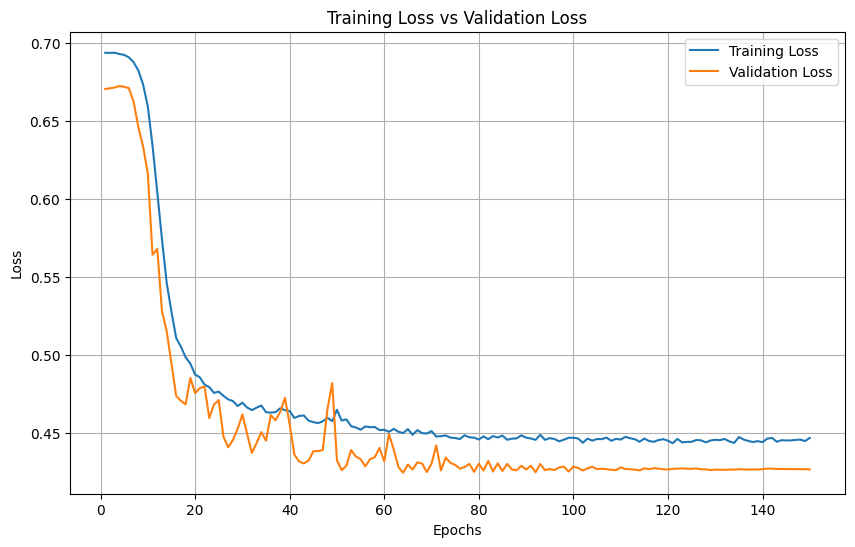

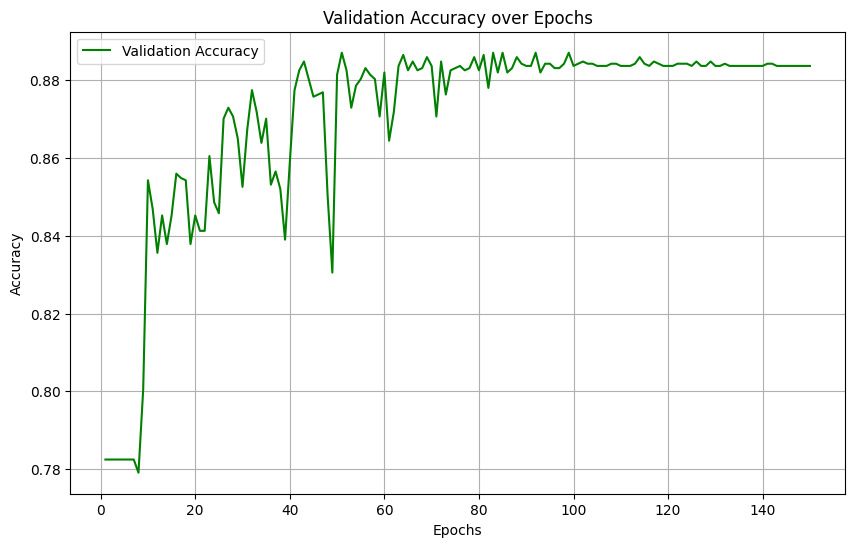

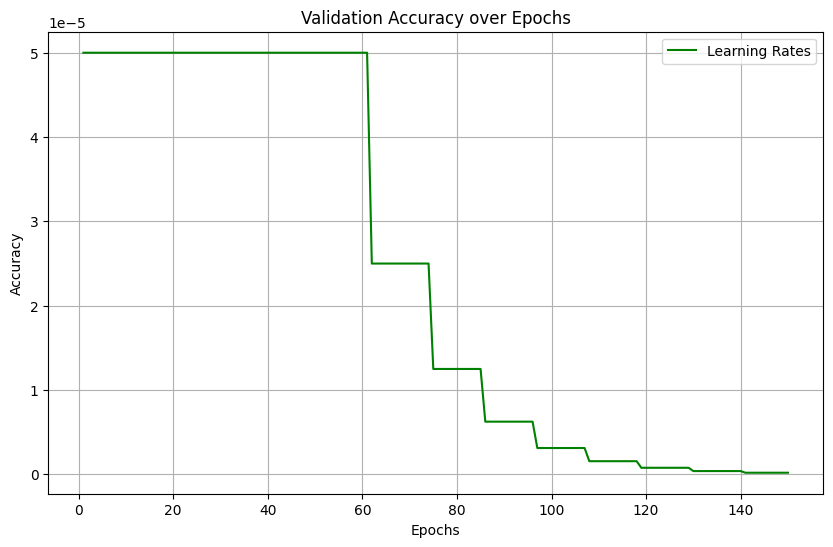

Model for bin 13 saved to 3DCholesterolModels-5A_exp4/model_bin_13.pth
1925 is length of subset grid
Training on bin 14
Bin 14, Epoch 1/150, Train Loss: 0.6930, Validation Loss: 0.6904, Validation Accuracy: 0.7825, Grad Norm: 0.0973, LR: 0.000050
Bin 14, Epoch 11/150, Train Loss: 0.6444, Validation Loss: 0.6075, Validation Accuracy: 0.8582, Grad Norm: 0.9909, LR: 0.000050
Bin 14, Epoch 21/150, Train Loss: 0.4751, Validation Loss: 0.4416, Validation Accuracy: 0.8791, Grad Norm: 1.2847, LR: 0.000050
Bin 14, Epoch 31/150, Train Loss: 0.4553, Validation Loss: 0.4429, Validation Accuracy: 0.8797, Grad Norm: 0.6913, LR: 0.000050
Bin 14, Epoch 41/150, Train Loss: 0.4454, Validation Loss: 0.4285, Validation Accuracy: 0.8831, Grad Norm: 5.0957, LR: 0.000050
Bin 14, Epoch 51/150, Train Loss: 0.4413, Validation Loss: 0.4430, Validation Accuracy: 0.8751, Grad Norm: 0.2515, LR: 0.000050
Bin 14, Epoch 61/150, Train Loss: 0.4394, Validation Loss: 0.4412, Validation Accuracy: 0.8757, Grad Norm: 6.2375

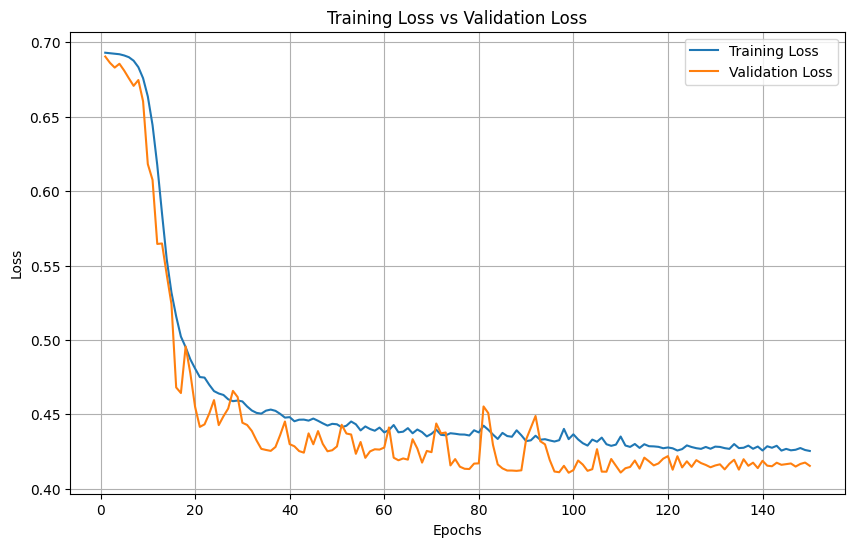

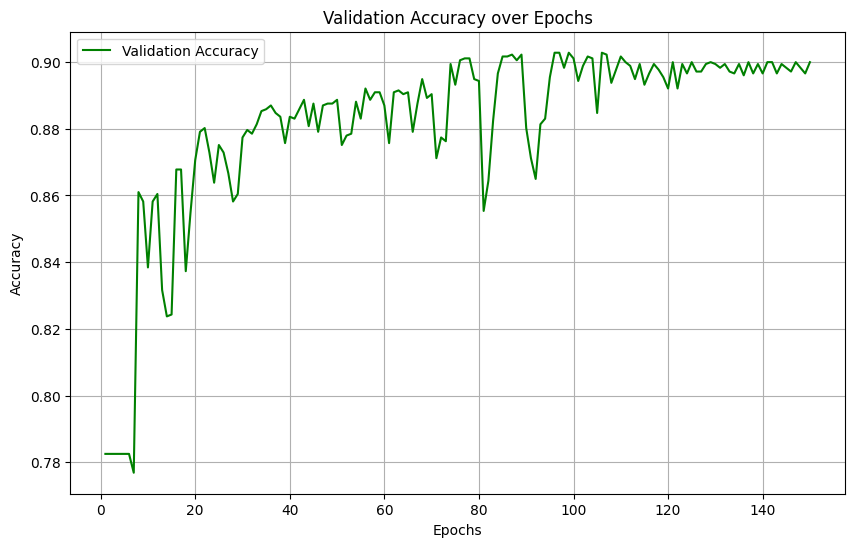

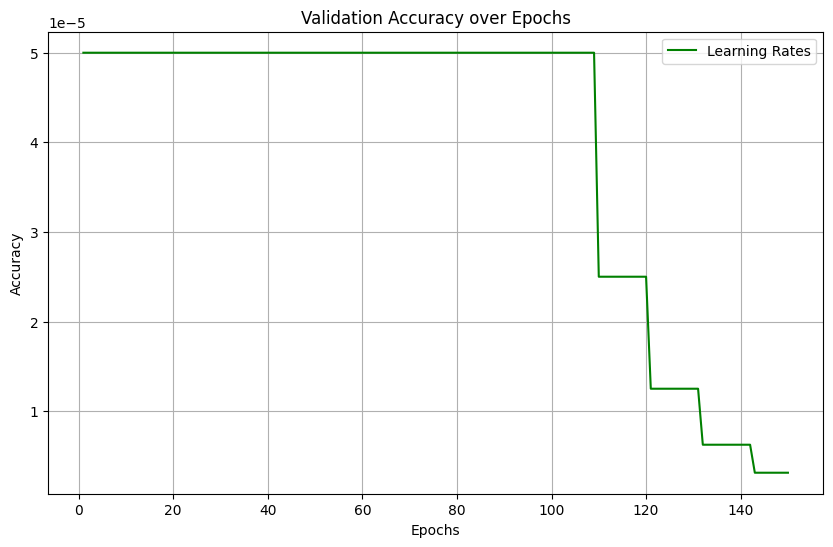

Model for bin 14 saved to 3DCholesterolModels-5A_exp4/model_bin_14.pth
1925 is length of subset grid
Training on bin 15
Bin 15, Epoch 1/150, Train Loss: 0.6931, Validation Loss: 0.6964, Validation Accuracy: 0.2175, Grad Norm: 0.0376, LR: 0.000050
Bin 15, Epoch 11/150, Train Loss: 0.6178, Validation Loss: 0.5398, Validation Accuracy: 0.8475, Grad Norm: 3.4796, LR: 0.000050
Bin 15, Epoch 21/150, Train Loss: 0.4667, Validation Loss: 0.4713, Validation Accuracy: 0.8452, Grad Norm: 2.2165, LR: 0.000050
Bin 15, Epoch 31/150, Train Loss: 0.4536, Validation Loss: 0.4299, Validation Accuracy: 0.8842, Grad Norm: 6.2692, LR: 0.000050
Bin 15, Epoch 41/150, Train Loss: 0.4481, Validation Loss: 0.4469, Validation Accuracy: 0.8678, Grad Norm: 1.0209, LR: 0.000050
Bin 15, Epoch 51/150, Train Loss: 0.4431, Validation Loss: 0.4236, Validation Accuracy: 0.8938, Grad Norm: 3.6518, LR: 0.000050
Bin 15, Epoch 61/150, Train Loss: 0.4397, Validation Loss: 0.4231, Validation Accuracy: 0.8932, Grad Norm: 4.5086

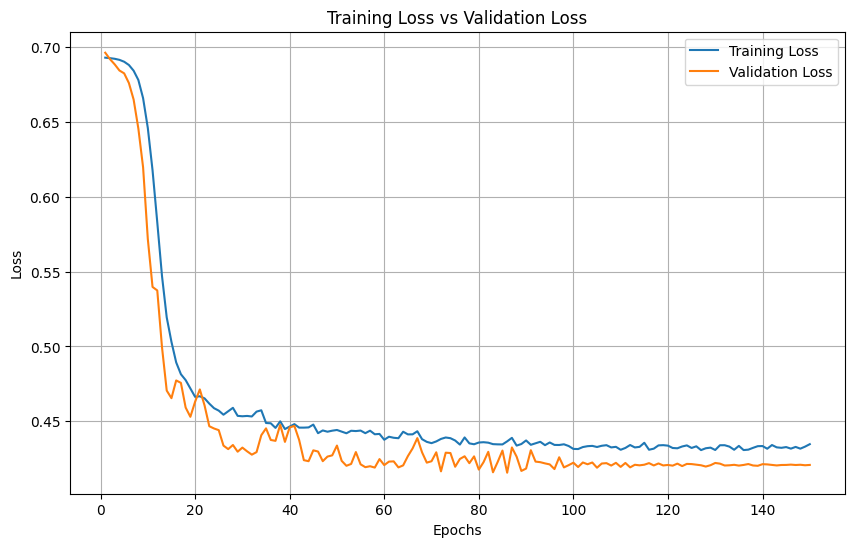

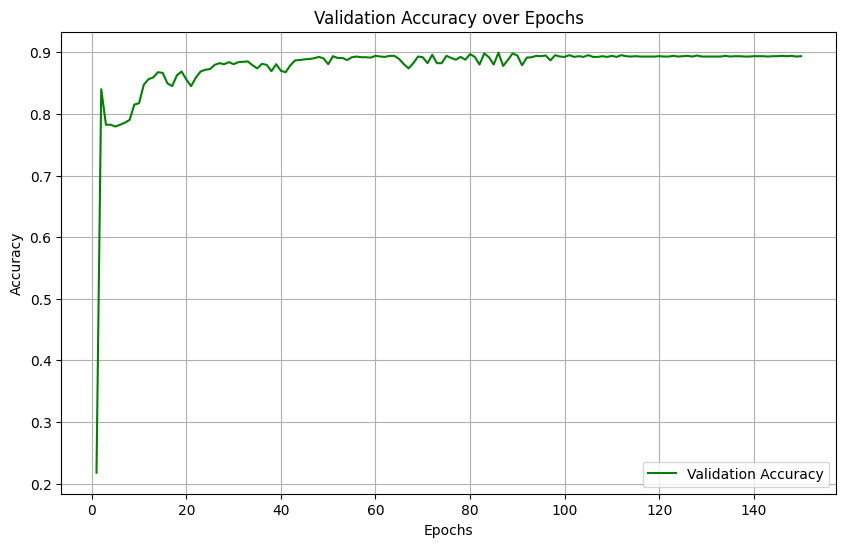

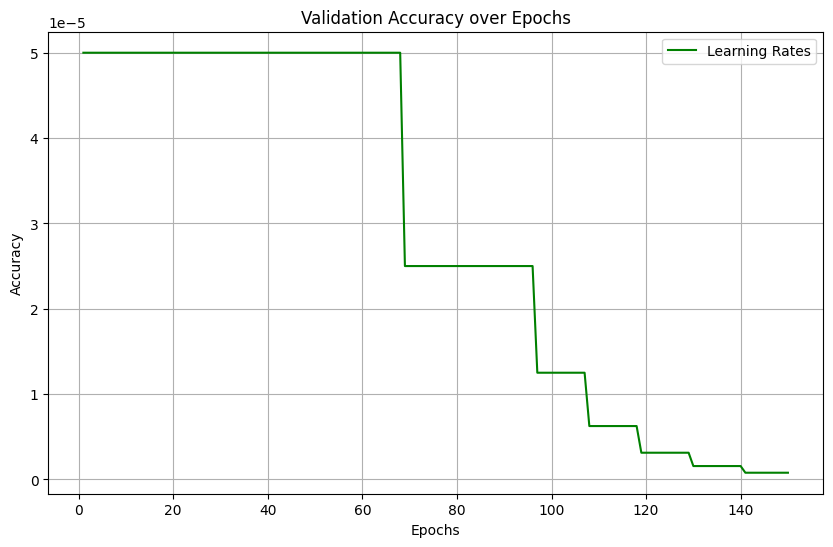

Model for bin 15 saved to 3DCholesterolModels-5A_exp4/model_bin_15.pth
1925 is length of subset grid
Training on bin 16
Bin 16, Epoch 1/150, Train Loss: 0.6930, Validation Loss: 0.6844, Validation Accuracy: 0.7825, Grad Norm: 0.1750, LR: 0.000050
Bin 16, Epoch 11/150, Train Loss: 0.5517, Validation Loss: 0.5135, Validation Accuracy: 0.8514, Grad Norm: 0.6794, LR: 0.000050
Bin 16, Epoch 21/150, Train Loss: 0.4662, Validation Loss: 0.4465, Validation Accuracy: 0.8695, Grad Norm: 2.3105, LR: 0.000050
Bin 16, Epoch 31/150, Train Loss: 0.4567, Validation Loss: 0.4409, Validation Accuracy: 0.8734, Grad Norm: 0.2227, LR: 0.000050
Bin 16, Epoch 41/150, Train Loss: 0.4532, Validation Loss: 0.4399, Validation Accuracy: 0.8746, Grad Norm: 0.2997, LR: 0.000025
Bin 16, Epoch 51/150, Train Loss: 0.4499, Validation Loss: 0.4390, Validation Accuracy: 0.8746, Grad Norm: 3.1578, LR: 0.000013
Bin 16, Epoch 61/150, Train Loss: 0.4480, Validation Loss: 0.4412, Validation Accuracy: 0.8678, Grad Norm: 0.8705

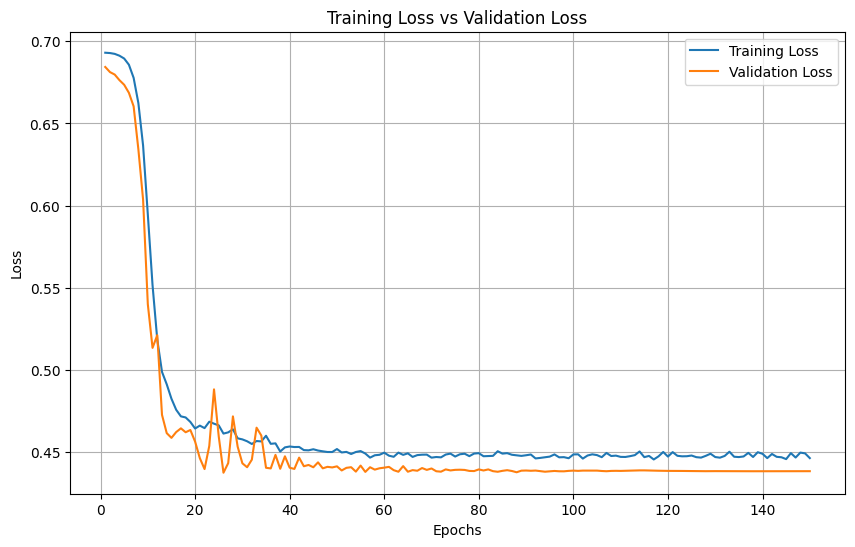

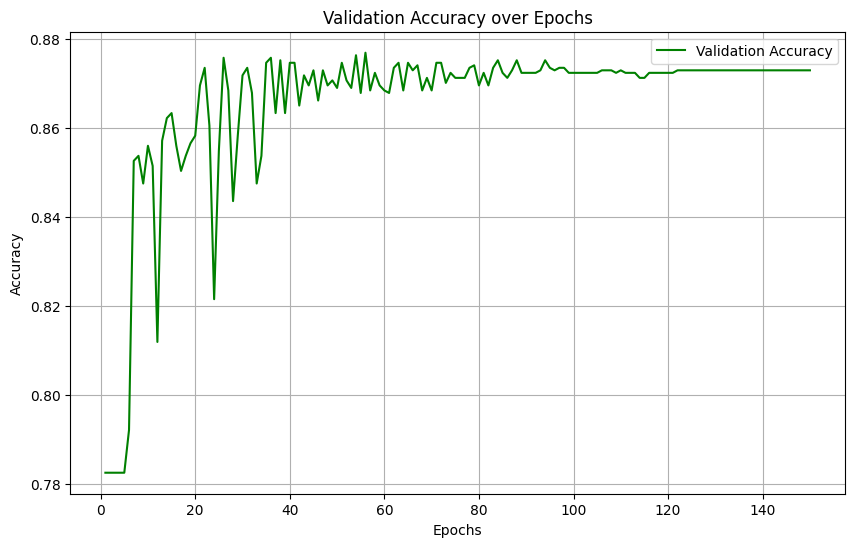

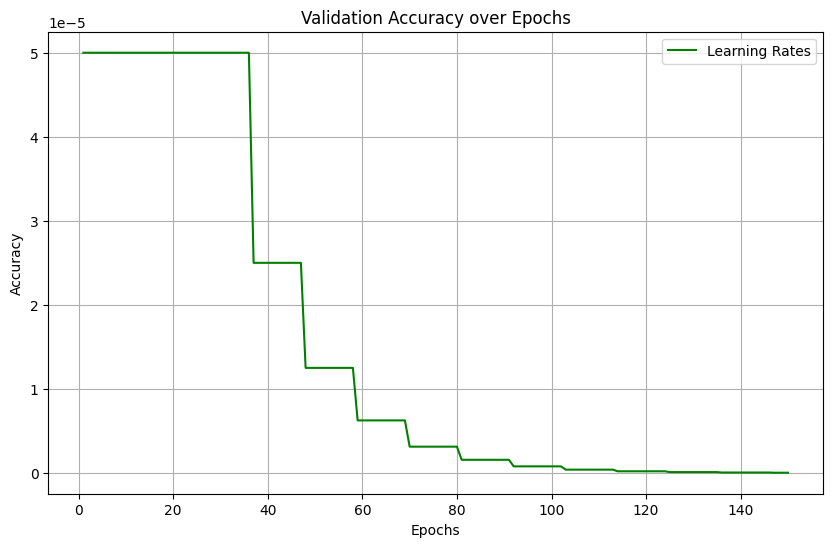

Model for bin 16 saved to 3DCholesterolModels-5A_exp4/model_bin_16.pth
1925 is length of subset grid
Training on bin 17
Bin 17, Epoch 1/150, Train Loss: 0.6930, Validation Loss: 0.6898, Validation Accuracy: 0.7825, Grad Norm: 0.0971, LR: 0.000050
Bin 17, Epoch 11/150, Train Loss: 0.5728, Validation Loss: 0.5115, Validation Accuracy: 0.8582, Grad Norm: 3.6671, LR: 0.000050
Bin 17, Epoch 21/150, Train Loss: 0.4644, Validation Loss: 0.4577, Validation Accuracy: 0.8593, Grad Norm: 2.2975, LR: 0.000050
Bin 17, Epoch 31/150, Train Loss: 0.4571, Validation Loss: 0.4566, Validation Accuracy: 0.8593, Grad Norm: 3.3465, LR: 0.000050
Bin 17, Epoch 41/150, Train Loss: 0.4489, Validation Loss: 0.4310, Validation Accuracy: 0.8774, Grad Norm: 1.6506, LR: 0.000050
Bin 17, Epoch 51/150, Train Loss: 0.4481, Validation Loss: 0.4272, Validation Accuracy: 0.8831, Grad Norm: 0.7934, LR: 0.000050
Bin 17, Epoch 61/150, Train Loss: 0.4430, Validation Loss: 0.4294, Validation Accuracy: 0.8842, Grad Norm: 2.4239

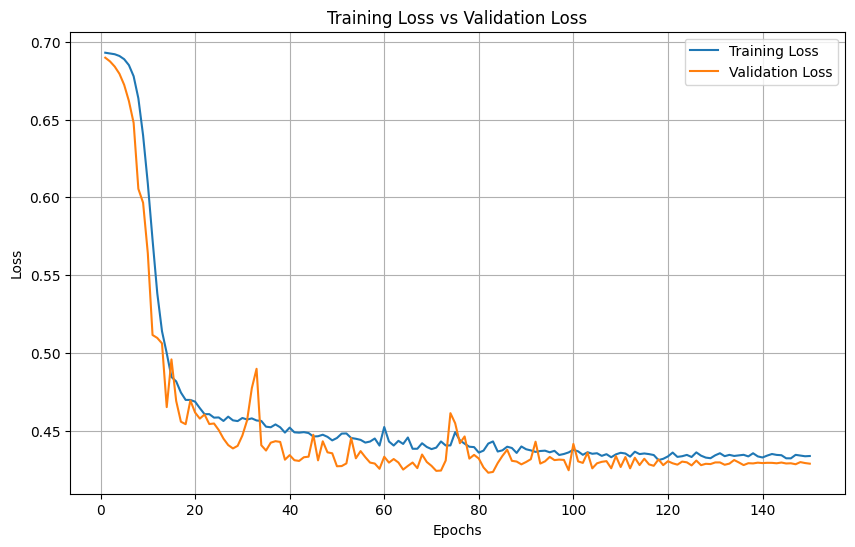

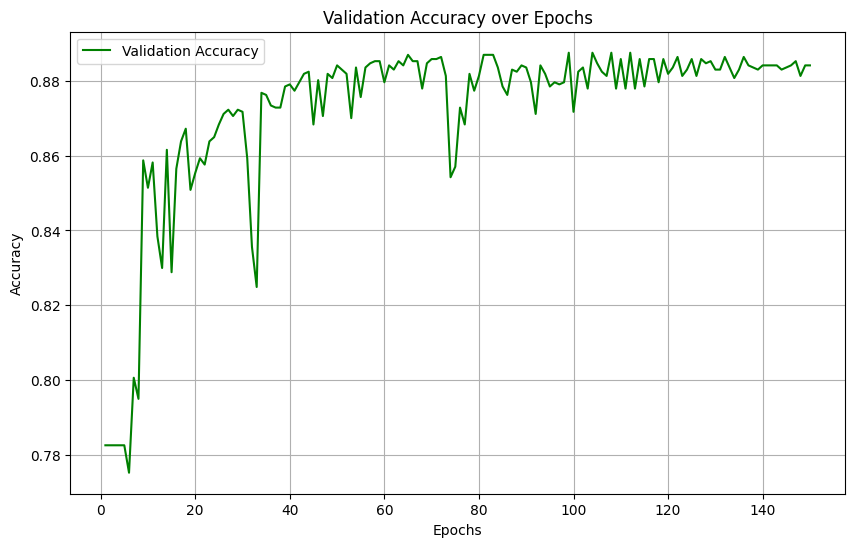

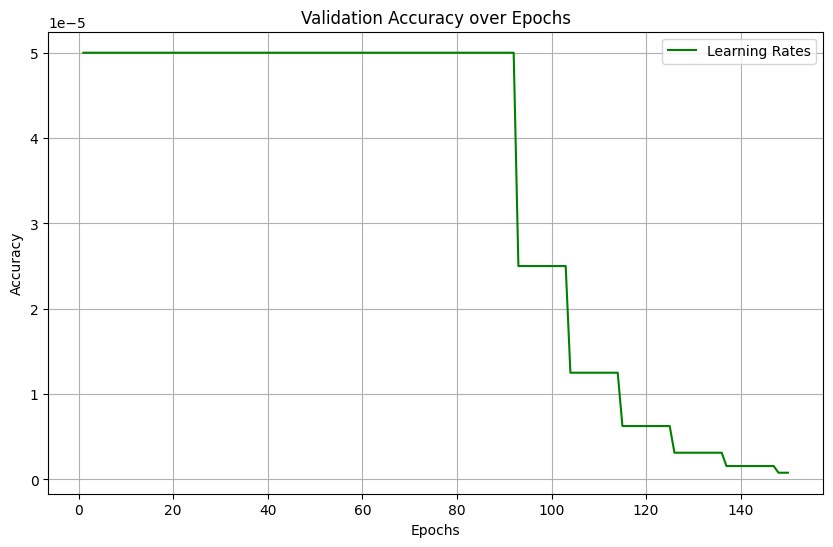

Model for bin 17 saved to 3DCholesterolModels-5A_exp4/model_bin_17.pth
1925 is length of subset grid
Training on bin 18
Bin 18, Epoch 1/150, Train Loss: 0.6934, Validation Loss: 0.7050, Validation Accuracy: 0.2175, Grad Norm: 0.1068, LR: 0.000050
Bin 18, Epoch 11/150, Train Loss: 0.6217, Validation Loss: 0.5403, Validation Accuracy: 0.8531, Grad Norm: 1.0246, LR: 0.000050
Bin 18, Epoch 21/150, Train Loss: 0.4677, Validation Loss: 0.4415, Validation Accuracy: 0.8768, Grad Norm: 3.4089, LR: 0.000050
Bin 18, Epoch 31/150, Train Loss: 0.4562, Validation Loss: 0.4411, Validation Accuracy: 0.8723, Grad Norm: 4.5190, LR: 0.000050
Bin 18, Epoch 41/150, Train Loss: 0.4515, Validation Loss: 0.4345, Validation Accuracy: 0.8780, Grad Norm: 0.7940, LR: 0.000050
Bin 18, Epoch 51/150, Train Loss: 0.4442, Validation Loss: 0.4334, Validation Accuracy: 0.8791, Grad Norm: 5.7415, LR: 0.000050
Bin 18, Epoch 61/150, Train Loss: 0.4437, Validation Loss: 0.4253, Validation Accuracy: 0.8887, Grad Norm: 2.1220

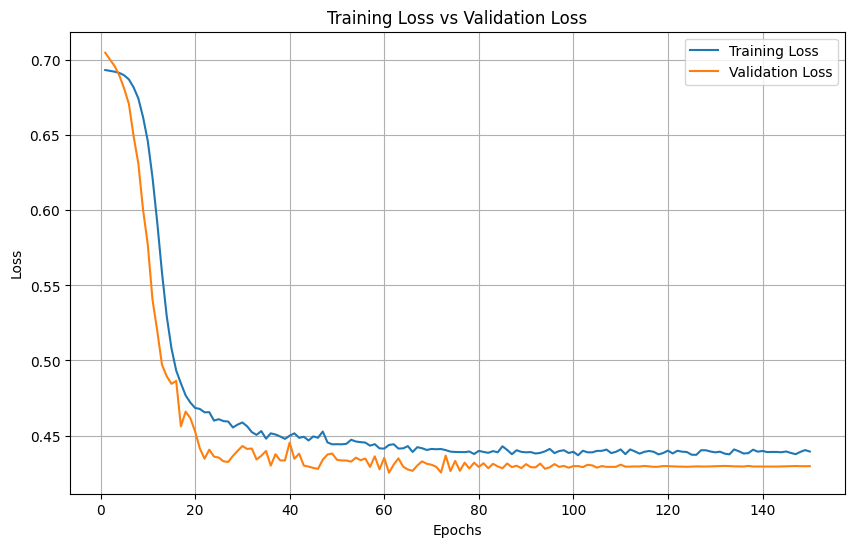

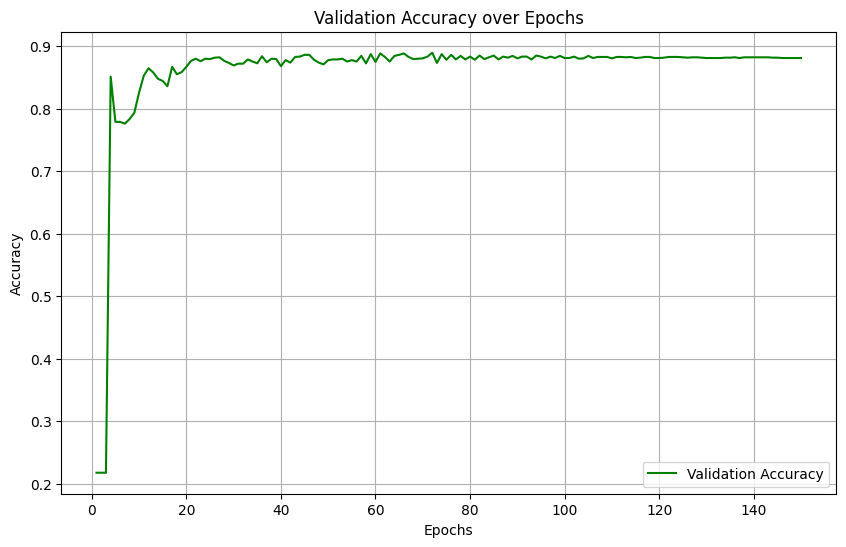

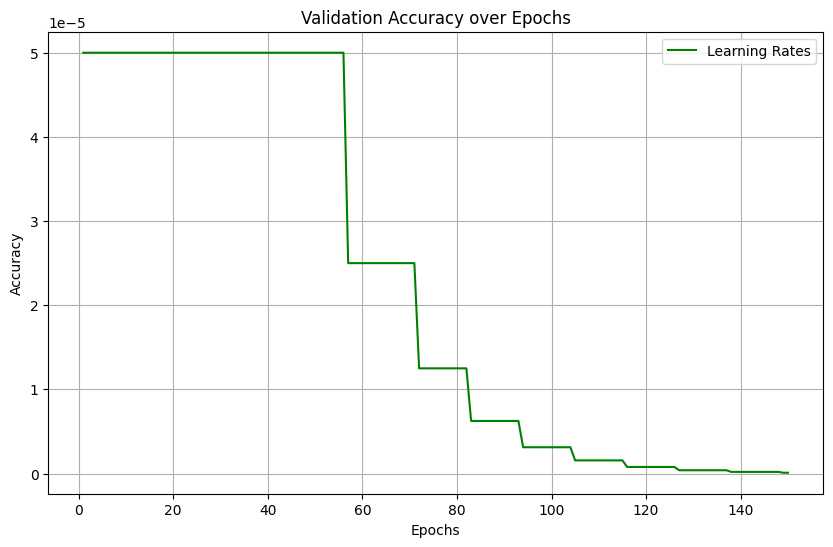

Model for bin 18 saved to 3DCholesterolModels-5A_exp4/model_bin_18.pth
1925 is length of subset grid
Training on bin 19
Bin 19, Epoch 1/150, Train Loss: 0.6931, Validation Loss: 0.6993, Validation Accuracy: 0.2175, Grad Norm: 0.0628, LR: 0.000050
Bin 19, Epoch 11/150, Train Loss: 0.6150, Validation Loss: 0.5372, Validation Accuracy: 0.8548, Grad Norm: 0.8471, LR: 0.000050
Bin 19, Epoch 21/150, Train Loss: 0.4716, Validation Loss: 0.5105, Validation Accuracy: 0.8017, Grad Norm: 6.4135, LR: 0.000050
Bin 19, Epoch 31/150, Train Loss: 0.4532, Validation Loss: 0.4396, Validation Accuracy: 0.8751, Grad Norm: 4.6995, LR: 0.000050
Bin 19, Epoch 41/150, Train Loss: 0.4504, Validation Loss: 0.4304, Validation Accuracy: 0.8864, Grad Norm: 2.5720, LR: 0.000050
Bin 19, Epoch 51/150, Train Loss: 0.4450, Validation Loss: 0.4324, Validation Accuracy: 0.8819, Grad Norm: 0.7819, LR: 0.000025
Bin 19, Epoch 61/150, Train Loss: 0.4457, Validation Loss: 0.4234, Validation Accuracy: 0.8876, Grad Norm: 5.2788

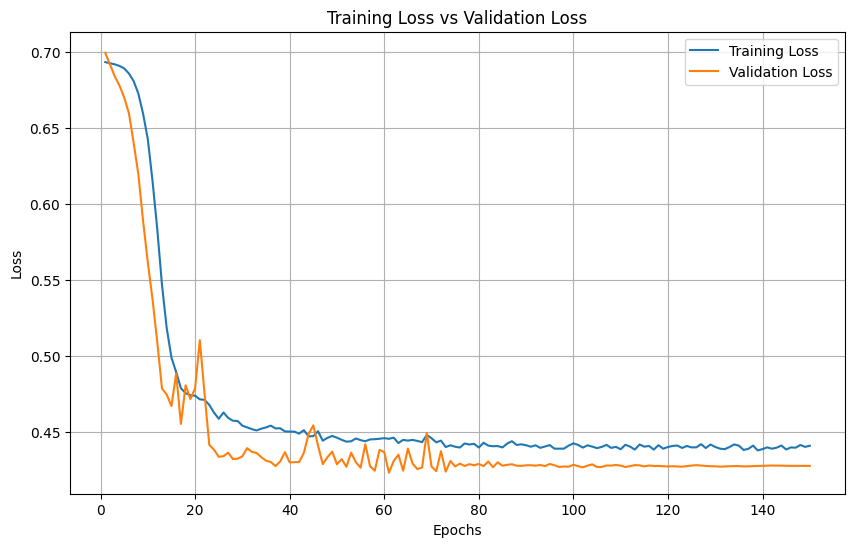

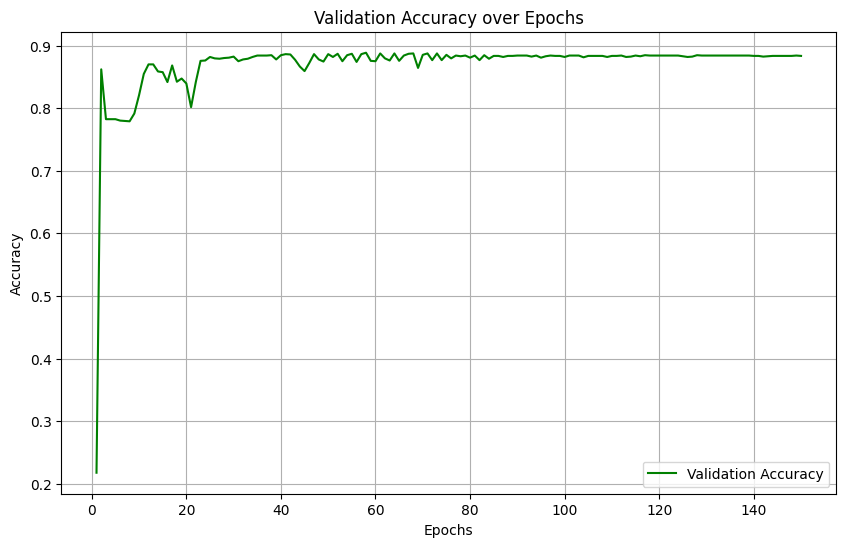

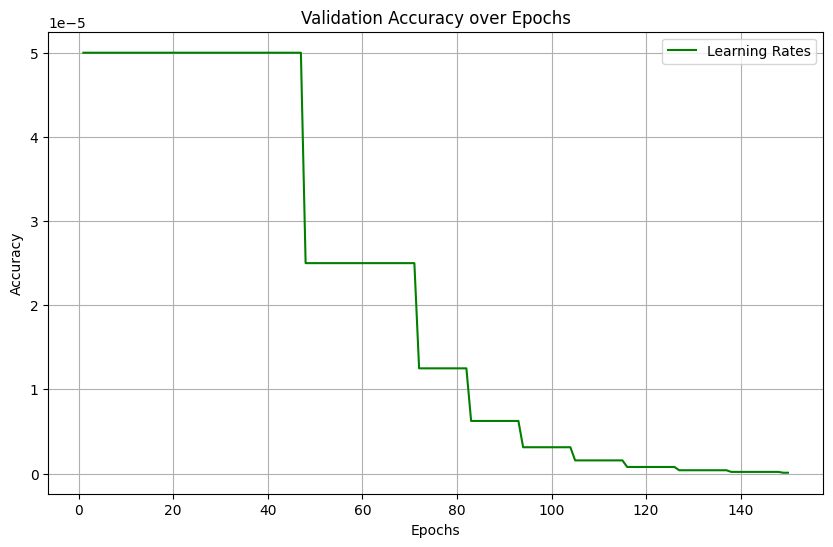

Model for bin 19 saved to 3DCholesterolModels-5A_exp4/model_bin_19.pth
1925 is length of subset grid
Training on bin 20
Bin 20, Epoch 1/150, Train Loss: 0.6932, Validation Loss: 0.6999, Validation Accuracy: 0.2175, Grad Norm: 0.0657, LR: 0.000050
Bin 20, Epoch 11/150, Train Loss: 0.6089, Validation Loss: 0.5547, Validation Accuracy: 0.8542, Grad Norm: 1.3793, LR: 0.000050
Bin 20, Epoch 21/150, Train Loss: 0.4668, Validation Loss: 0.4508, Validation Accuracy: 0.8718, Grad Norm: 1.8297, LR: 0.000050
Bin 20, Epoch 31/150, Train Loss: 0.4562, Validation Loss: 0.4532, Validation Accuracy: 0.8672, Grad Norm: 6.7248, LR: 0.000050
Bin 20, Epoch 41/150, Train Loss: 0.4464, Validation Loss: 0.4488, Validation Accuracy: 0.8678, Grad Norm: 1.9228, LR: 0.000050
Bin 20, Epoch 51/150, Train Loss: 0.4451, Validation Loss: 0.4239, Validation Accuracy: 0.8893, Grad Norm: 1.2222, LR: 0.000050
Bin 20, Epoch 61/150, Train Loss: 0.4385, Validation Loss: 0.4288, Validation Accuracy: 0.8847, Grad Norm: 2.8975

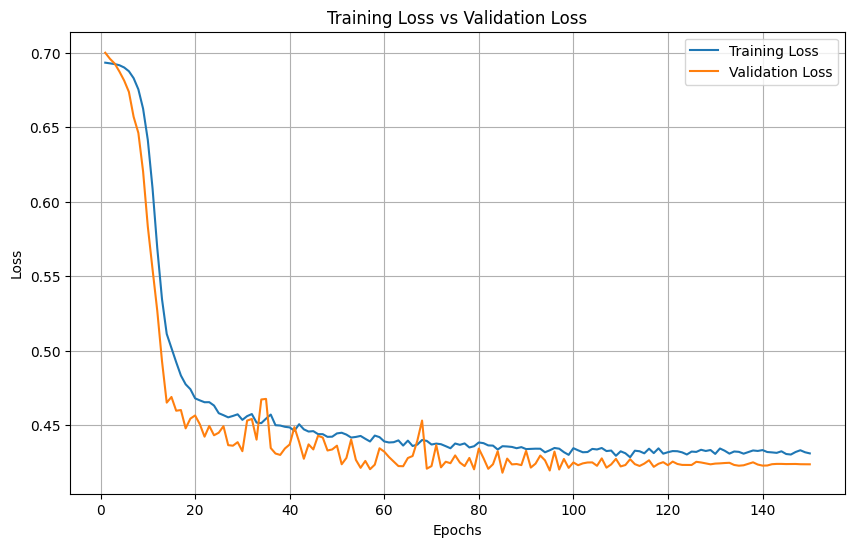

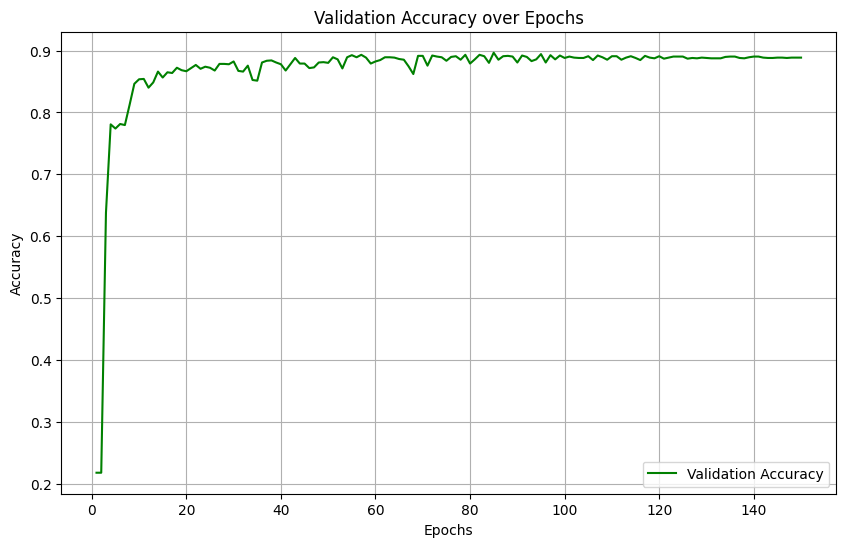

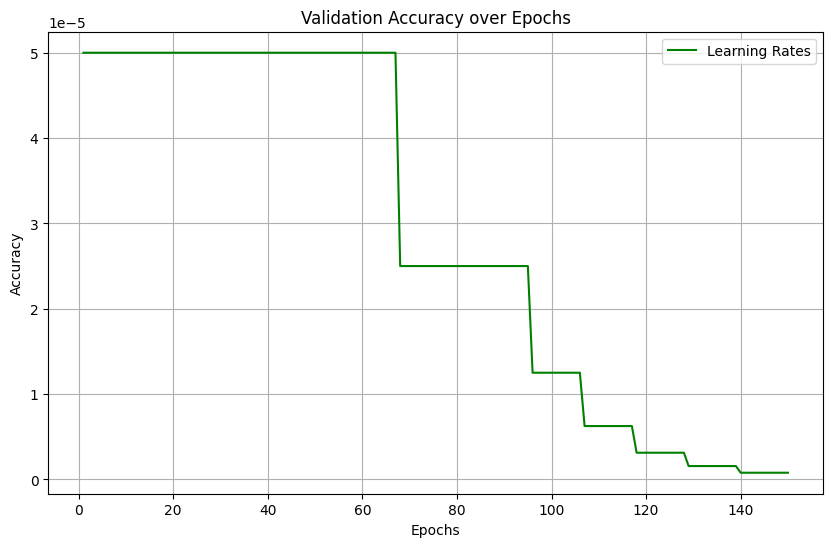

Model for bin 20 saved to 3DCholesterolModels-5A_exp4/model_bin_20.pth
1925 is length of subset grid
Training on bin 21
Bin 21, Epoch 1/150, Train Loss: 0.6930, Validation Loss: 0.6986, Validation Accuracy: 0.2175, Grad Norm: 0.0749, LR: 0.000050
Bin 21, Epoch 11/150, Train Loss: 0.5856, Validation Loss: 0.5136, Validation Accuracy: 0.8554, Grad Norm: 1.9536, LR: 0.000050
Bin 21, Epoch 21/150, Train Loss: 0.4692, Validation Loss: 0.4557, Validation Accuracy: 0.8644, Grad Norm: 1.8753, LR: 0.000050
Bin 21, Epoch 31/150, Train Loss: 0.4559, Validation Loss: 0.4423, Validation Accuracy: 0.8718, Grad Norm: 3.3532, LR: 0.000050
Bin 21, Epoch 41/150, Train Loss: 0.4539, Validation Loss: 0.4455, Validation Accuracy: 0.8695, Grad Norm: 6.6800, LR: 0.000050
Bin 21, Epoch 51/150, Train Loss: 0.4438, Validation Loss: 0.4379, Validation Accuracy: 0.8780, Grad Norm: 1.2492, LR: 0.000050
Bin 21, Epoch 61/150, Train Loss: 0.4459, Validation Loss: 0.4214, Validation Accuracy: 0.8915, Grad Norm: 6.2811

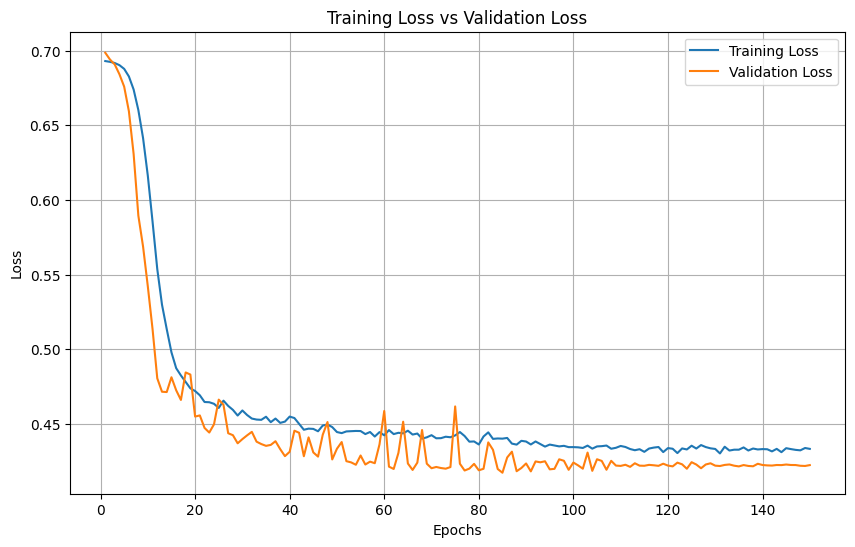

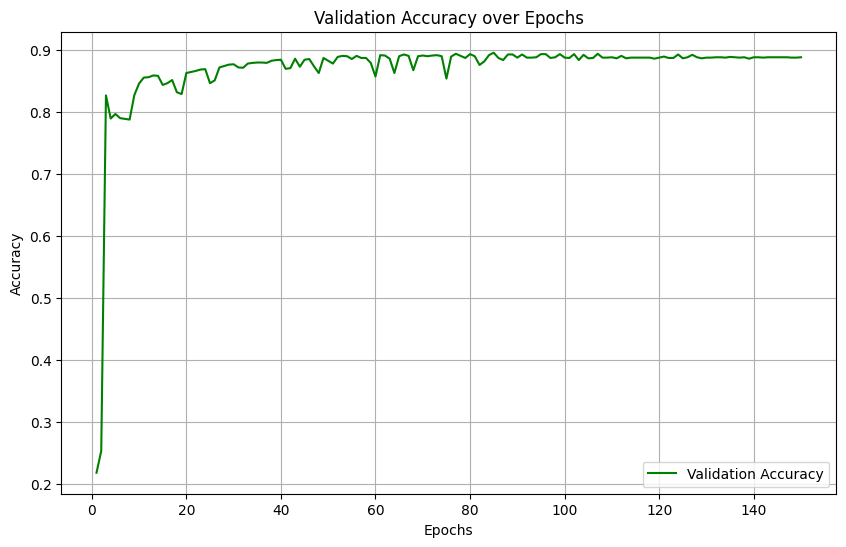

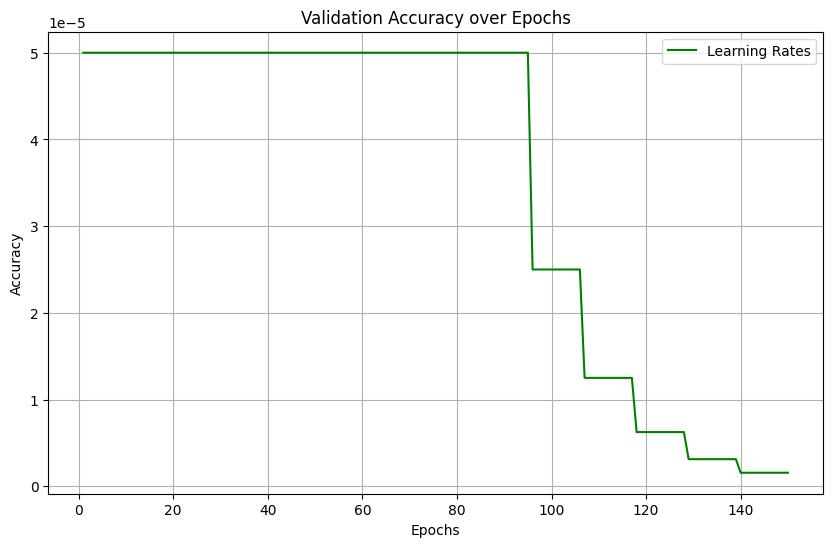

Model for bin 21 saved to 3DCholesterolModels-5A_exp4/model_bin_21.pth
1925 is length of subset grid
Training on bin 22
Bin 22, Epoch 1/150, Train Loss: 0.6931, Validation Loss: 0.6976, Validation Accuracy: 0.2175, Grad Norm: 0.0719, LR: 0.000050
Bin 22, Epoch 11/150, Train Loss: 0.6023, Validation Loss: 0.5642, Validation Accuracy: 0.8435, Grad Norm: 3.9276, LR: 0.000050
Bin 22, Epoch 21/150, Train Loss: 0.4623, Validation Loss: 0.4428, Validation Accuracy: 0.8734, Grad Norm: 5.2941, LR: 0.000050
Bin 22, Epoch 31/150, Train Loss: 0.4500, Validation Loss: 0.4304, Validation Accuracy: 0.8825, Grad Norm: 6.3630, LR: 0.000050
Bin 22, Epoch 41/150, Train Loss: 0.4443, Validation Loss: 0.4254, Validation Accuracy: 0.8870, Grad Norm: 3.5952, LR: 0.000050
Bin 22, Epoch 51/150, Train Loss: 0.4389, Validation Loss: 0.4253, Validation Accuracy: 0.8876, Grad Norm: 2.0131, LR: 0.000050
Bin 22, Epoch 61/150, Train Loss: 0.4346, Validation Loss: 0.4264, Validation Accuracy: 0.8898, Grad Norm: 6.1938

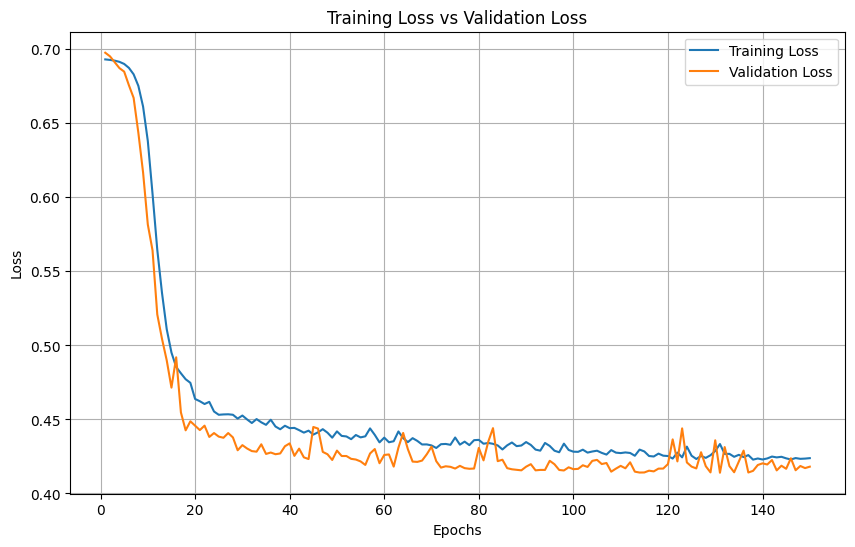

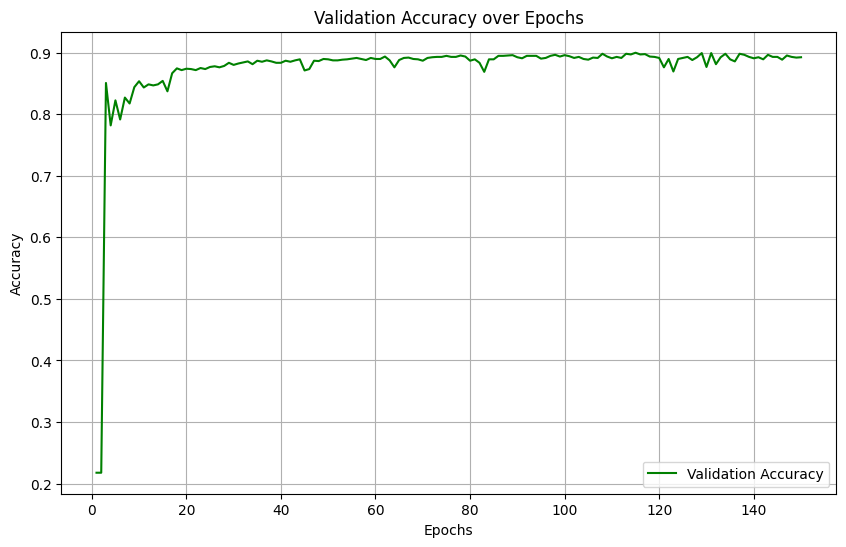

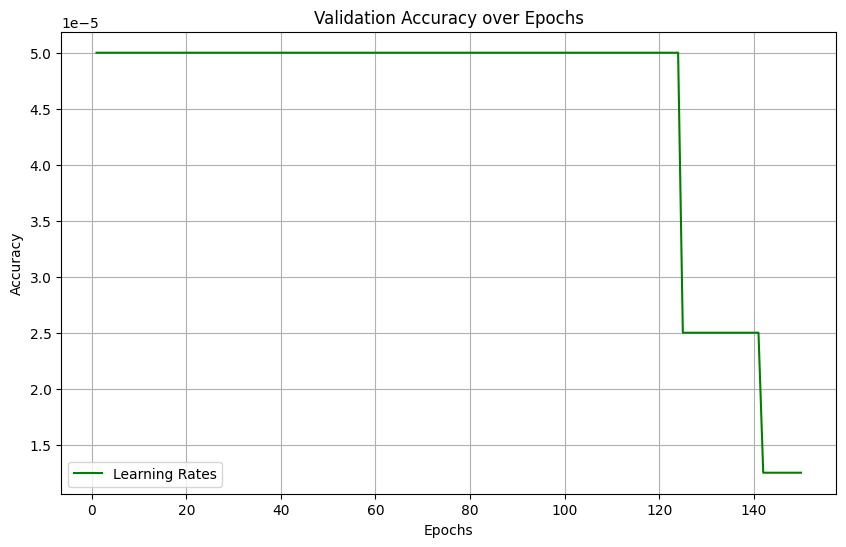

Model for bin 22 saved to 3DCholesterolModels-5A_exp4/model_bin_22.pth
1925 is length of subset grid
Training on bin 23
Bin 23, Epoch 1/150, Train Loss: 0.6931, Validation Loss: 0.6934, Validation Accuracy: 0.2266, Grad Norm: 0.1319, LR: 0.000050
Bin 23, Epoch 11/150, Train Loss: 0.6427, Validation Loss: 0.5988, Validation Accuracy: 0.8565, Grad Norm: 1.2845, LR: 0.000050
Bin 23, Epoch 21/150, Train Loss: 0.4804, Validation Loss: 0.4509, Validation Accuracy: 0.8757, Grad Norm: 4.2431, LR: 0.000050
Bin 23, Epoch 31/150, Train Loss: 0.4634, Validation Loss: 0.4320, Validation Accuracy: 0.8853, Grad Norm: 6.1634, LR: 0.000050
Bin 23, Epoch 41/150, Train Loss: 0.4532, Validation Loss: 0.4227, Validation Accuracy: 0.8915, Grad Norm: 0.4093, LR: 0.000050
Bin 23, Epoch 51/150, Train Loss: 0.4498, Validation Loss: 0.4265, Validation Accuracy: 0.8870, Grad Norm: 1.0883, LR: 0.000050
Bin 23, Epoch 61/150, Train Loss: 0.4474, Validation Loss: 0.4184, Validation Accuracy: 0.8938, Grad Norm: 4.9583

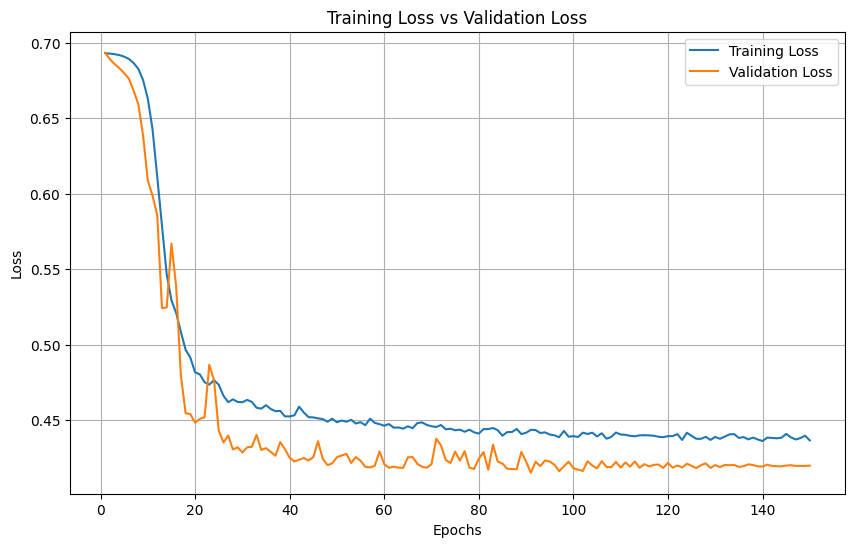

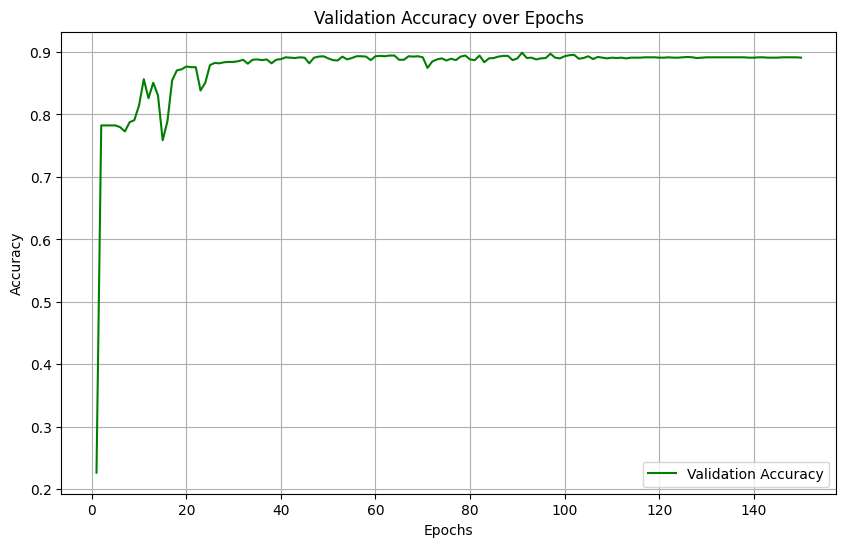

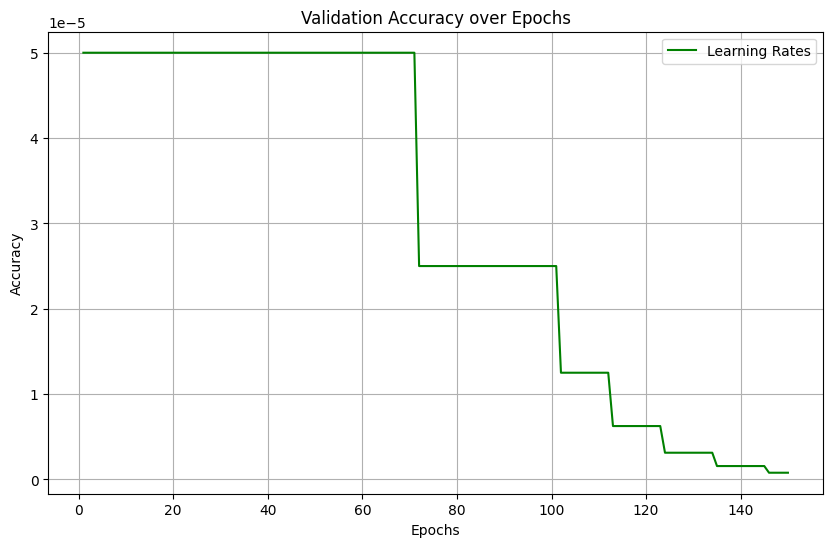

Model for bin 23 saved to 3DCholesterolModels-5A_exp4/model_bin_23.pth
1925 is length of subset grid
Training on bin 24
Bin 24, Epoch 1/150, Train Loss: 0.6933, Validation Loss: 0.6809, Validation Accuracy: 0.7825, Grad Norm: 0.0657, LR: 0.000050
Bin 24, Epoch 11/150, Train Loss: 0.5714, Validation Loss: 0.5466, Validation Accuracy: 0.8367, Grad Norm: 6.2133, LR: 0.000050
Bin 24, Epoch 21/150, Train Loss: 0.4621, Validation Loss: 0.4380, Validation Accuracy: 0.8802, Grad Norm: 4.2730, LR: 0.000050
Bin 24, Epoch 31/150, Train Loss: 0.4484, Validation Loss: 0.4412, Validation Accuracy: 0.8763, Grad Norm: 6.5381, LR: 0.000050
Bin 24, Epoch 41/150, Train Loss: 0.4449, Validation Loss: 0.4335, Validation Accuracy: 0.8819, Grad Norm: 2.6790, LR: 0.000050
Bin 24, Epoch 51/150, Train Loss: 0.4403, Validation Loss: 0.4289, Validation Accuracy: 0.8870, Grad Norm: 5.4519, LR: 0.000050
Bin 24, Epoch 61/150, Train Loss: 0.4410, Validation Loss: 0.4439, Validation Accuracy: 0.8718, Grad Norm: 3.3325

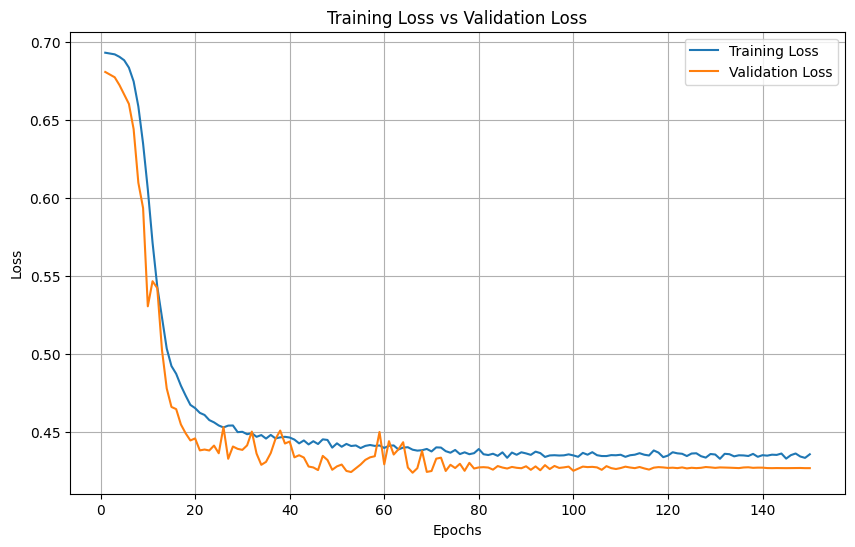

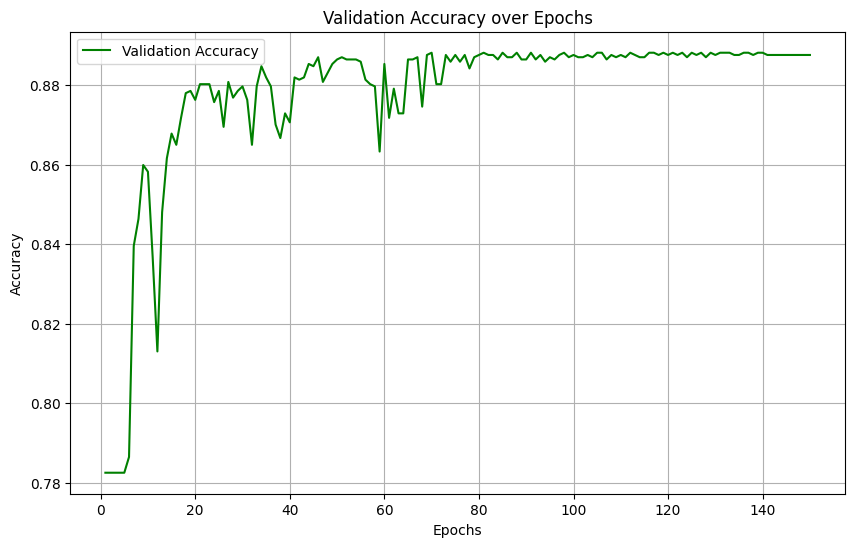

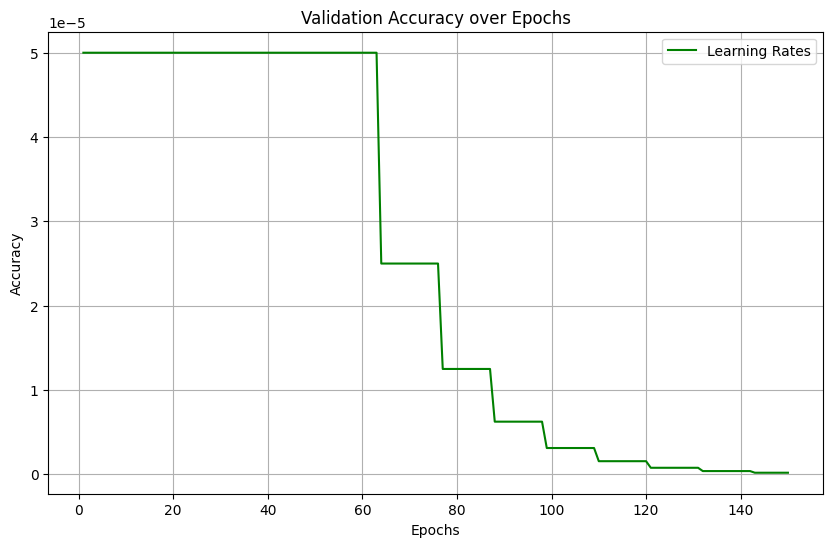

Model for bin 24 saved to 3DCholesterolModels-5A_exp4/model_bin_24.pth
1925 is length of subset grid
Training on bin 25
Bin 25, Epoch 1/150, Train Loss: 0.6934, Validation Loss: 0.7036, Validation Accuracy: 0.2175, Grad Norm: 0.0768, LR: 0.000050
Bin 25, Epoch 11/150, Train Loss: 0.6617, Validation Loss: 0.5931, Validation Accuracy: 0.7853, Grad Norm: 1.2007, LR: 0.000050
Bin 25, Epoch 21/150, Train Loss: 0.4800, Validation Loss: 0.4782, Validation Accuracy: 0.8435, Grad Norm: 5.1249, LR: 0.000050
Bin 25, Epoch 31/150, Train Loss: 0.4614, Validation Loss: 0.4655, Validation Accuracy: 0.8531, Grad Norm: 2.9120, LR: 0.000050
Bin 25, Epoch 41/150, Train Loss: 0.4524, Validation Loss: 0.4291, Validation Accuracy: 0.8847, Grad Norm: 1.1532, LR: 0.000050
Bin 25, Epoch 51/150, Train Loss: 0.4460, Validation Loss: 0.4267, Validation Accuracy: 0.8870, Grad Norm: 0.4062, LR: 0.000050
Bin 25, Epoch 61/150, Train Loss: 0.4439, Validation Loss: 0.4252, Validation Accuracy: 0.8893, Grad Norm: 4.8197

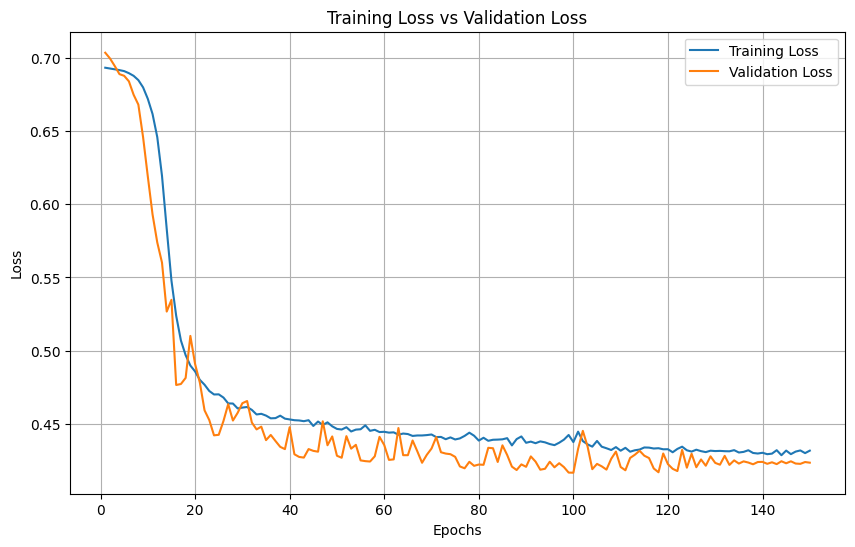

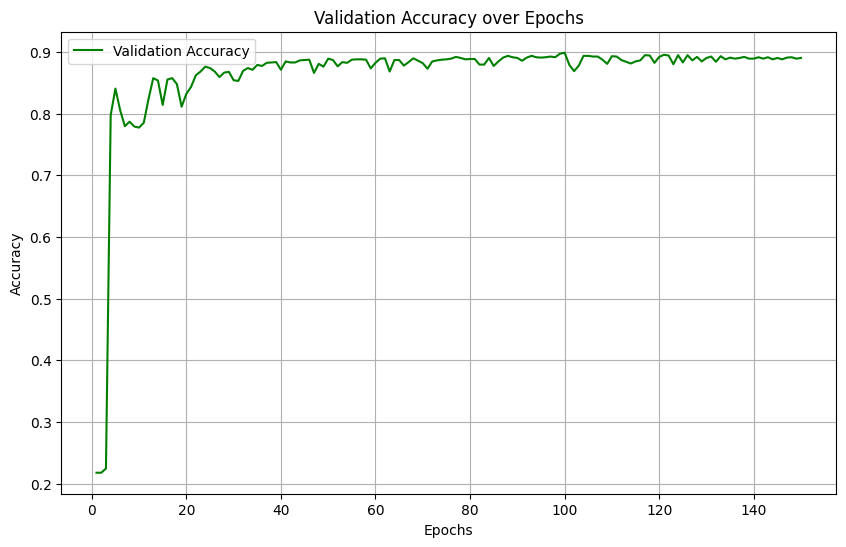

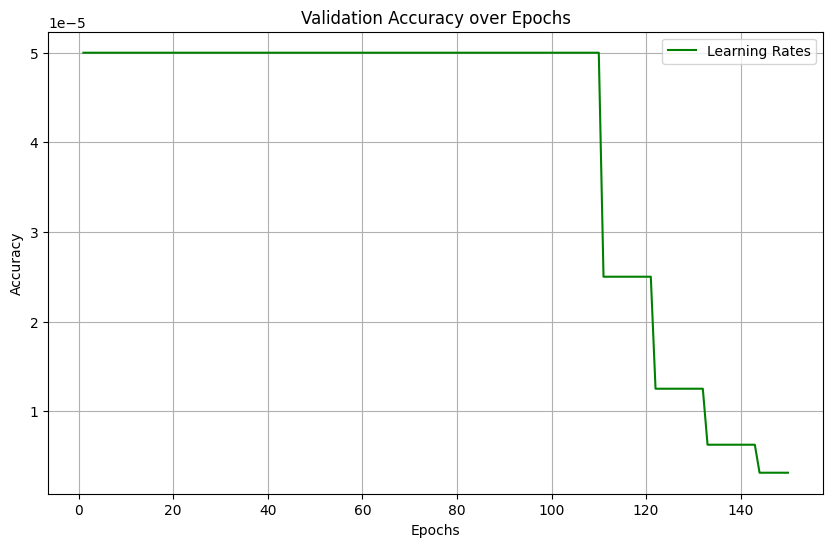

Model for bin 25 saved to 3DCholesterolModels-5A_exp4/model_bin_25.pth
1925 is length of subset grid
Training on bin 26
Bin 26, Epoch 1/150, Train Loss: 0.6931, Validation Loss: 0.6966, Validation Accuracy: 0.2175, Grad Norm: 0.1218, LR: 0.000050
Bin 26, Epoch 11/150, Train Loss: 0.6193, Validation Loss: 0.5560, Validation Accuracy: 0.8492, Grad Norm: 2.2790, LR: 0.000050
Bin 26, Epoch 21/150, Train Loss: 0.4784, Validation Loss: 0.4445, Validation Accuracy: 0.8684, Grad Norm: 3.9111, LR: 0.000050
Bin 26, Epoch 31/150, Train Loss: 0.4602, Validation Loss: 0.4427, Validation Accuracy: 0.8712, Grad Norm: 1.0106, LR: 0.000050
Bin 26, Epoch 41/150, Train Loss: 0.4494, Validation Loss: 0.4319, Validation Accuracy: 0.8819, Grad Norm: 2.1330, LR: 0.000050
Bin 26, Epoch 51/150, Train Loss: 0.4469, Validation Loss: 0.4286, Validation Accuracy: 0.8853, Grad Norm: 3.1956, LR: 0.000050
Bin 26, Epoch 61/150, Train Loss: 0.4442, Validation Loss: 0.4308, Validation Accuracy: 0.8831, Grad Norm: 2.5350

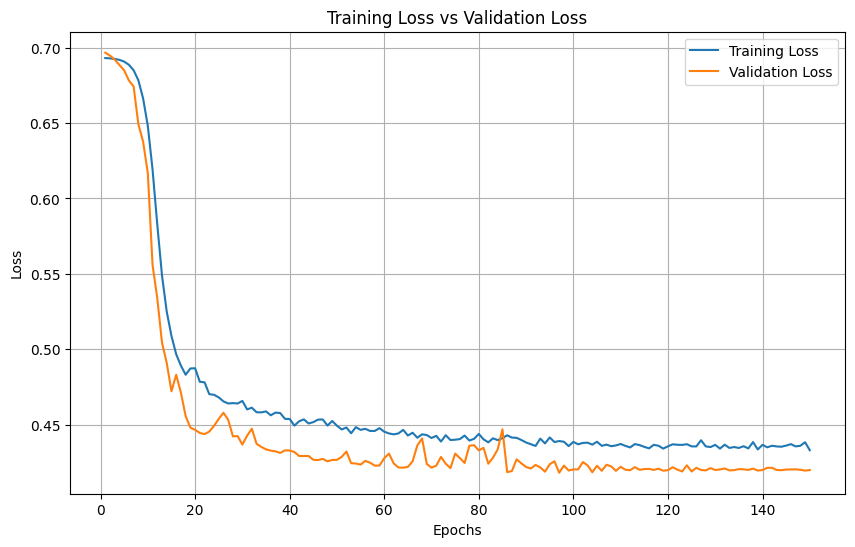

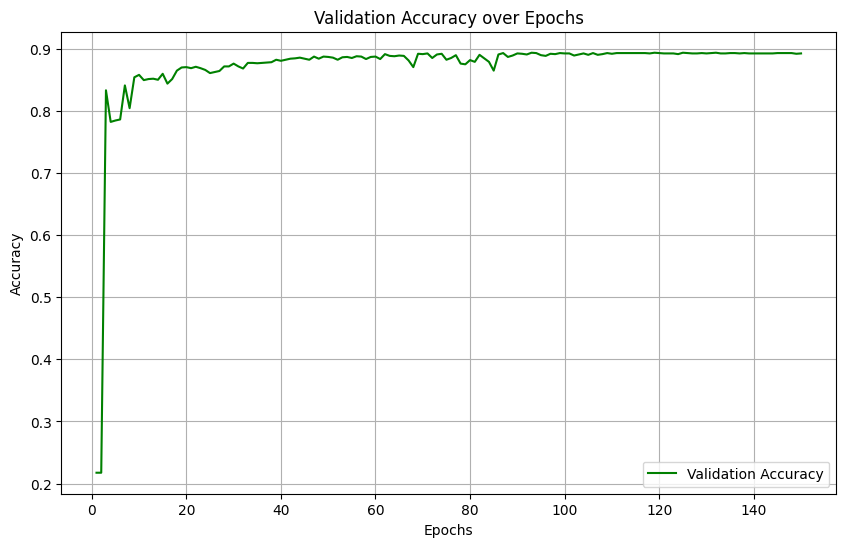

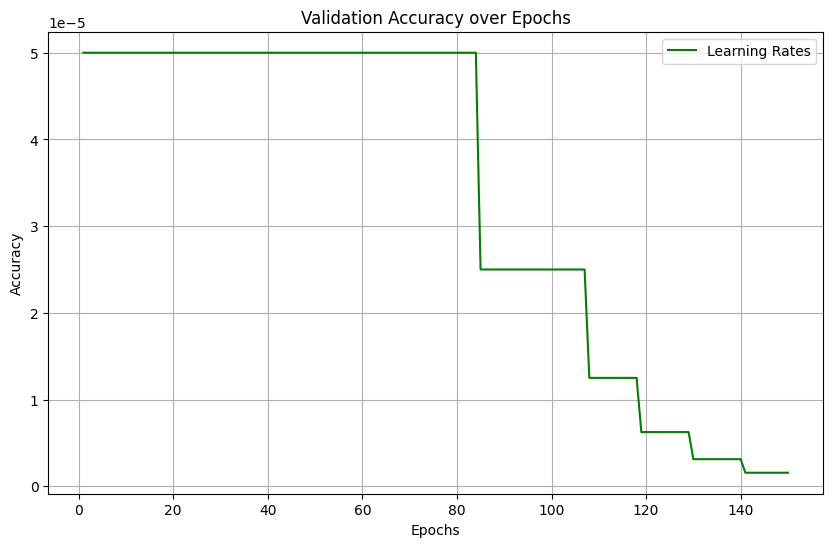

Model for bin 26 saved to 3DCholesterolModels-5A_exp4/model_bin_26.pth
1925 is length of subset grid
Training on bin 27
Bin 27, Epoch 1/150, Train Loss: 0.6930, Validation Loss: 0.6897, Validation Accuracy: 0.7825, Grad Norm: 0.0301, LR: 0.000050
Bin 27, Epoch 11/150, Train Loss: 0.5747, Validation Loss: 0.5338, Validation Accuracy: 0.8463, Grad Norm: 0.7771, LR: 0.000050
Bin 27, Epoch 21/150, Train Loss: 0.4634, Validation Loss: 0.4584, Validation Accuracy: 0.8638, Grad Norm: 1.0317, LR: 0.000050
Bin 27, Epoch 31/150, Train Loss: 0.4517, Validation Loss: 0.4483, Validation Accuracy: 0.8672, Grad Norm: 1.8596, LR: 0.000050
Bin 27, Epoch 41/150, Train Loss: 0.4491, Validation Loss: 0.4420, Validation Accuracy: 0.8718, Grad Norm: 4.9643, LR: 0.000050
Bin 27, Epoch 51/150, Train Loss: 0.4439, Validation Loss: 0.4280, Validation Accuracy: 0.8864, Grad Norm: 5.8821, LR: 0.000050
Bin 27, Epoch 61/150, Train Loss: 0.4407, Validation Loss: 0.4222, Validation Accuracy: 0.8898, Grad Norm: 1.6300

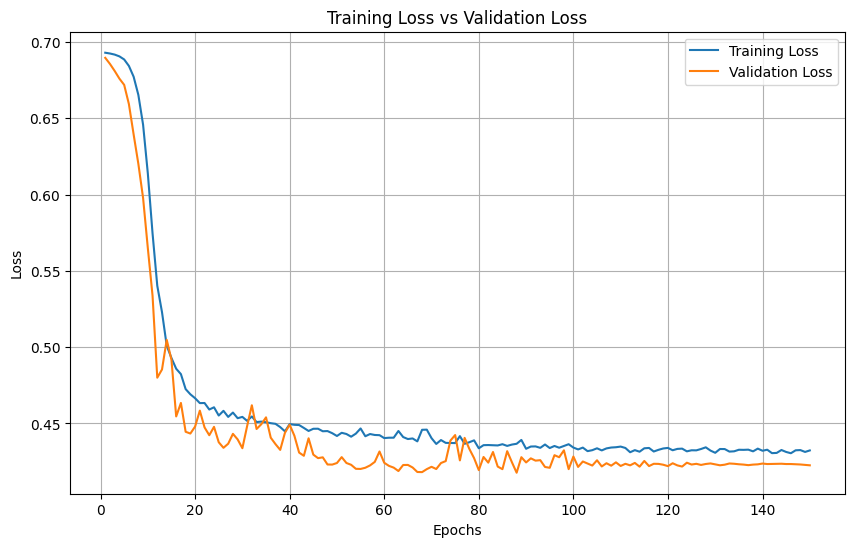

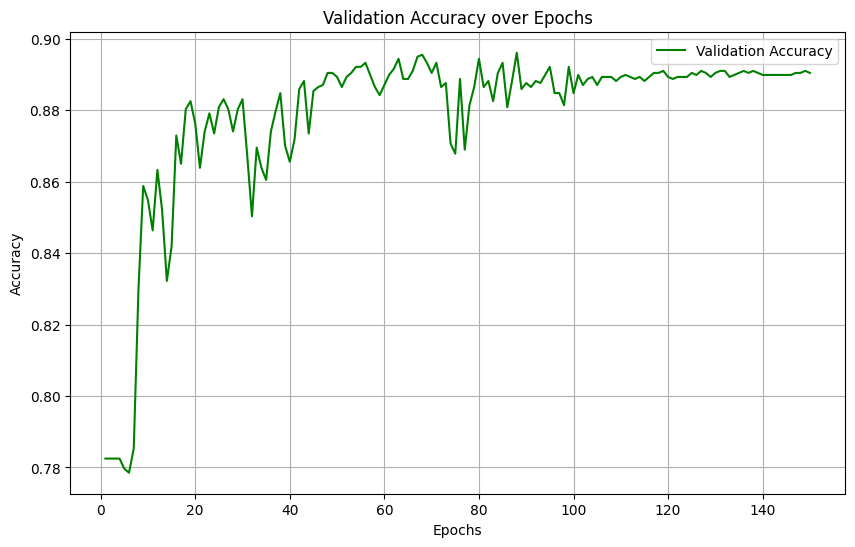

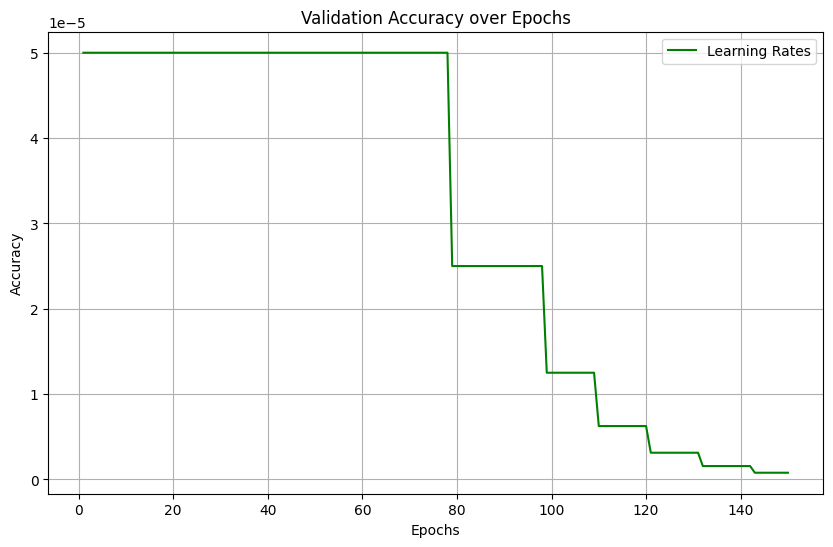

Model for bin 27 saved to 3DCholesterolModels-5A_exp4/model_bin_27.pth
1925 is length of subset grid
Training on bin 28
Bin 28, Epoch 1/150, Train Loss: 0.6931, Validation Loss: 0.6920, Validation Accuracy: 0.7825, Grad Norm: 0.0280, LR: 0.000050
Bin 28, Epoch 11/150, Train Loss: 0.6463, Validation Loss: 0.5895, Validation Accuracy: 0.8458, Grad Norm: 0.7790, LR: 0.000050
Bin 28, Epoch 21/150, Train Loss: 0.4776, Validation Loss: 0.4720, Validation Accuracy: 0.8525, Grad Norm: 6.1537, LR: 0.000050
Bin 28, Epoch 31/150, Train Loss: 0.4574, Validation Loss: 0.4392, Validation Accuracy: 0.8723, Grad Norm: 2.0366, LR: 0.000050
Bin 28, Epoch 41/150, Train Loss: 0.4504, Validation Loss: 0.4334, Validation Accuracy: 0.8791, Grad Norm: 1.9789, LR: 0.000050
Bin 28, Epoch 51/150, Train Loss: 0.4435, Validation Loss: 0.4279, Validation Accuracy: 0.8859, Grad Norm: 6.2248, LR: 0.000050
Bin 28, Epoch 61/150, Train Loss: 0.4444, Validation Loss: 0.4276, Validation Accuracy: 0.8870, Grad Norm: 2.4213

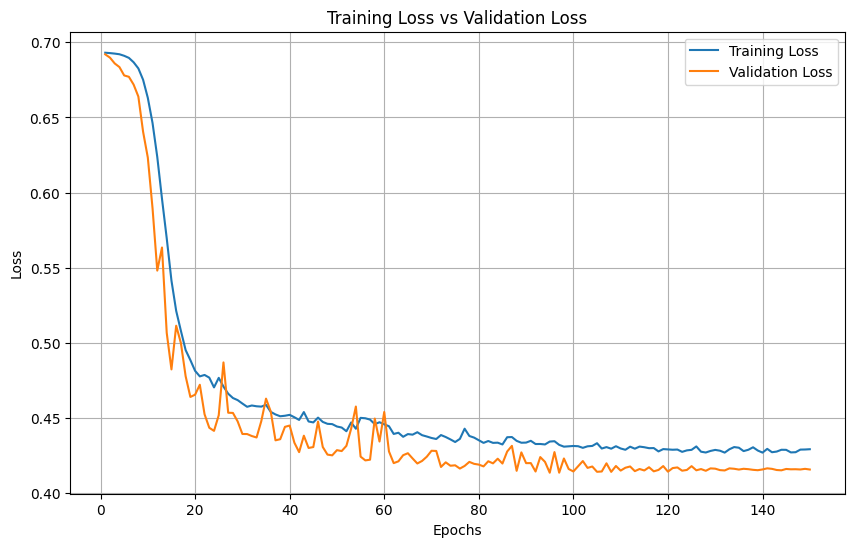

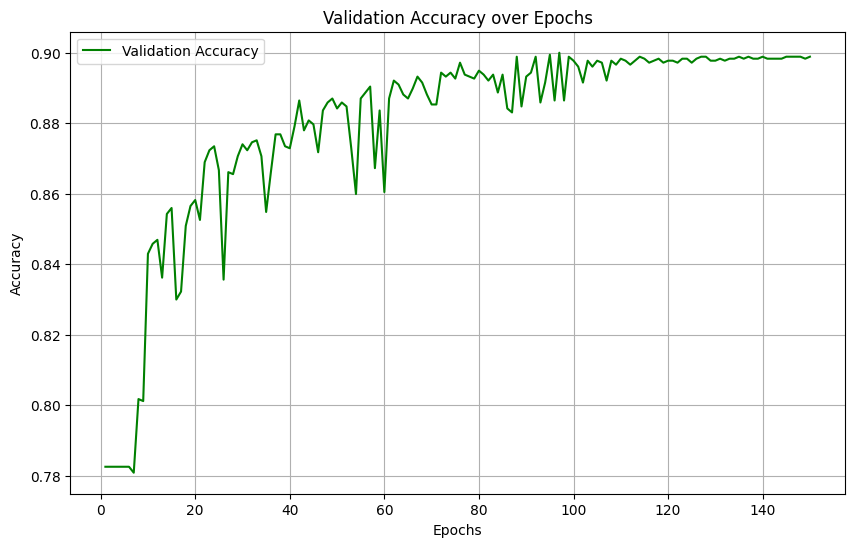

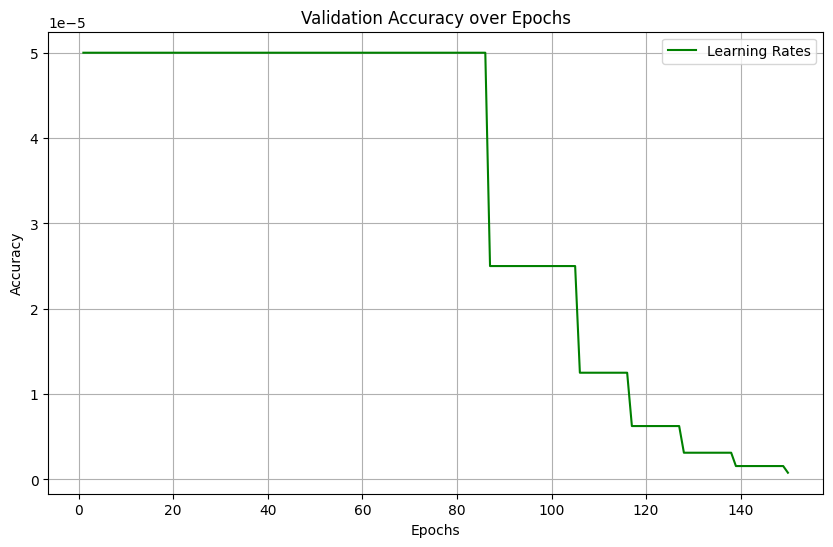

Model for bin 28 saved to 3DCholesterolModels-5A_exp4/model_bin_28.pth
1925 is length of subset grid
Training on bin 29
Bin 29, Epoch 1/150, Train Loss: 0.6936, Validation Loss: 0.6787, Validation Accuracy: 0.7825, Grad Norm: 0.1057, LR: 0.000050
Bin 29, Epoch 11/150, Train Loss: 0.6414, Validation Loss: 0.5995, Validation Accuracy: 0.8503, Grad Norm: 0.9224, LR: 0.000050
Bin 29, Epoch 21/150, Train Loss: 0.4772, Validation Loss: 0.4693, Validation Accuracy: 0.8508, Grad Norm: 6.3099, LR: 0.000050
Bin 29, Epoch 31/150, Train Loss: 0.4600, Validation Loss: 0.4839, Validation Accuracy: 0.8322, Grad Norm: 6.2212, LR: 0.000050
Bin 29, Epoch 41/150, Train Loss: 0.4476, Validation Loss: 0.4502, Validation Accuracy: 0.8661, Grad Norm: 3.9069, LR: 0.000025
Bin 29, Epoch 51/150, Train Loss: 0.4472, Validation Loss: 0.4344, Validation Accuracy: 0.8780, Grad Norm: 0.7609, LR: 0.000025
Bin 29, Epoch 61/150, Train Loss: 0.4425, Validation Loss: 0.4333, Validation Accuracy: 0.8808, Grad Norm: 0.7631

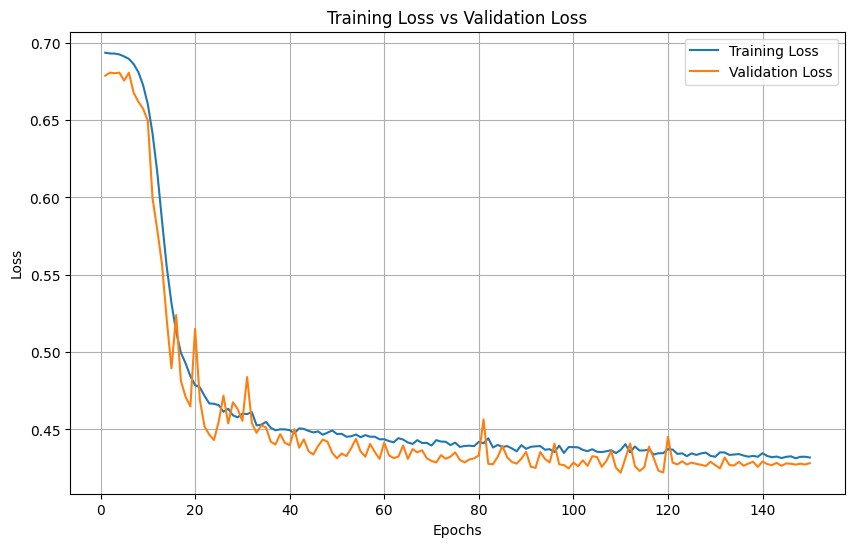

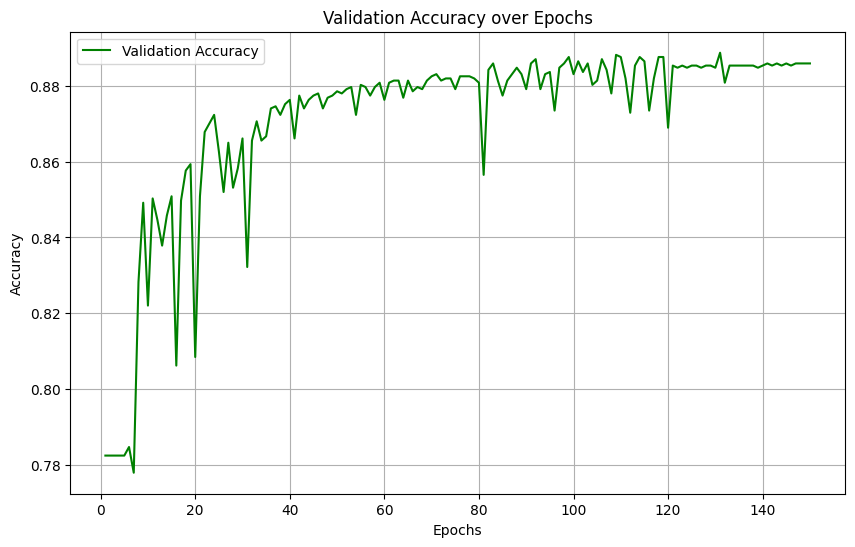

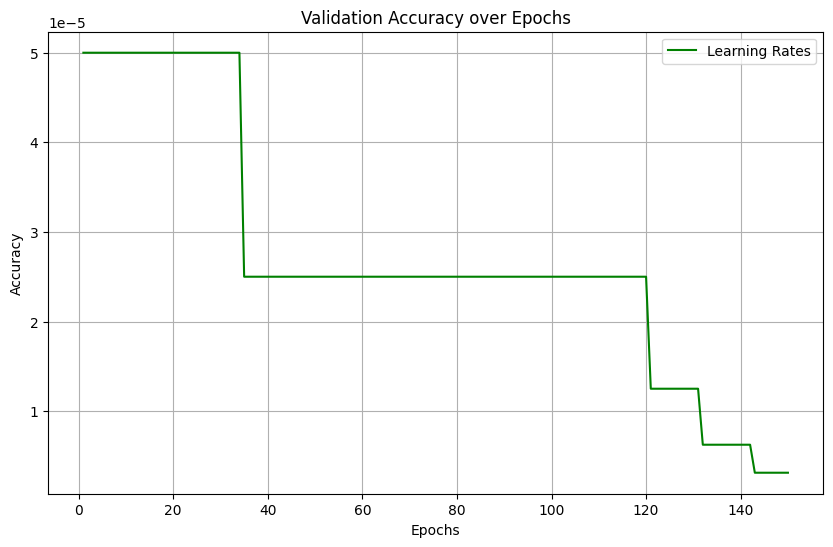

Model for bin 29 saved to 3DCholesterolModels-5A_exp4/model_bin_29.pth
1925 is length of subset grid
Training on bin 30
Bin 30, Epoch 1/150, Train Loss: 0.6931, Validation Loss: 0.6998, Validation Accuracy: 0.2175, Grad Norm: 0.1069, LR: 0.000050
Bin 30, Epoch 11/150, Train Loss: 0.6439, Validation Loss: 0.5732, Validation Accuracy: 0.8299, Grad Norm: 2.1539, LR: 0.000050
Bin 30, Epoch 21/150, Train Loss: 0.4724, Validation Loss: 0.4476, Validation Accuracy: 0.8689, Grad Norm: 3.2904, LR: 0.000050
Bin 30, Epoch 31/150, Train Loss: 0.4535, Validation Loss: 0.4347, Validation Accuracy: 0.8763, Grad Norm: 2.2258, LR: 0.000050
Bin 30, Epoch 41/150, Train Loss: 0.4500, Validation Loss: 0.4355, Validation Accuracy: 0.8791, Grad Norm: 6.1993, LR: 0.000050
Bin 30, Epoch 51/150, Train Loss: 0.4468, Validation Loss: 0.4480, Validation Accuracy: 0.8655, Grad Norm: 6.2092, LR: 0.000050
Bin 30, Epoch 61/150, Train Loss: 0.4397, Validation Loss: 0.4253, Validation Accuracy: 0.8881, Grad Norm: 1.7315

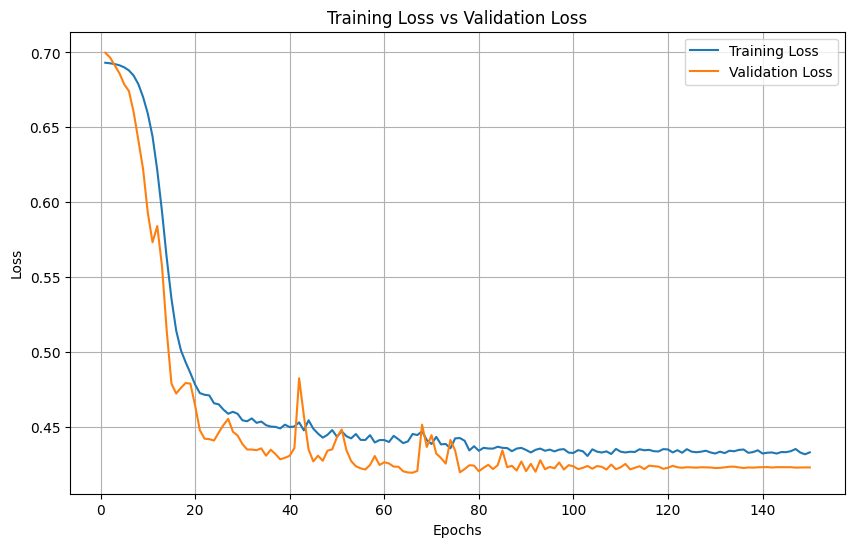

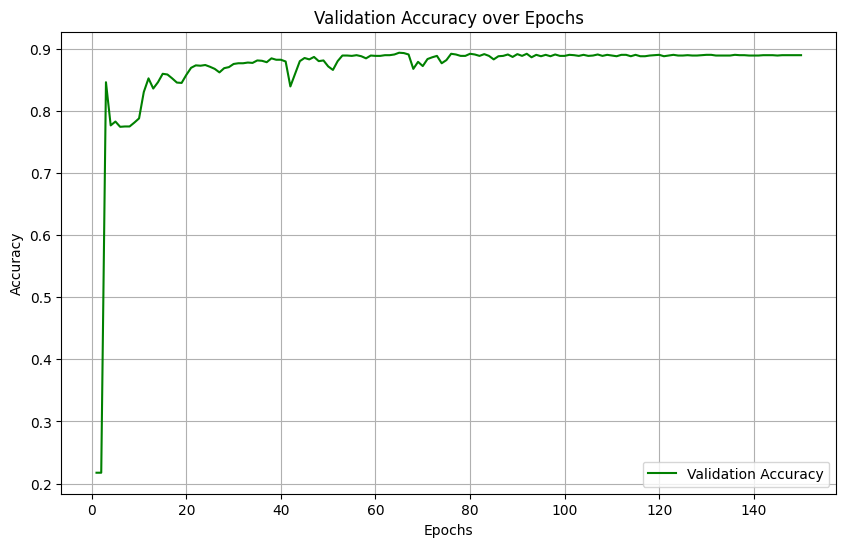

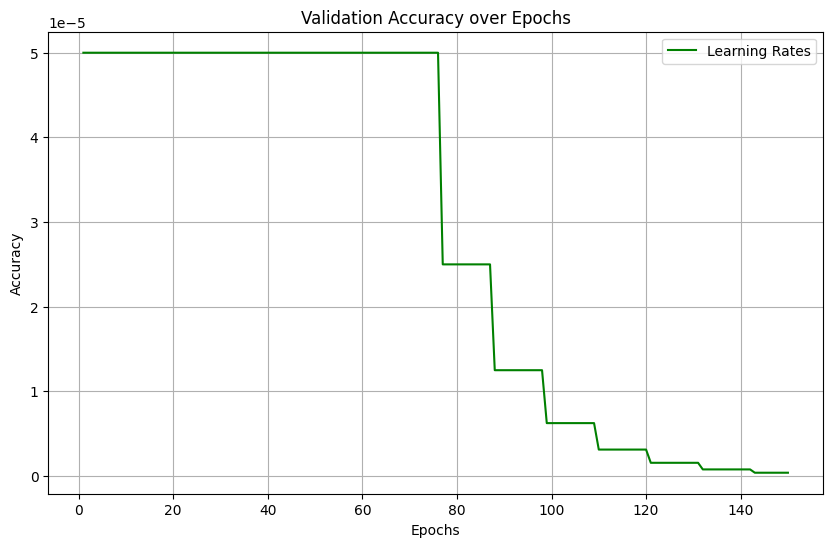

Model for bin 30 saved to 3DCholesterolModels-5A_exp4/model_bin_30.pth
1925 is length of subset grid
Training on bin 31
Bin 31, Epoch 1/150, Train Loss: 0.6930, Validation Loss: 0.6939, Validation Accuracy: 0.2175, Grad Norm: 0.0507, LR: 0.000050
Bin 31, Epoch 11/150, Train Loss: 0.6142, Validation Loss: 0.6071, Validation Accuracy: 0.7870, Grad Norm: 2.0957, LR: 0.000050
Bin 31, Epoch 21/150, Train Loss: 0.4639, Validation Loss: 0.4777, Validation Accuracy: 0.8328, Grad Norm: 1.9201, LR: 0.000050
Bin 31, Epoch 31/150, Train Loss: 0.4506, Validation Loss: 0.4402, Validation Accuracy: 0.8718, Grad Norm: 4.2081, LR: 0.000050
Bin 31, Epoch 41/150, Train Loss: 0.4467, Validation Loss: 0.4338, Validation Accuracy: 0.8797, Grad Norm: 4.5685, LR: 0.000050
Bin 31, Epoch 51/150, Train Loss: 0.4375, Validation Loss: 0.4290, Validation Accuracy: 0.8859, Grad Norm: 0.9631, LR: 0.000050
Bin 31, Epoch 61/150, Train Loss: 0.4359, Validation Loss: 0.4343, Validation Accuracy: 0.8842, Grad Norm: 3.6951

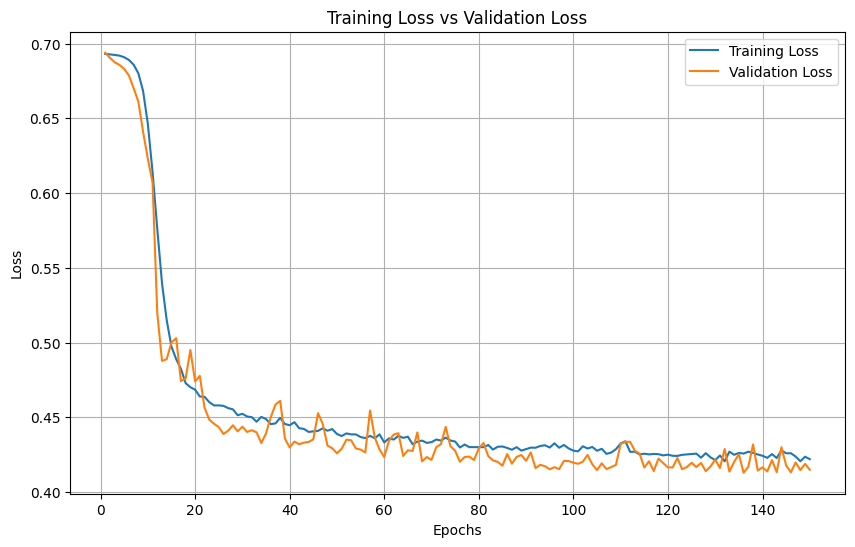

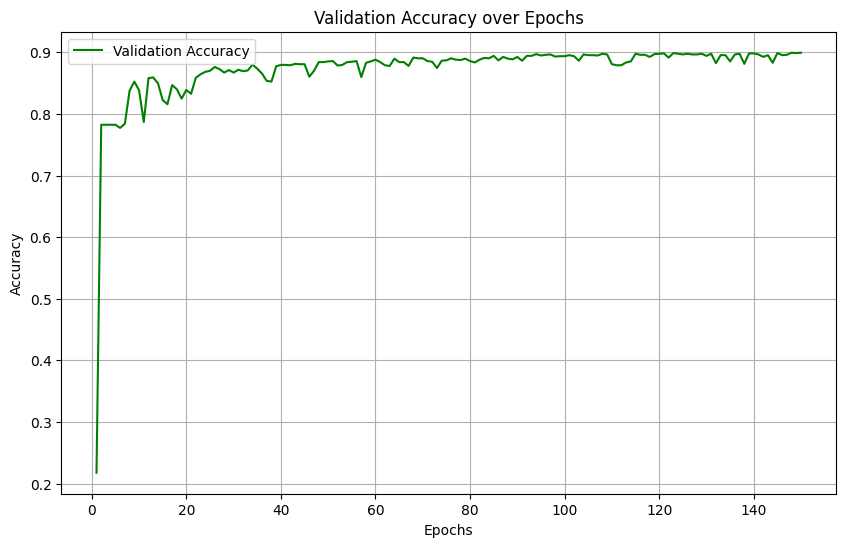

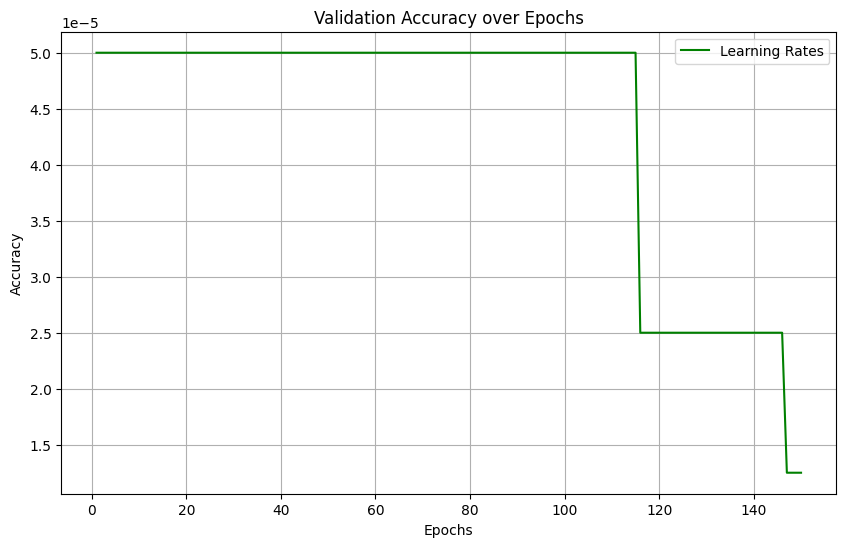

Model for bin 31 saved to 3DCholesterolModels-5A_exp4/model_bin_31.pth
1925 is length of subset grid
Training on bin 32
Bin 32, Epoch 1/150, Train Loss: 0.6931, Validation Loss: 0.6847, Validation Accuracy: 0.7825, Grad Norm: 0.0180, LR: 0.000050
Bin 32, Epoch 11/150, Train Loss: 0.5976, Validation Loss: 0.5555, Validation Accuracy: 0.8492, Grad Norm: 5.9225, LR: 0.000050
Bin 32, Epoch 21/150, Train Loss: 0.4695, Validation Loss: 0.4690, Validation Accuracy: 0.8548, Grad Norm: 0.6467, LR: 0.000050
Bin 32, Epoch 31/150, Train Loss: 0.4526, Validation Loss: 0.4351, Validation Accuracy: 0.8819, Grad Norm: 4.3275, LR: 0.000050
Bin 32, Epoch 41/150, Train Loss: 0.4469, Validation Loss: 0.4415, Validation Accuracy: 0.8768, Grad Norm: 3.2522, LR: 0.000050
Bin 32, Epoch 51/150, Train Loss: 0.4424, Validation Loss: 0.4248, Validation Accuracy: 0.8887, Grad Norm: 0.2416, LR: 0.000050
Bin 32, Epoch 61/150, Train Loss: 0.4414, Validation Loss: 0.4311, Validation Accuracy: 0.8836, Grad Norm: 1.5843

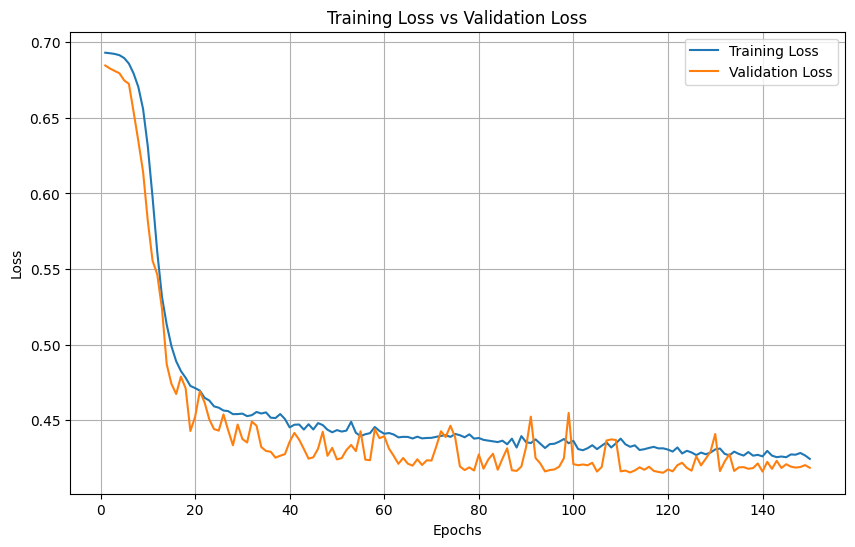

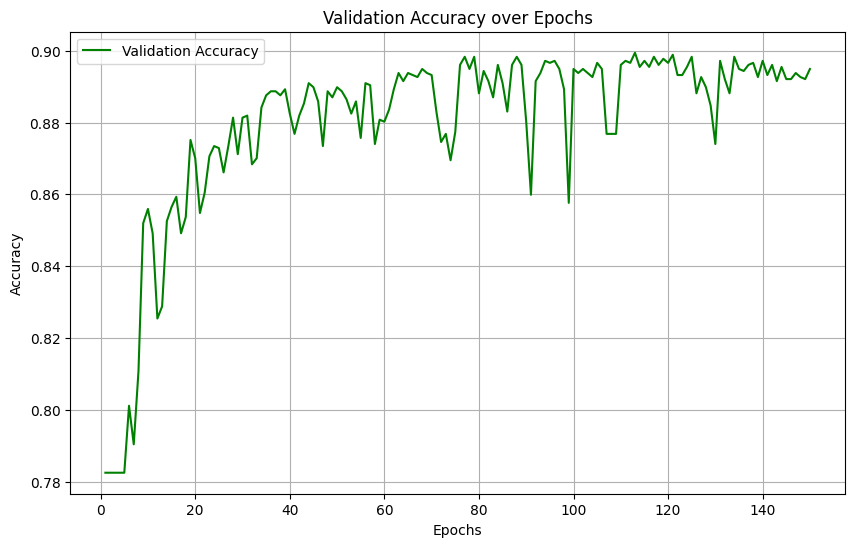

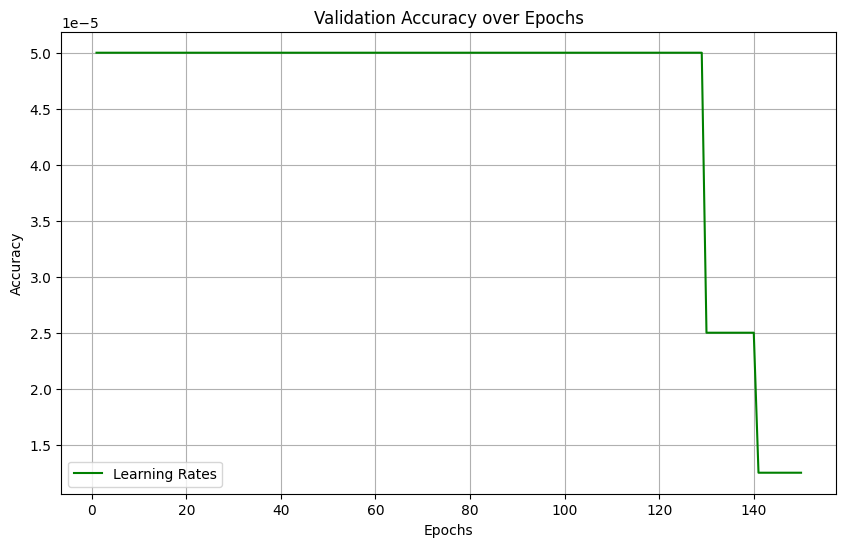

Model for bin 32 saved to 3DCholesterolModels-5A_exp4/model_bin_32.pth
1925 is length of subset grid
Training on bin 33
Bin 33, Epoch 1/150, Train Loss: 0.6939, Validation Loss: 0.6720, Validation Accuracy: 0.7825, Grad Norm: 0.0170, LR: 0.000050
Bin 33, Epoch 11/150, Train Loss: 0.6321, Validation Loss: 0.6153, Validation Accuracy: 0.8237, Grad Norm: 1.6400, LR: 0.000050
Bin 33, Epoch 21/150, Train Loss: 0.4698, Validation Loss: 0.4482, Validation Accuracy: 0.8712, Grad Norm: 2.7603, LR: 0.000050
Bin 33, Epoch 31/150, Train Loss: 0.4511, Validation Loss: 0.4377, Validation Accuracy: 0.8802, Grad Norm: 0.4273, LR: 0.000050
Bin 33, Epoch 41/150, Train Loss: 0.4553, Validation Loss: 0.4306, Validation Accuracy: 0.8853, Grad Norm: 5.7458, LR: 0.000050
Bin 33, Epoch 51/150, Train Loss: 0.4455, Validation Loss: 0.4415, Validation Accuracy: 0.8729, Grad Norm: 6.7398, LR: 0.000050
Bin 33, Epoch 61/150, Train Loss: 0.4385, Validation Loss: 0.4225, Validation Accuracy: 0.8904, Grad Norm: 2.3463

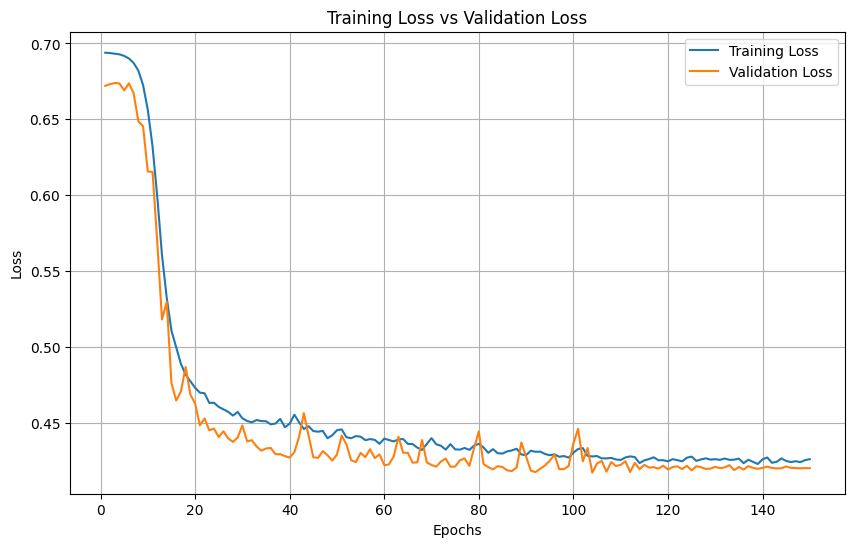

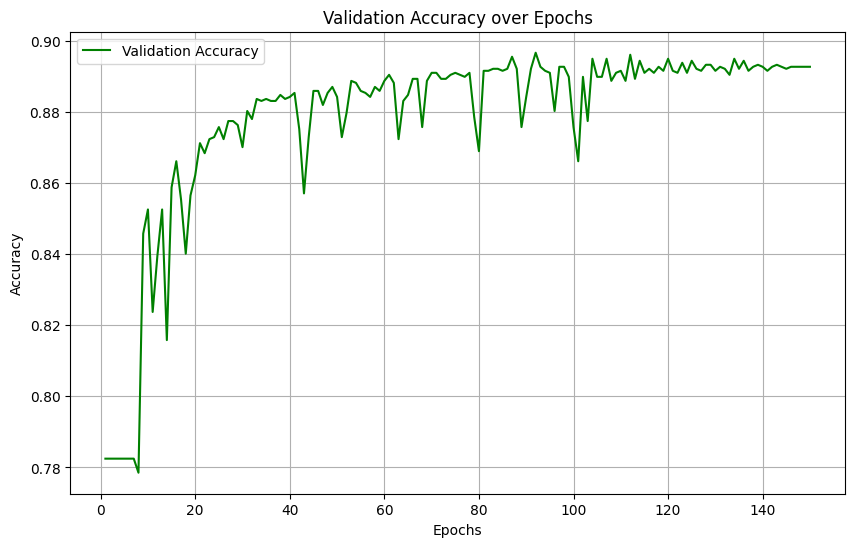

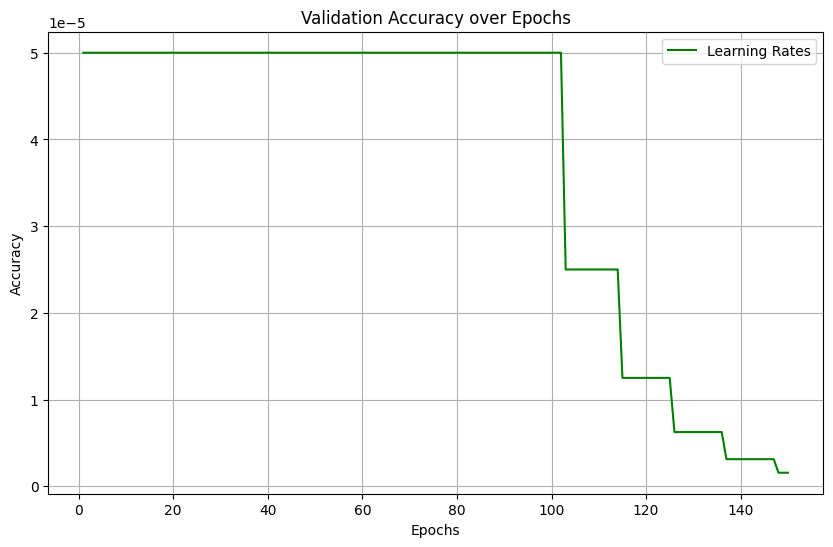

Model for bin 33 saved to 3DCholesterolModels-5A_exp4/model_bin_33.pth
1925 is length of subset grid
Training on bin 34
Bin 34, Epoch 1/150, Train Loss: 0.6932, Validation Loss: 0.6818, Validation Accuracy: 0.7825, Grad Norm: 0.0294, LR: 0.000050
Bin 34, Epoch 11/150, Train Loss: 0.6359, Validation Loss: 0.6084, Validation Accuracy: 0.8475, Grad Norm: 3.9808, LR: 0.000050
Bin 34, Epoch 21/150, Train Loss: 0.4784, Validation Loss: 0.4535, Validation Accuracy: 0.8678, Grad Norm: 1.7110, LR: 0.000050
Bin 34, Epoch 31/150, Train Loss: 0.4648, Validation Loss: 0.4381, Validation Accuracy: 0.8780, Grad Norm: 6.5353, LR: 0.000050
Bin 34, Epoch 41/150, Train Loss: 0.4588, Validation Loss: 0.4354, Validation Accuracy: 0.8808, Grad Norm: 4.0306, LR: 0.000050
Bin 34, Epoch 51/150, Train Loss: 0.4526, Validation Loss: 0.4361, Validation Accuracy: 0.8814, Grad Norm: 3.2639, LR: 0.000050
Bin 34, Epoch 61/150, Train Loss: 0.4456, Validation Loss: 0.4223, Validation Accuracy: 0.8921, Grad Norm: 0.7041

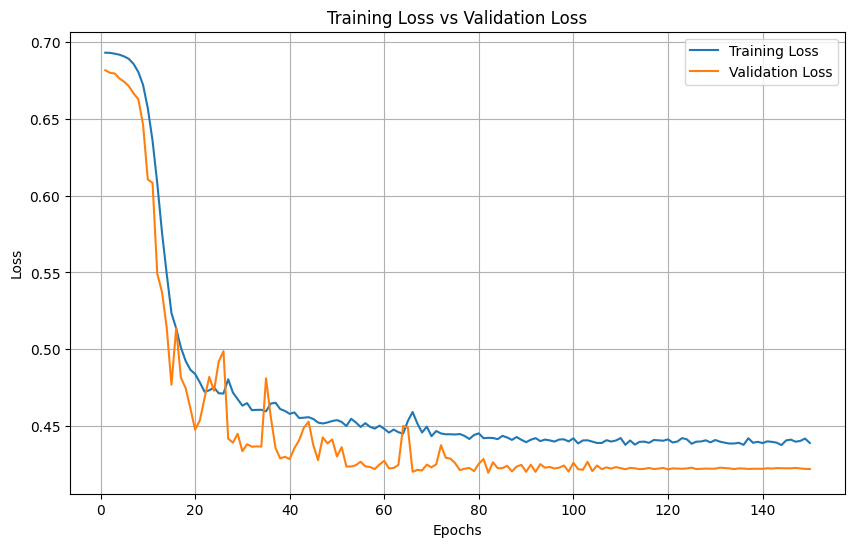

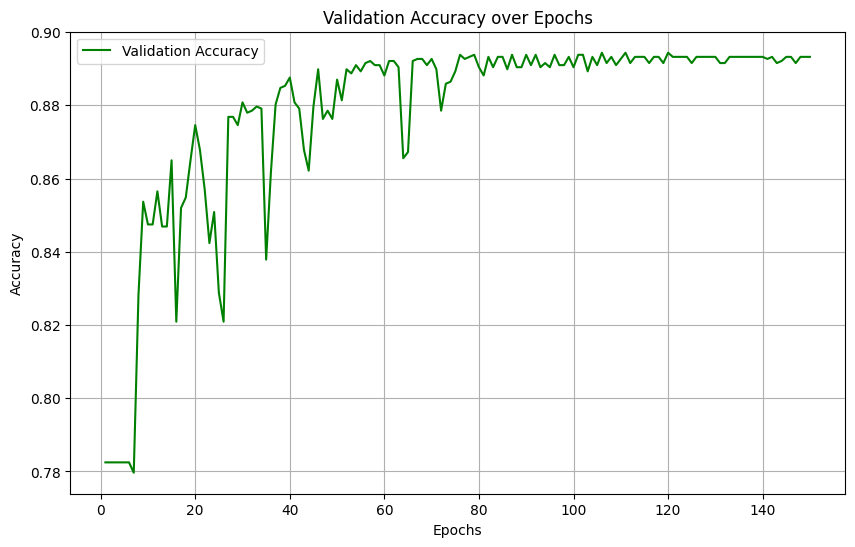

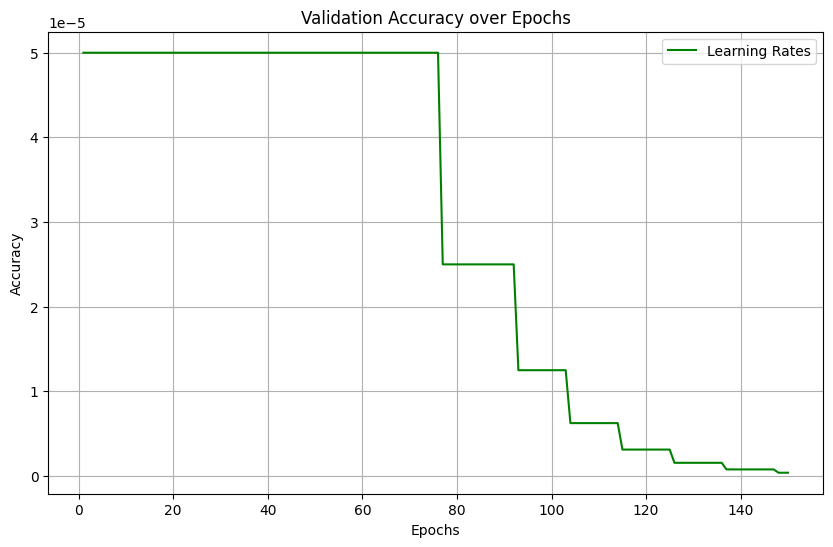

Model for bin 34 saved to 3DCholesterolModels-5A_exp4/model_bin_34.pth
1925 is length of subset grid
Training on bin 35
Bin 35, Epoch 1/150, Train Loss: 0.6934, Validation Loss: 0.7078, Validation Accuracy: 0.2175, Grad Norm: 0.0434, LR: 0.000050
Bin 35, Epoch 11/150, Train Loss: 0.6356, Validation Loss: 0.5601, Validation Accuracy: 0.8384, Grad Norm: 1.2130, LR: 0.000050
Bin 35, Epoch 21/150, Train Loss: 0.4630, Validation Loss: 0.4417, Validation Accuracy: 0.8723, Grad Norm: 2.1627, LR: 0.000050
Bin 35, Epoch 31/150, Train Loss: 0.4569, Validation Loss: 0.4306, Validation Accuracy: 0.8808, Grad Norm: 1.2059, LR: 0.000050
Bin 35, Epoch 41/150, Train Loss: 0.4533, Validation Loss: 0.4311, Validation Accuracy: 0.8825, Grad Norm: 0.6717, LR: 0.000050
Bin 35, Epoch 51/150, Train Loss: 0.4480, Validation Loss: 0.4340, Validation Accuracy: 0.8802, Grad Norm: 0.8909, LR: 0.000025
Bin 35, Epoch 61/150, Train Loss: 0.4448, Validation Loss: 0.4302, Validation Accuracy: 0.8859, Grad Norm: 0.5997

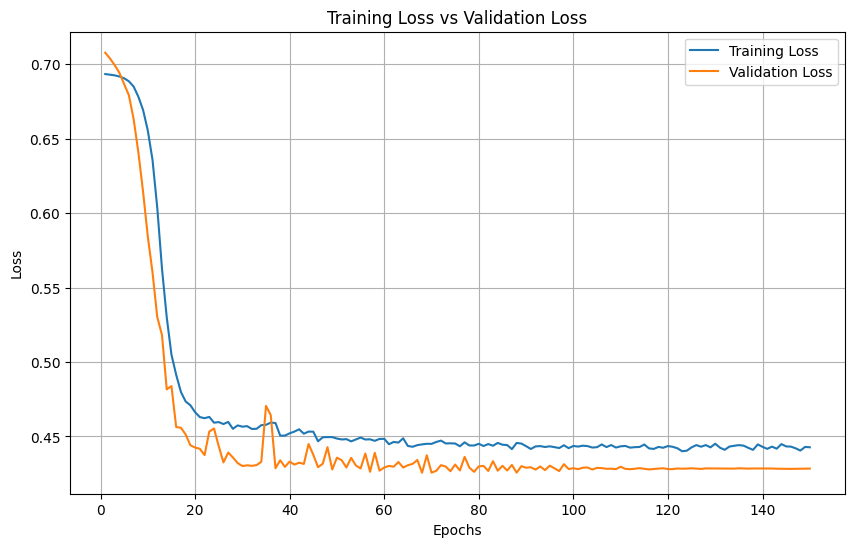

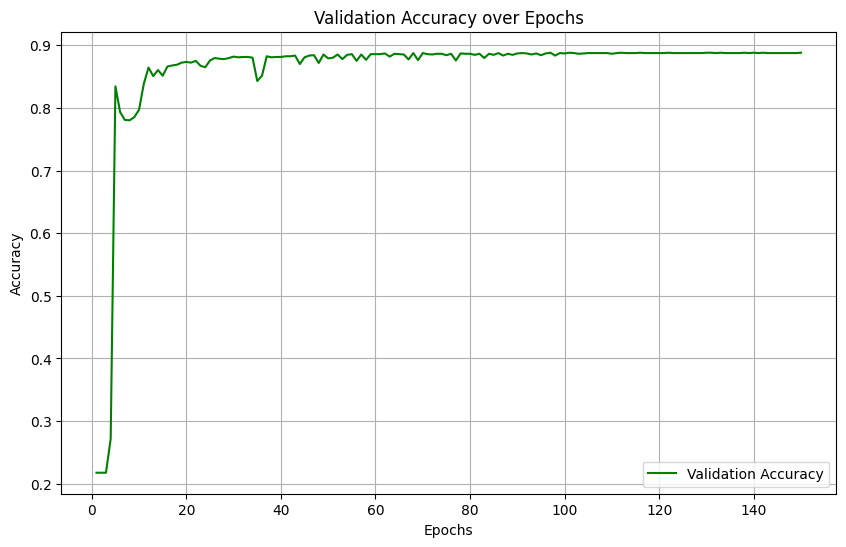

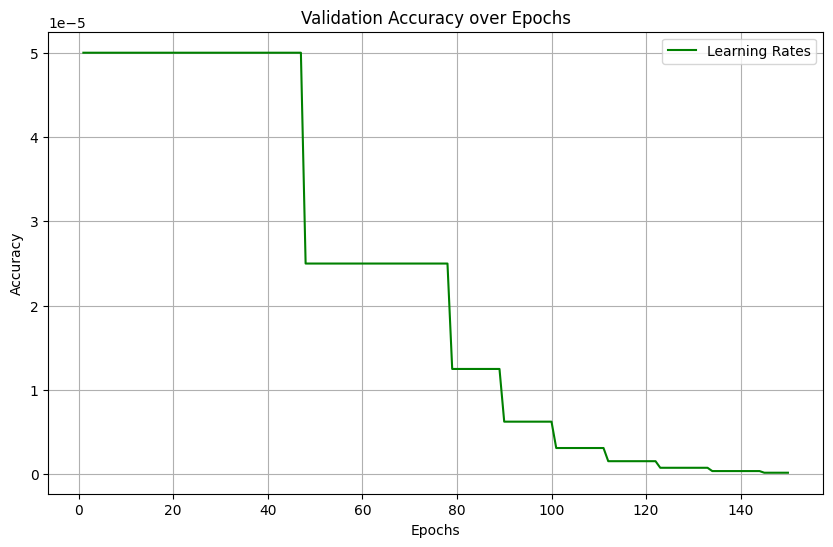

Model for bin 35 saved to 3DCholesterolModels-5A_exp4/model_bin_35.pth
1925 is length of subset grid
Training on bin 36
Bin 36, Epoch 1/150, Train Loss: 0.6930, Validation Loss: 0.6948, Validation Accuracy: 0.2175, Grad Norm: 0.0142, LR: 0.000050
Bin 36, Epoch 11/150, Train Loss: 0.6258, Validation Loss: 0.5786, Validation Accuracy: 0.8503, Grad Norm: 1.1831, LR: 0.000050
Bin 36, Epoch 21/150, Train Loss: 0.4718, Validation Loss: 0.4763, Validation Accuracy: 0.8463, Grad Norm: 5.3764, LR: 0.000050
Bin 36, Epoch 31/150, Train Loss: 0.4562, Validation Loss: 0.4725, Validation Accuracy: 0.8441, Grad Norm: 3.5903, LR: 0.000050
Bin 36, Epoch 41/150, Train Loss: 0.4474, Validation Loss: 0.4328, Validation Accuracy: 0.8797, Grad Norm: 3.0755, LR: 0.000050
Bin 36, Epoch 51/150, Train Loss: 0.4423, Validation Loss: 0.4437, Validation Accuracy: 0.8723, Grad Norm: 6.3459, LR: 0.000050
Bin 36, Epoch 61/150, Train Loss: 0.4410, Validation Loss: 0.4299, Validation Accuracy: 0.8831, Grad Norm: 4.1147

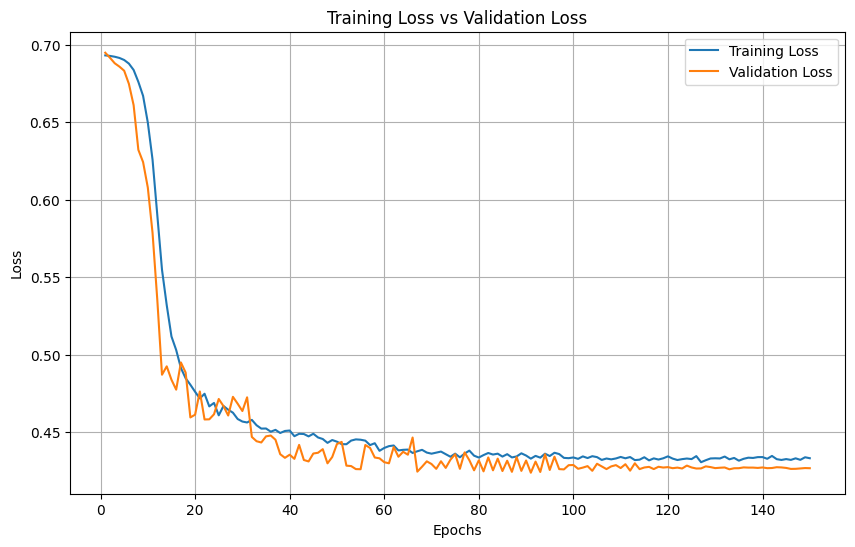

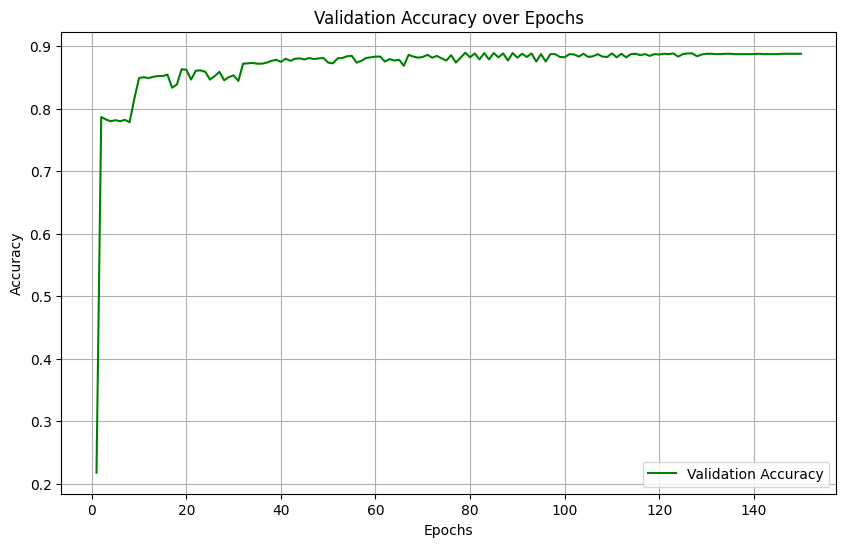

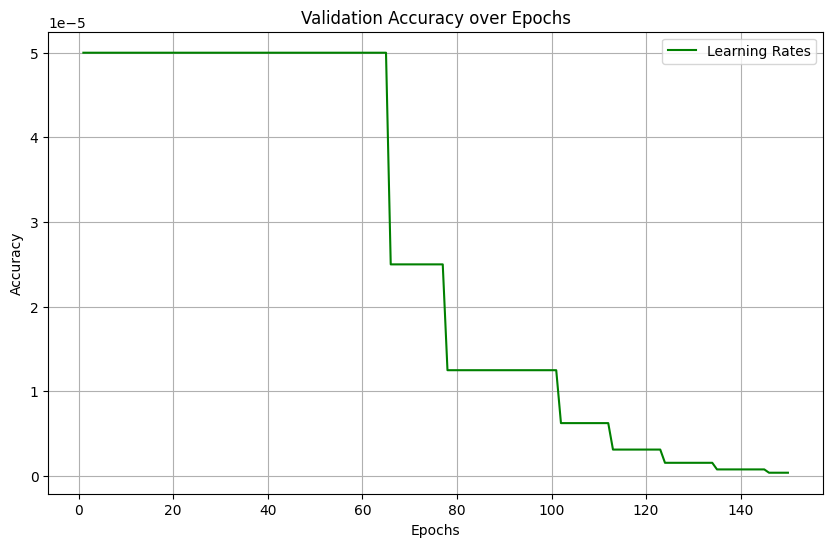

Model for bin 36 saved to 3DCholesterolModels-5A_exp4/model_bin_36.pth
1925 is length of subset grid
Training on bin 37
Bin 37, Epoch 1/150, Train Loss: 0.6930, Validation Loss: 0.6865, Validation Accuracy: 0.7825, Grad Norm: 0.0657, LR: 0.000050
Bin 37, Epoch 11/150, Train Loss: 0.5681, Validation Loss: 0.5240, Validation Accuracy: 0.8559, Grad Norm: 1.4023, LR: 0.000050
Bin 37, Epoch 21/150, Train Loss: 0.4582, Validation Loss: 0.4415, Validation Accuracy: 0.8763, Grad Norm: 1.5872, LR: 0.000050
Bin 37, Epoch 31/150, Train Loss: 0.4453, Validation Loss: 0.4243, Validation Accuracy: 0.8915, Grad Norm: 1.3372, LR: 0.000050
Bin 37, Epoch 41/150, Train Loss: 0.4414, Validation Loss: 0.4251, Validation Accuracy: 0.8904, Grad Norm: 0.4910, LR: 0.000050
Bin 37, Epoch 51/150, Train Loss: 0.4389, Validation Loss: 0.4174, Validation Accuracy: 0.8966, Grad Norm: 4.3981, LR: 0.000050
Bin 37, Epoch 61/150, Train Loss: 0.4380, Validation Loss: 0.4168, Validation Accuracy: 0.8955, Grad Norm: 2.8814

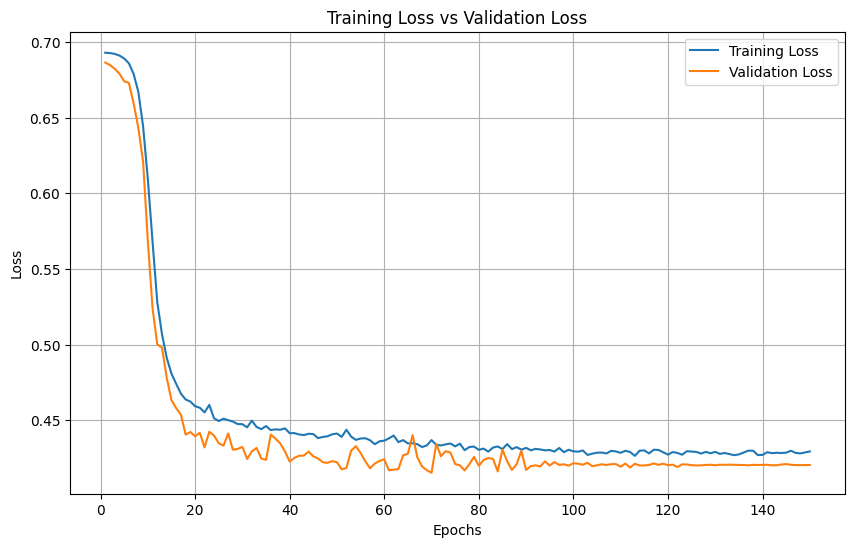

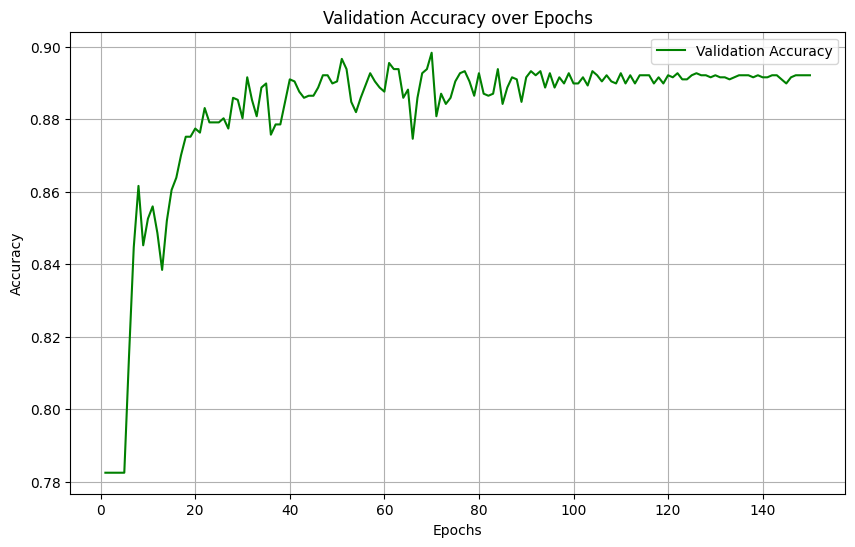

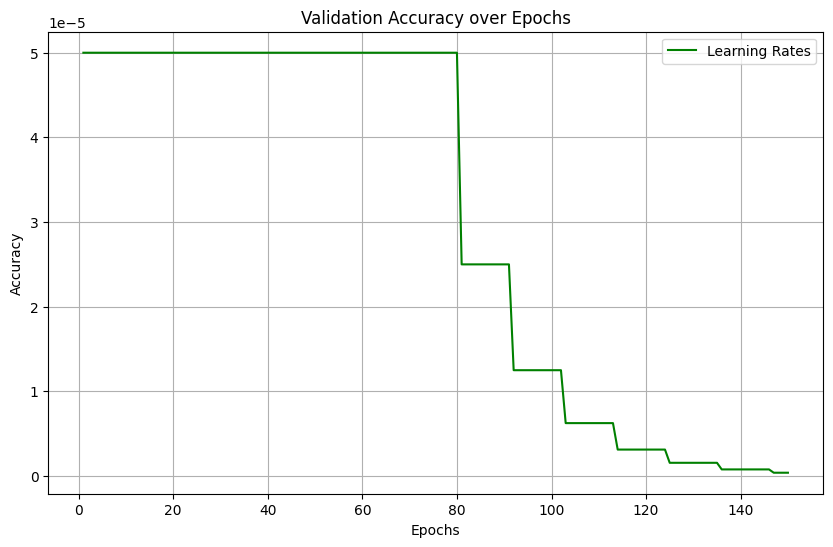

Model for bin 37 saved to 3DCholesterolModels-5A_exp4/model_bin_37.pth
1925 is length of subset grid
Training on bin 38
Bin 38, Epoch 1/150, Train Loss: 0.6937, Validation Loss: 0.6733, Validation Accuracy: 0.7825, Grad Norm: 0.0292, LR: 0.000050
Bin 38, Epoch 11/150, Train Loss: 0.5893, Validation Loss: 0.5609, Validation Accuracy: 0.8299, Grad Norm: 6.0221, LR: 0.000050
Bin 38, Epoch 21/150, Train Loss: 0.4729, Validation Loss: 0.4596, Validation Accuracy: 0.8605, Grad Norm: 0.3265, LR: 0.000050
Bin 38, Epoch 31/150, Train Loss: 0.4573, Validation Loss: 0.4465, Validation Accuracy: 0.8734, Grad Norm: 0.9514, LR: 0.000050
Bin 38, Epoch 41/150, Train Loss: 0.4507, Validation Loss: 0.4372, Validation Accuracy: 0.8774, Grad Norm: 2.5355, LR: 0.000050
Bin 38, Epoch 51/150, Train Loss: 0.4429, Validation Loss: 0.4259, Validation Accuracy: 0.8864, Grad Norm: 6.3836, LR: 0.000050
Bin 38, Epoch 61/150, Train Loss: 0.4410, Validation Loss: 0.4222, Validation Accuracy: 0.8898, Grad Norm: 6.3344

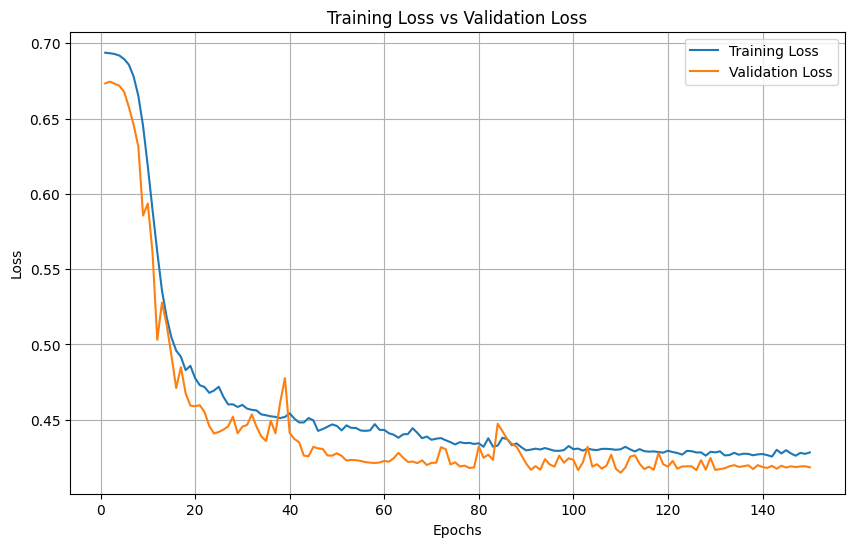

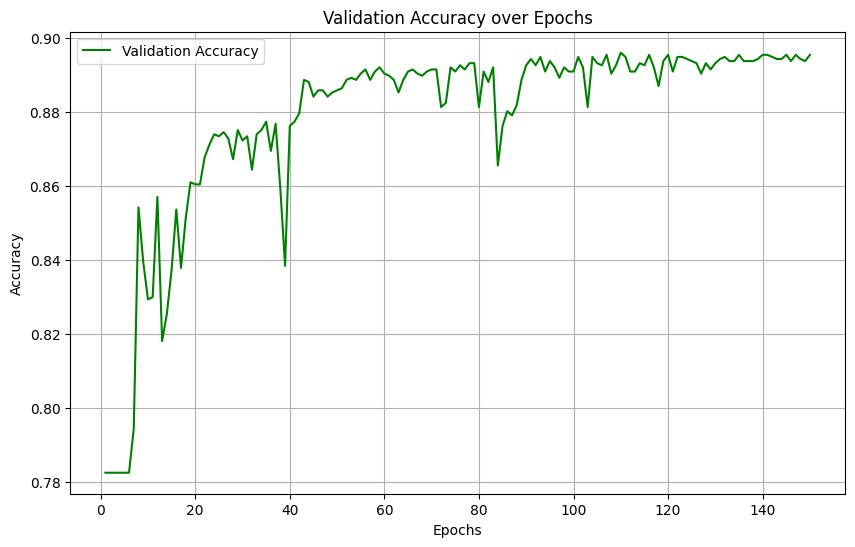

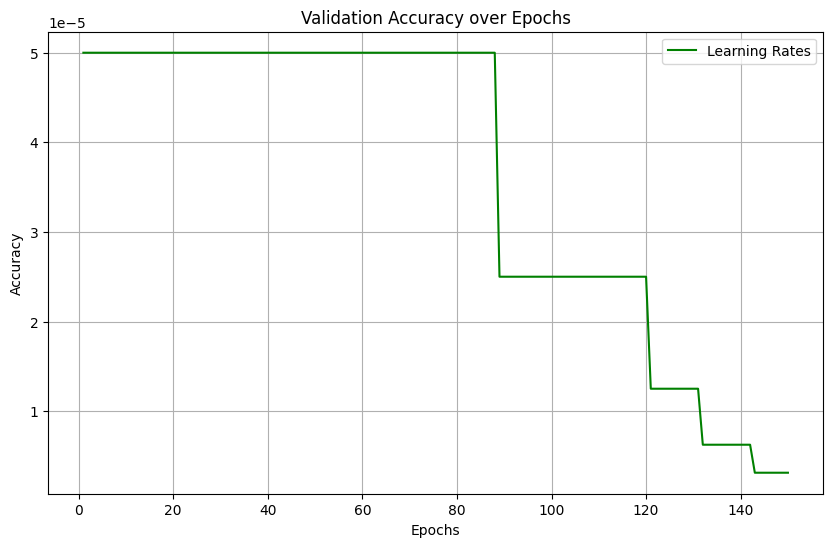

Model for bin 38 saved to 3DCholesterolModels-5A_exp4/model_bin_38.pth
1925 is length of subset grid
Training on bin 39
Bin 39, Epoch 1/150, Train Loss: 0.6930, Validation Loss: 0.6934, Validation Accuracy: 0.2503, Grad Norm: 0.0806, LR: 0.000050
Bin 39, Epoch 11/150, Train Loss: 0.6077, Validation Loss: 0.5517, Validation Accuracy: 0.8605, Grad Norm: 1.5901, LR: 0.000050
Bin 39, Epoch 21/150, Train Loss: 0.4777, Validation Loss: 0.4517, Validation Accuracy: 0.8706, Grad Norm: 1.2347, LR: 0.000050
Bin 39, Epoch 31/150, Train Loss: 0.4599, Validation Loss: 0.4478, Validation Accuracy: 0.8672, Grad Norm: 0.6493, LR: 0.000050
Bin 39, Epoch 41/150, Train Loss: 0.4537, Validation Loss: 0.4433, Validation Accuracy: 0.8768, Grad Norm: 0.9036, LR: 0.000050
Bin 39, Epoch 51/150, Train Loss: 0.4480, Validation Loss: 0.4344, Validation Accuracy: 0.8814, Grad Norm: 1.2339, LR: 0.000050
Bin 39, Epoch 61/150, Train Loss: 0.4433, Validation Loss: 0.4332, Validation Accuracy: 0.8825, Grad Norm: 0.9414

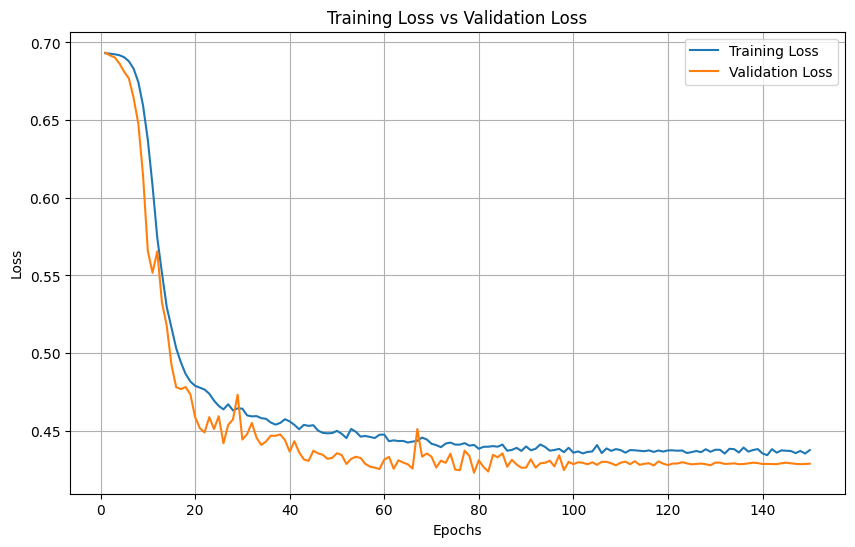

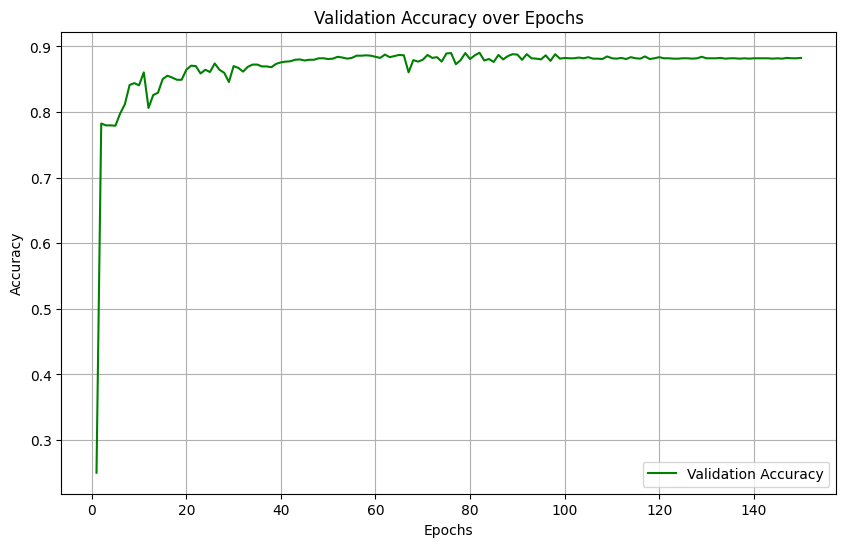

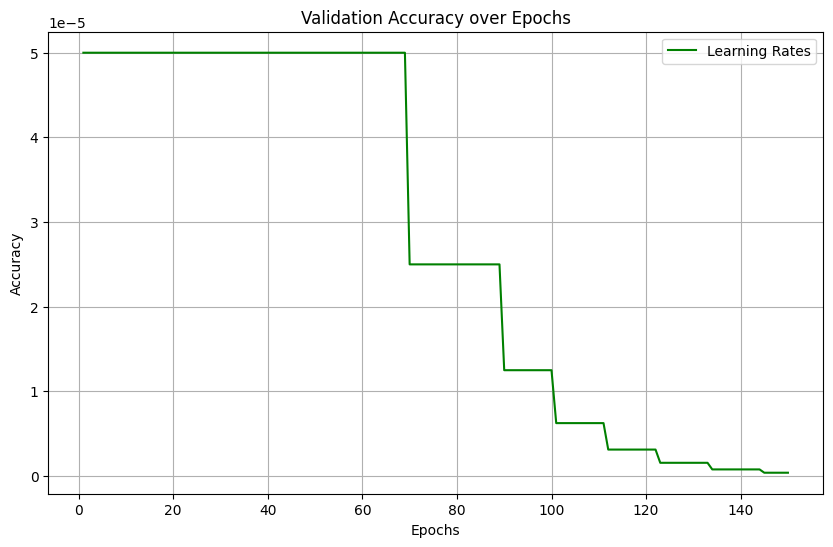

Model for bin 39 saved to 3DCholesterolModels-5A_exp4/model_bin_39.pth
1925 is length of subset grid
Training on bin 40
Bin 40, Epoch 1/150, Train Loss: 0.6931, Validation Loss: 0.6855, Validation Accuracy: 0.7825, Grad Norm: 0.0282, LR: 0.000050
Bin 40, Epoch 11/150, Train Loss: 0.6106, Validation Loss: 0.5605, Validation Accuracy: 0.8525, Grad Norm: 3.2257, LR: 0.000050
Bin 40, Epoch 21/150, Train Loss: 0.4654, Validation Loss: 0.4624, Validation Accuracy: 0.8559, Grad Norm: 1.8761, LR: 0.000050
Bin 40, Epoch 31/150, Train Loss: 0.4563, Validation Loss: 0.4436, Validation Accuracy: 0.8734, Grad Norm: 4.5865, LR: 0.000050
Bin 40, Epoch 41/150, Train Loss: 0.4456, Validation Loss: 0.4401, Validation Accuracy: 0.8746, Grad Norm: 1.5517, LR: 0.000050
Bin 40, Epoch 51/150, Train Loss: 0.4414, Validation Loss: 0.4261, Validation Accuracy: 0.8870, Grad Norm: 2.2566, LR: 0.000050
Bin 40, Epoch 61/150, Train Loss: 0.4392, Validation Loss: 0.4293, Validation Accuracy: 0.8819, Grad Norm: 3.0175

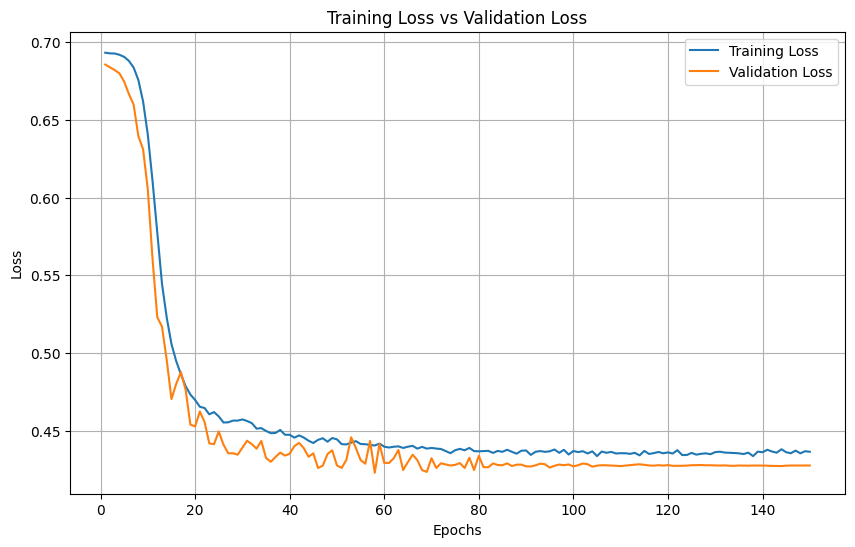

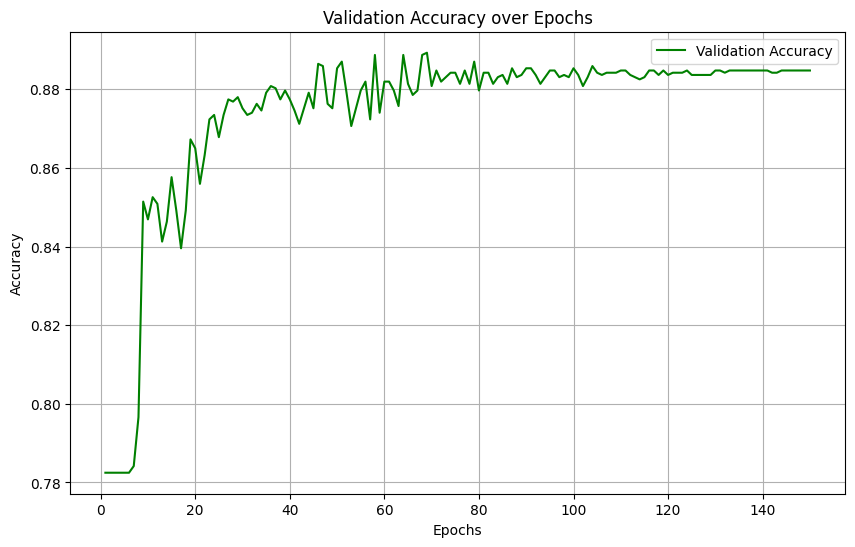

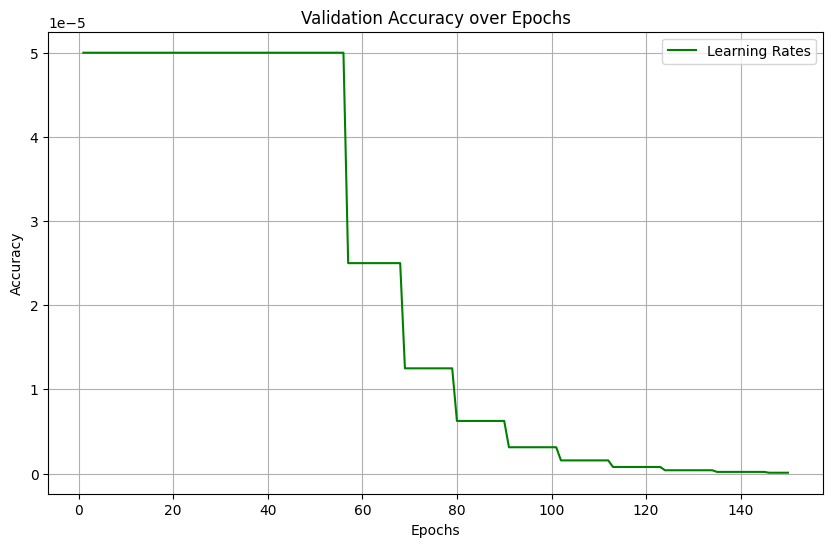

Model for bin 40 saved to 3DCholesterolModels-5A_exp4/model_bin_40.pth
1925 is length of subset grid
Training on bin 41
Bin 41, Epoch 1/150, Train Loss: 0.6930, Validation Loss: 0.6933, Validation Accuracy: 0.3390, Grad Norm: 0.0176, LR: 0.000050
Bin 41, Epoch 11/150, Train Loss: 0.5577, Validation Loss: 0.5242, Validation Accuracy: 0.8395, Grad Norm: 4.8703, LR: 0.000050
Bin 41, Epoch 21/150, Train Loss: 0.4563, Validation Loss: 0.4489, Validation Accuracy: 0.8729, Grad Norm: 2.7664, LR: 0.000050
Bin 41, Epoch 31/150, Train Loss: 0.4489, Validation Loss: 0.4344, Validation Accuracy: 0.8819, Grad Norm: 2.7998, LR: 0.000050
Bin 41, Epoch 41/150, Train Loss: 0.4439, Validation Loss: 0.4298, Validation Accuracy: 0.8859, Grad Norm: 0.7340, LR: 0.000050
Bin 41, Epoch 51/150, Train Loss: 0.4380, Validation Loss: 0.4331, Validation Accuracy: 0.8819, Grad Norm: 5.4395, LR: 0.000025
Bin 41, Epoch 61/150, Train Loss: 0.4377, Validation Loss: 0.4306, Validation Accuracy: 0.8853, Grad Norm: 1.6829

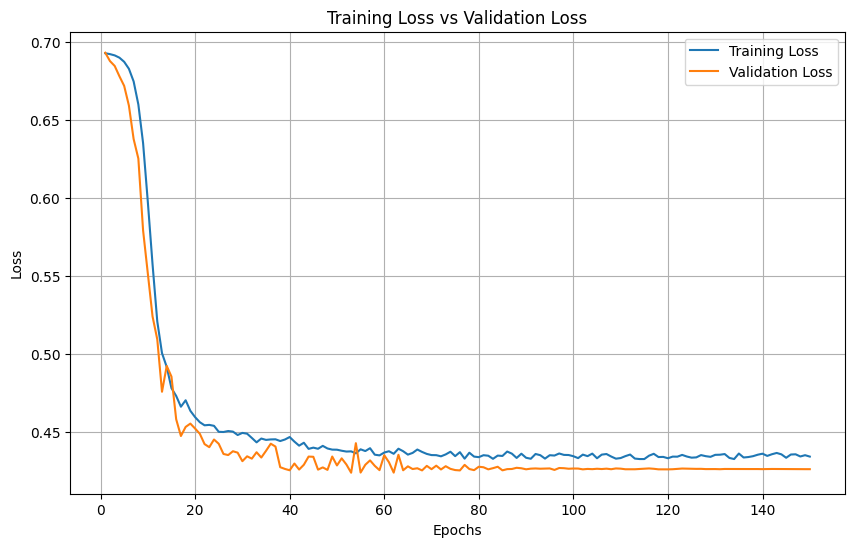

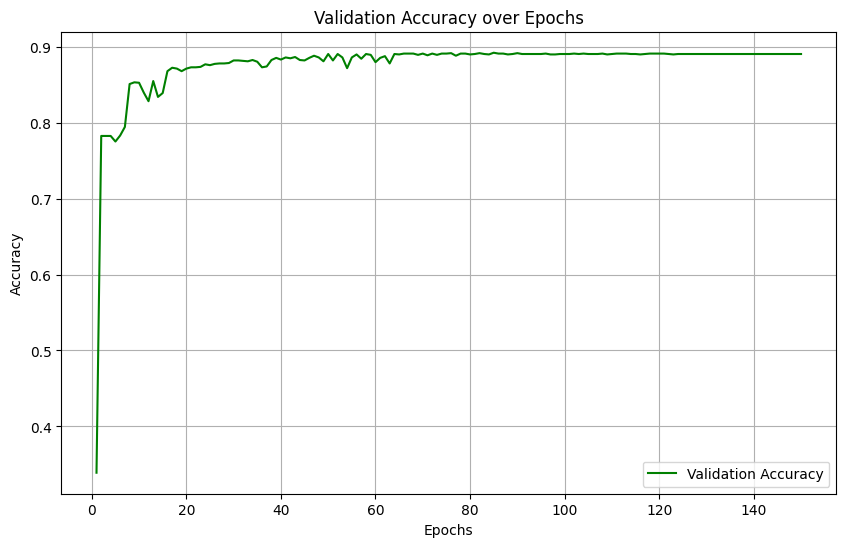

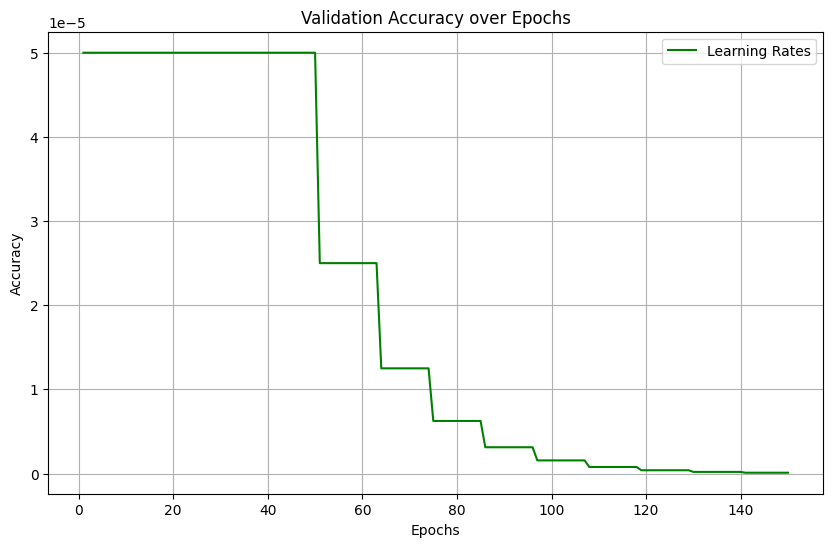

Model for bin 41 saved to 3DCholesterolModels-5A_exp4/model_bin_41.pth
1925 is length of subset grid
Training on bin 42
Bin 42, Epoch 1/150, Train Loss: 0.6934, Validation Loss: 0.7038, Validation Accuracy: 0.2175, Grad Norm: 0.0485, LR: 0.000050
Bin 42, Epoch 11/150, Train Loss: 0.6277, Validation Loss: 0.5532, Validation Accuracy: 0.8554, Grad Norm: 1.8927, LR: 0.000050
Bin 42, Epoch 21/150, Train Loss: 0.4725, Validation Loss: 0.4546, Validation Accuracy: 0.8695, Grad Norm: 3.4609, LR: 0.000050
Bin 42, Epoch 31/150, Train Loss: 0.4591, Validation Loss: 0.4366, Validation Accuracy: 0.8836, Grad Norm: 6.5391, LR: 0.000050
Bin 42, Epoch 41/150, Train Loss: 0.4543, Validation Loss: 0.4326, Validation Accuracy: 0.8836, Grad Norm: 3.2342, LR: 0.000050
Bin 42, Epoch 51/150, Train Loss: 0.4493, Validation Loss: 0.4296, Validation Accuracy: 0.8847, Grad Norm: 1.6300, LR: 0.000025
Bin 42, Epoch 61/150, Train Loss: 0.4481, Validation Loss: 0.4270, Validation Accuracy: 0.8859, Grad Norm: 4.4511

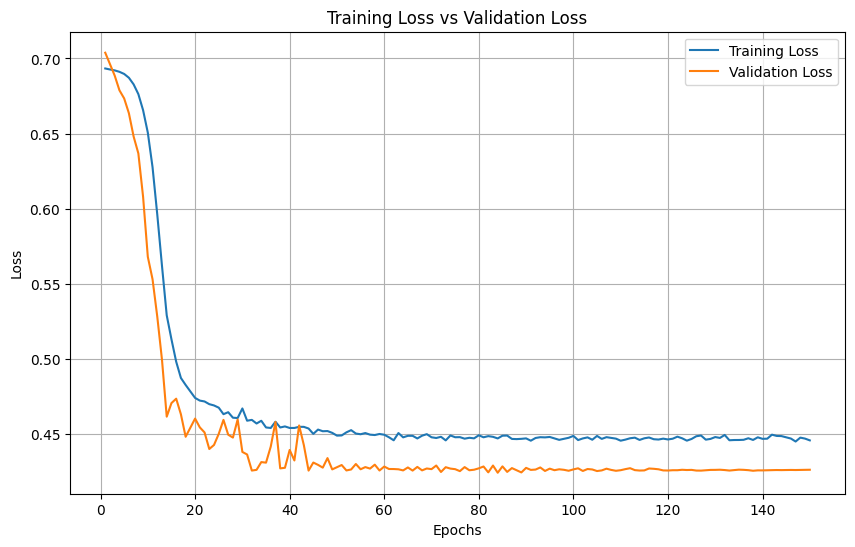

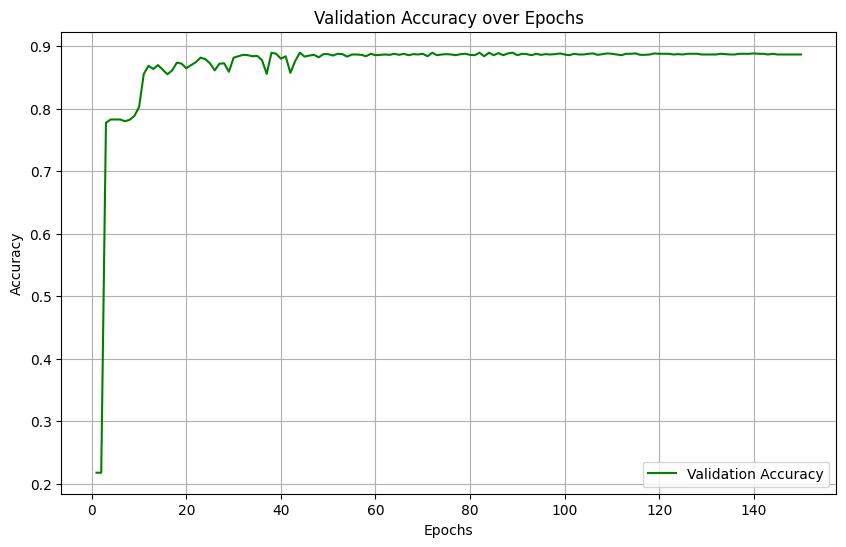

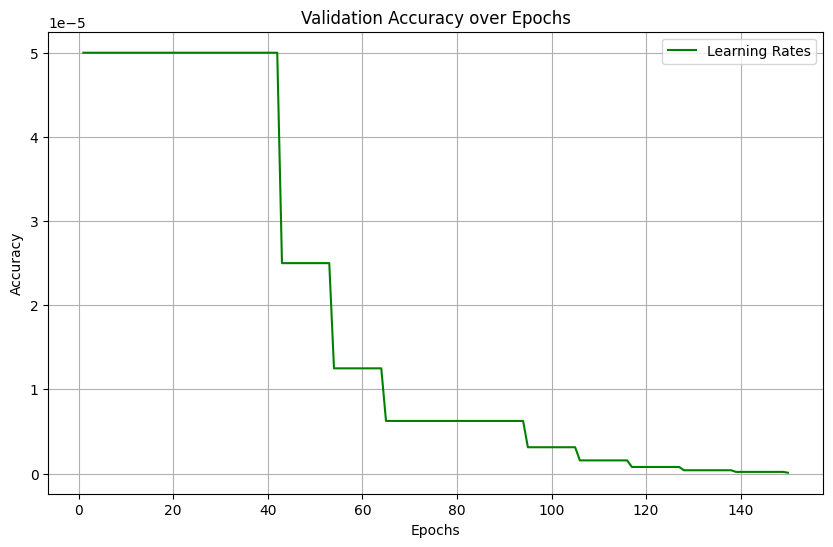

Model for bin 42 saved to 3DCholesterolModels-5A_exp4/model_bin_42.pth
1925 is length of subset grid
Training on bin 43
Bin 43, Epoch 1/150, Train Loss: 0.6932, Validation Loss: 0.7014, Validation Accuracy: 0.2175, Grad Norm: 0.0718, LR: 0.000050
Bin 43, Epoch 11/150, Train Loss: 0.6024, Validation Loss: 0.5151, Validation Accuracy: 0.8633, Grad Norm: 1.2745, LR: 0.000050
Bin 43, Epoch 21/150, Train Loss: 0.4580, Validation Loss: 0.4636, Validation Accuracy: 0.8548, Grad Norm: 3.3426, LR: 0.000050
Bin 43, Epoch 31/150, Train Loss: 0.4498, Validation Loss: 0.4389, Validation Accuracy: 0.8746, Grad Norm: 2.2002, LR: 0.000050
Bin 43, Epoch 41/150, Train Loss: 0.4448, Validation Loss: 0.4274, Validation Accuracy: 0.8831, Grad Norm: 2.9345, LR: 0.000050
Bin 43, Epoch 51/150, Train Loss: 0.4421, Validation Loss: 0.4287, Validation Accuracy: 0.8853, Grad Norm: 0.6823, LR: 0.000050
Bin 43, Epoch 61/150, Train Loss: 0.4389, Validation Loss: 0.4228, Validation Accuracy: 0.8910, Grad Norm: 2.3526

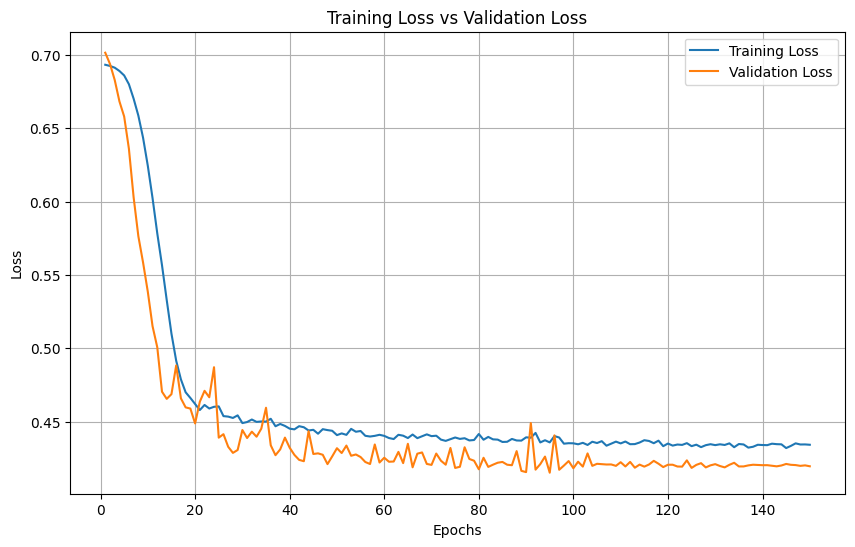

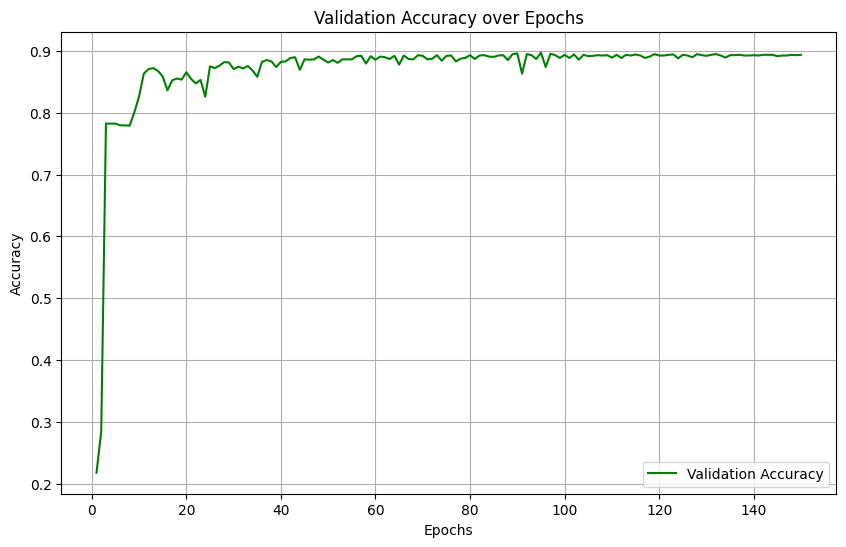

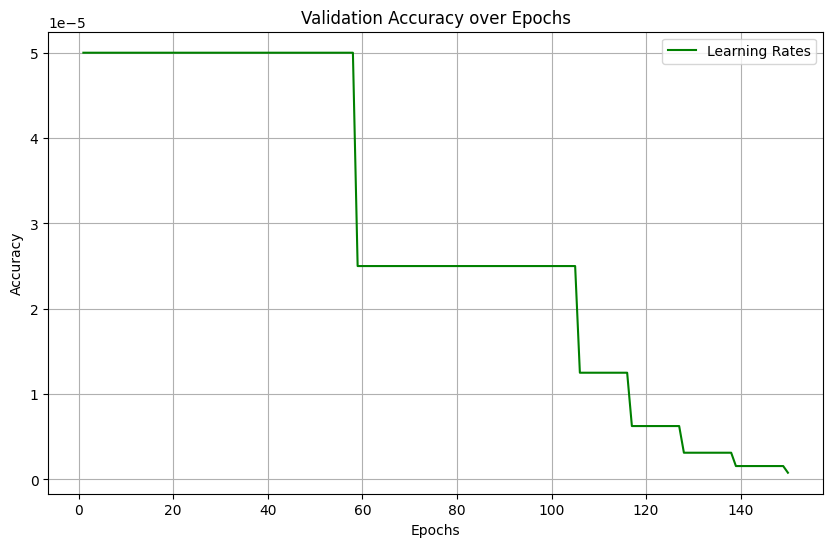

Model for bin 43 saved to 3DCholesterolModels-5A_exp4/model_bin_43.pth
1925 is length of subset grid
Training on bin 44
Bin 44, Epoch 1/150, Train Loss: 0.6930, Validation Loss: 0.6860, Validation Accuracy: 0.7825, Grad Norm: 0.0334, LR: 0.000050
Bin 44, Epoch 11/150, Train Loss: 0.5810, Validation Loss: 0.5738, Validation Accuracy: 0.8113, Grad Norm: 3.3504, LR: 0.000050
Bin 44, Epoch 21/150, Train Loss: 0.4711, Validation Loss: 0.4433, Validation Accuracy: 0.8802, Grad Norm: 3.0296, LR: 0.000050
Bin 44, Epoch 31/150, Train Loss: 0.4566, Validation Loss: 0.4453, Validation Accuracy: 0.8751, Grad Norm: 6.3192, LR: 0.000050
Bin 44, Epoch 41/150, Train Loss: 0.4524, Validation Loss: 0.4252, Validation Accuracy: 0.8864, Grad Norm: 6.1591, LR: 0.000050
Bin 44, Epoch 51/150, Train Loss: 0.4469, Validation Loss: 0.4347, Validation Accuracy: 0.8825, Grad Norm: 3.3429, LR: 0.000050
Bin 44, Epoch 61/150, Train Loss: 0.4485, Validation Loss: 0.4226, Validation Accuracy: 0.8887, Grad Norm: 2.4096

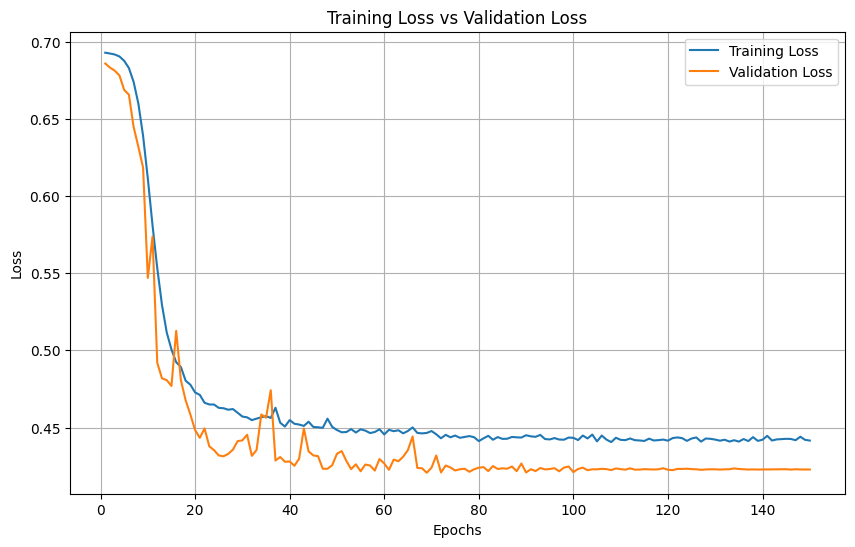

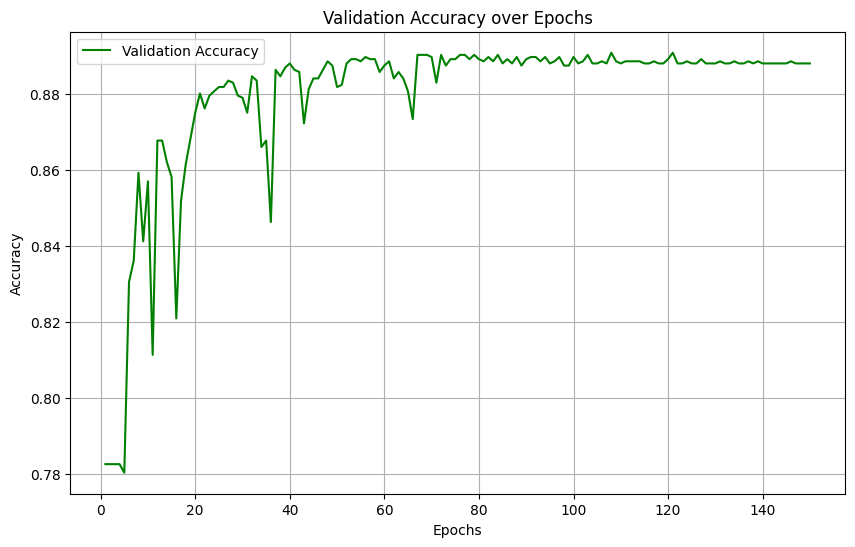

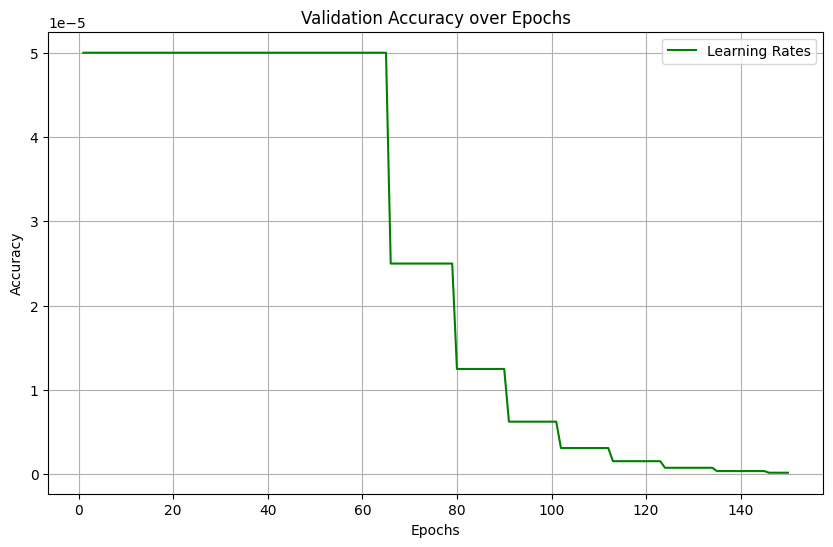

Model for bin 44 saved to 3DCholesterolModels-5A_exp4/model_bin_44.pth
1925 is length of subset grid
Training on bin 45
Bin 45, Epoch 1/150, Train Loss: 0.6933, Validation Loss: 0.6833, Validation Accuracy: 0.7825, Grad Norm: 0.0128, LR: 0.000050
Bin 45, Epoch 11/150, Train Loss: 0.6270, Validation Loss: 0.5535, Validation Accuracy: 0.8254, Grad Norm: 1.2006, LR: 0.000050
Bin 45, Epoch 21/150, Train Loss: 0.4799, Validation Loss: 0.4622, Validation Accuracy: 0.8531, Grad Norm: 4.3007, LR: 0.000050
Bin 45, Epoch 31/150, Train Loss: 0.4648, Validation Loss: 0.4580, Validation Accuracy: 0.8599, Grad Norm: 2.5203, LR: 0.000050
Bin 45, Epoch 41/150, Train Loss: 0.4594, Validation Loss: 0.4392, Validation Accuracy: 0.8723, Grad Norm: 0.7368, LR: 0.000050
Bin 45, Epoch 51/150, Train Loss: 0.4520, Validation Loss: 0.4328, Validation Accuracy: 0.8814, Grad Norm: 0.4637, LR: 0.000050
Bin 45, Epoch 61/150, Train Loss: 0.4460, Validation Loss: 0.4350, Validation Accuracy: 0.8831, Grad Norm: 6.2825

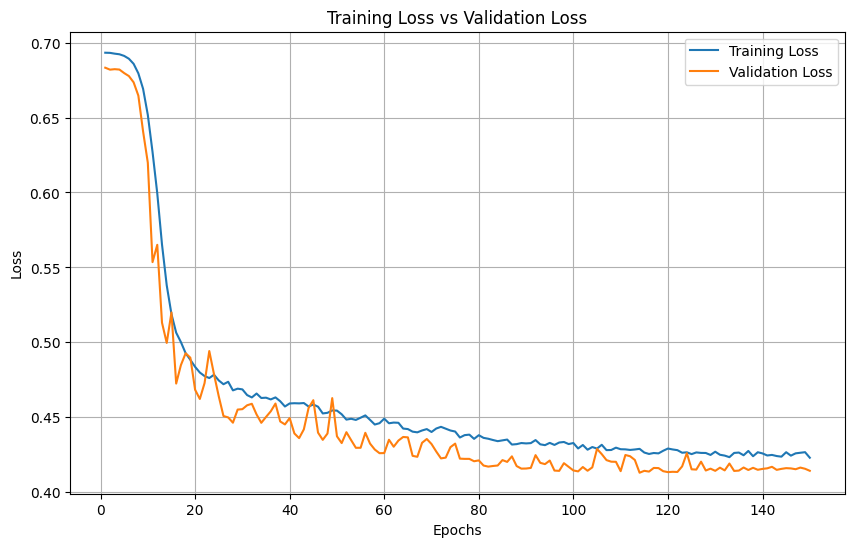

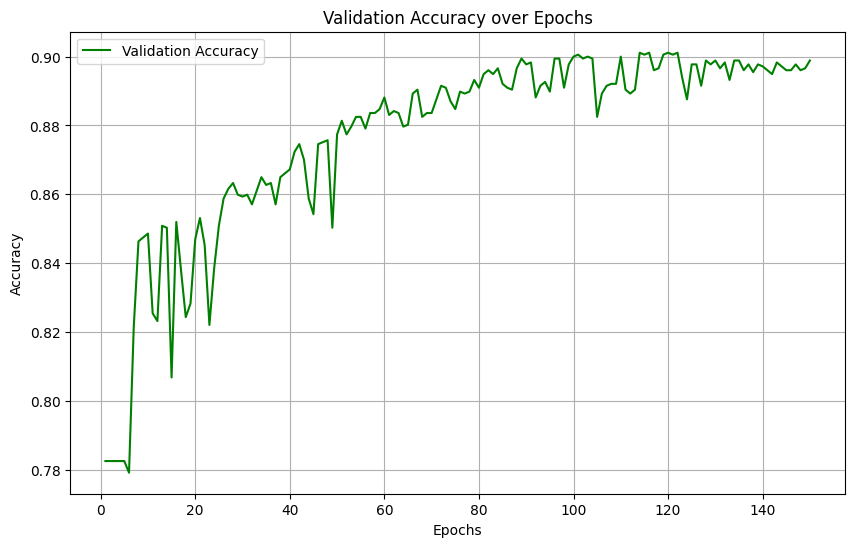

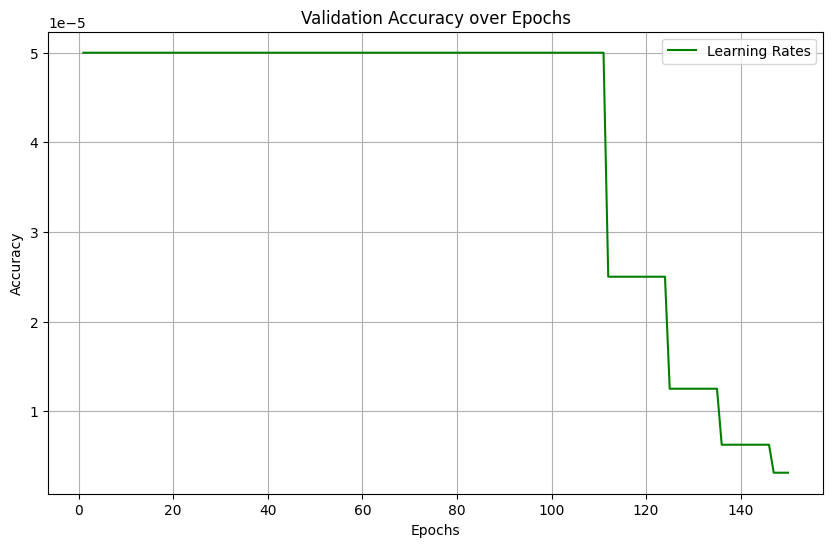

Model for bin 45 saved to 3DCholesterolModels-5A_exp4/model_bin_45.pth
1925 is length of subset grid
Training on bin 46
Bin 46, Epoch 1/150, Train Loss: 0.6931, Validation Loss: 0.6866, Validation Accuracy: 0.7825, Grad Norm: 0.0255, LR: 0.000050
Bin 46, Epoch 11/150, Train Loss: 0.5877, Validation Loss: 0.5178, Validation Accuracy: 0.8531, Grad Norm: 1.3886, LR: 0.000050
Bin 46, Epoch 21/150, Train Loss: 0.4714, Validation Loss: 0.4458, Validation Accuracy: 0.8661, Grad Norm: 0.5525, LR: 0.000050
Bin 46, Epoch 31/150, Train Loss: 0.4629, Validation Loss: 0.4614, Validation Accuracy: 0.8537, Grad Norm: 2.9019, LR: 0.000050
Bin 46, Epoch 41/150, Train Loss: 0.4555, Validation Loss: 0.4311, Validation Accuracy: 0.8802, Grad Norm: 3.8777, LR: 0.000050
Bin 46, Epoch 51/150, Train Loss: 0.4482, Validation Loss: 0.4367, Validation Accuracy: 0.8757, Grad Norm: 3.4234, LR: 0.000050
Bin 46, Epoch 61/150, Train Loss: 0.4456, Validation Loss: 0.4315, Validation Accuracy: 0.8808, Grad Norm: 4.0143

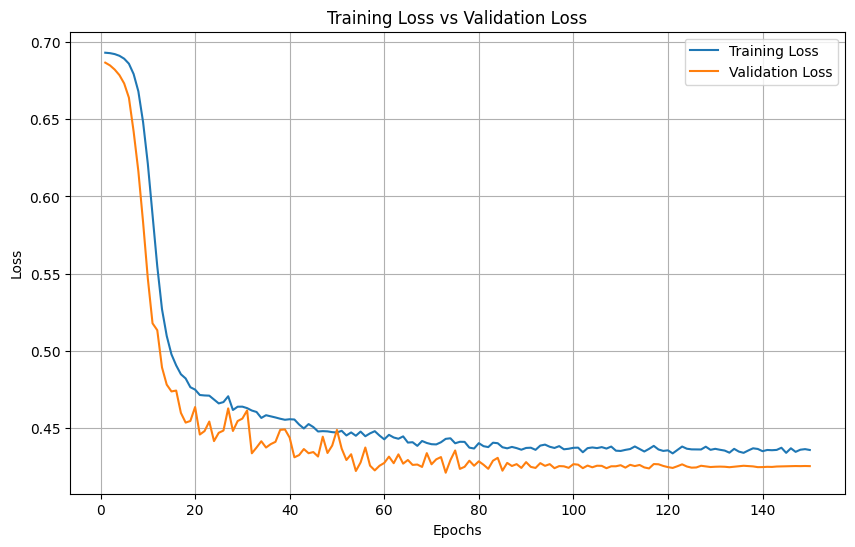

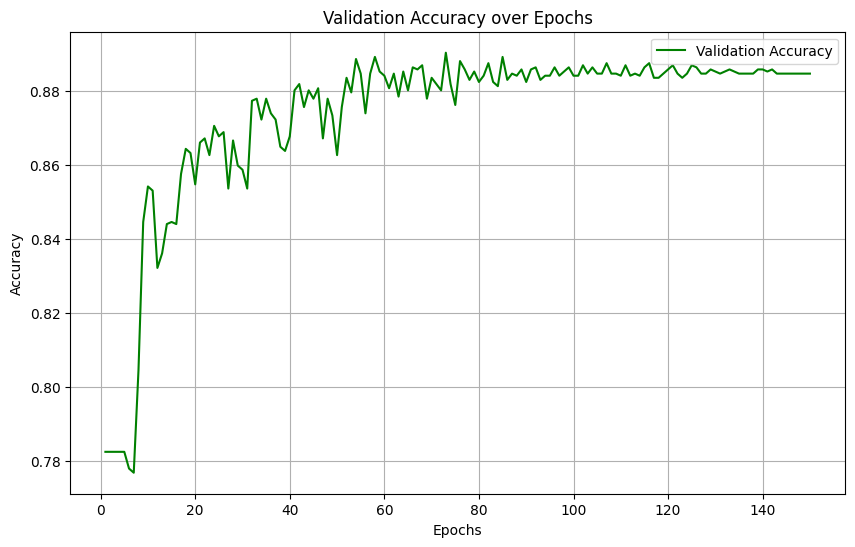

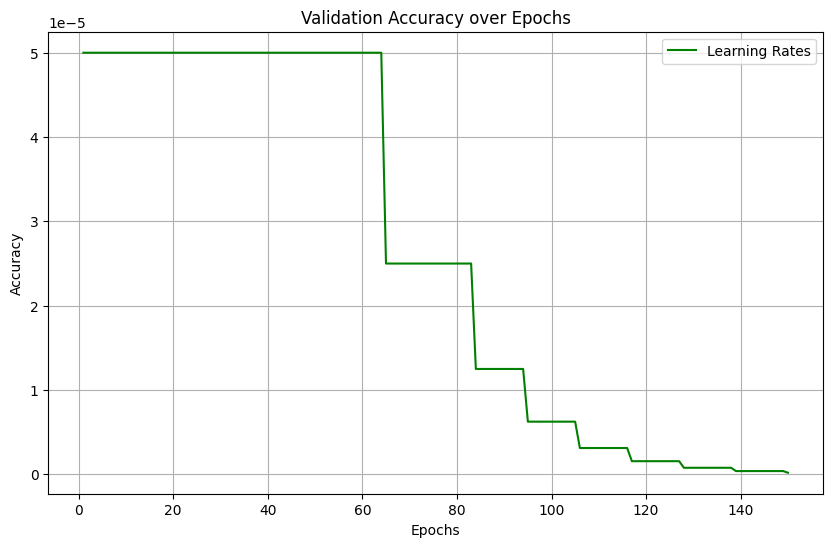

Model for bin 46 saved to 3DCholesterolModels-5A_exp4/model_bin_46.pth
1925 is length of subset grid
Training on bin 47
Bin 47, Epoch 1/150, Train Loss: 0.6930, Validation Loss: 0.6948, Validation Accuracy: 0.2175, Grad Norm: 0.0700, LR: 0.000050
Bin 47, Epoch 11/150, Train Loss: 0.6207, Validation Loss: 0.5620, Validation Accuracy: 0.8576, Grad Norm: 1.2212, LR: 0.000050
Bin 47, Epoch 21/150, Train Loss: 0.4633, Validation Loss: 0.4386, Validation Accuracy: 0.8774, Grad Norm: 6.1888, LR: 0.000050
Bin 47, Epoch 31/150, Train Loss: 0.4487, Validation Loss: 0.4327, Validation Accuracy: 0.8831, Grad Norm: 0.5355, LR: 0.000050
Bin 47, Epoch 41/150, Train Loss: 0.4441, Validation Loss: 0.4344, Validation Accuracy: 0.8842, Grad Norm: 1.9851, LR: 0.000050
Bin 47, Epoch 51/150, Train Loss: 0.4425, Validation Loss: 0.4235, Validation Accuracy: 0.8915, Grad Norm: 2.3638, LR: 0.000050
Bin 47, Epoch 61/150, Train Loss: 0.4368, Validation Loss: 0.4320, Validation Accuracy: 0.8870, Grad Norm: 2.1419

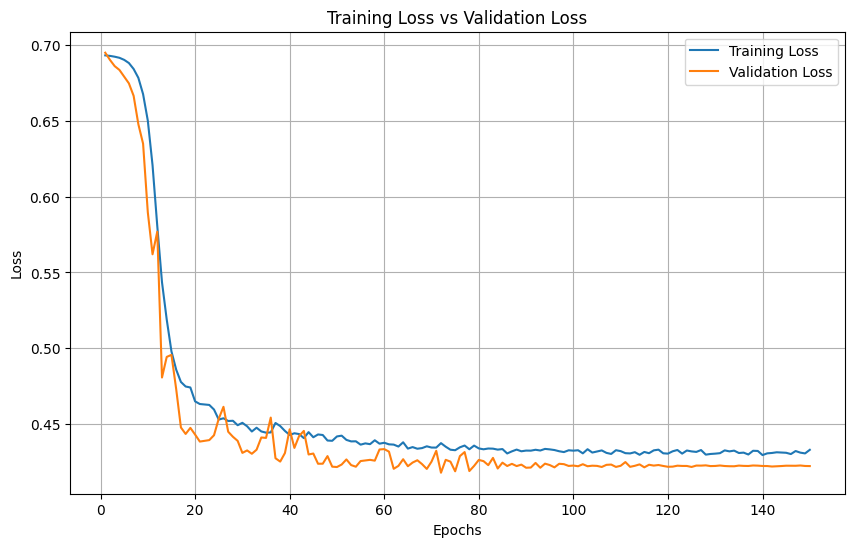

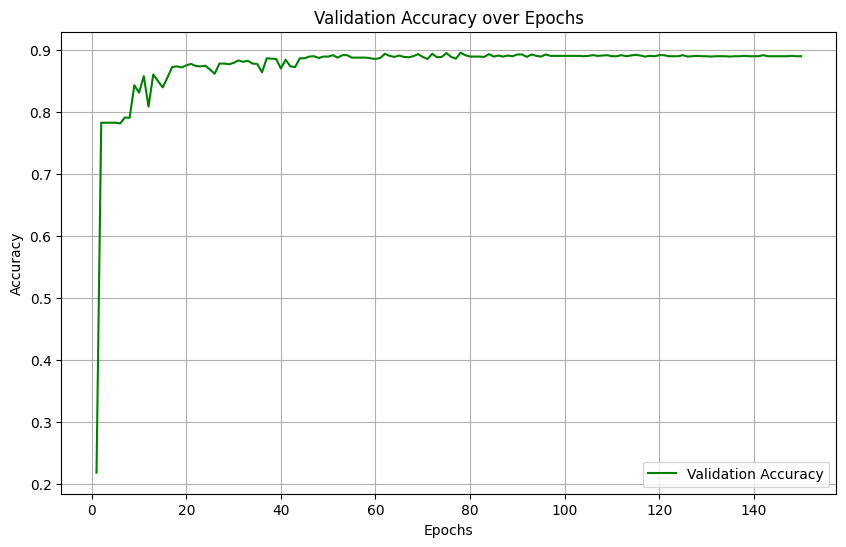

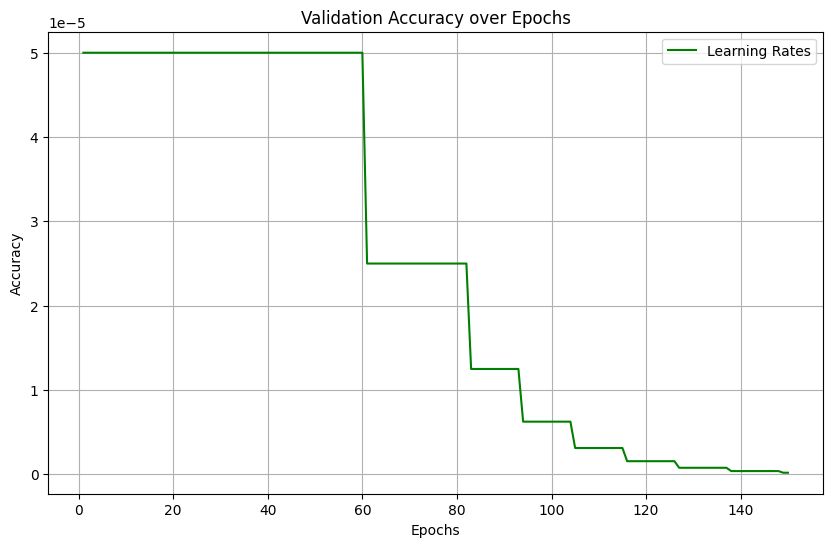

Model for bin 47 saved to 3DCholesterolModels-5A_exp4/model_bin_47.pth
1925 is length of subset grid
Training on bin 48
Bin 48, Epoch 1/150, Train Loss: 0.6931, Validation Loss: 0.6962, Validation Accuracy: 0.2175, Grad Norm: 0.0727, LR: 0.000050
Bin 48, Epoch 11/150, Train Loss: 0.6419, Validation Loss: 0.5615, Validation Accuracy: 0.8209, Grad Norm: 1.9960, LR: 0.000050
Bin 48, Epoch 21/150, Train Loss: 0.4661, Validation Loss: 0.4525, Validation Accuracy: 0.8729, Grad Norm: 3.7121, LR: 0.000050
Bin 48, Epoch 31/150, Train Loss: 0.4543, Validation Loss: 0.4464, Validation Accuracy: 0.8746, Grad Norm: 5.5425, LR: 0.000050
Bin 48, Epoch 41/150, Train Loss: 0.4461, Validation Loss: 0.4413, Validation Accuracy: 0.8785, Grad Norm: 2.2335, LR: 0.000050
Bin 48, Epoch 51/150, Train Loss: 0.4418, Validation Loss: 0.4307, Validation Accuracy: 0.8887, Grad Norm: 1.5208, LR: 0.000050
Bin 48, Epoch 61/150, Train Loss: 0.4358, Validation Loss: 0.4166, Validation Accuracy: 0.8966, Grad Norm: 2.2006

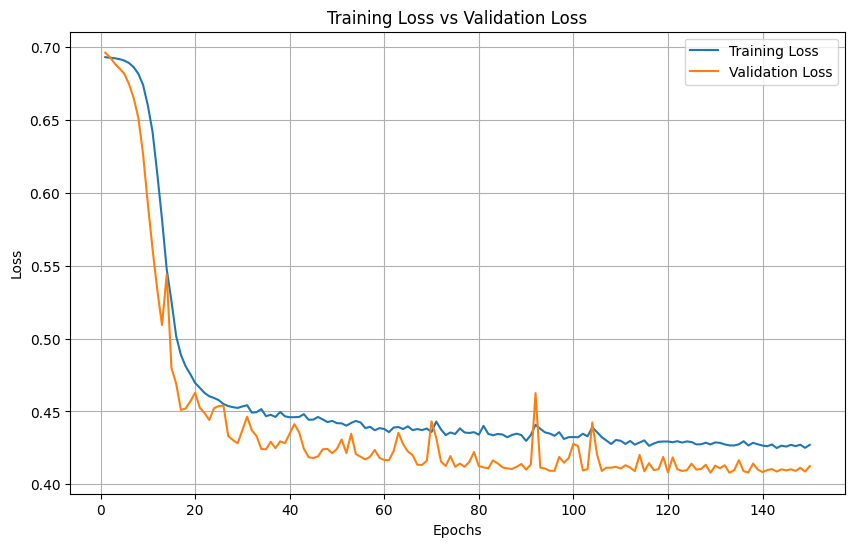

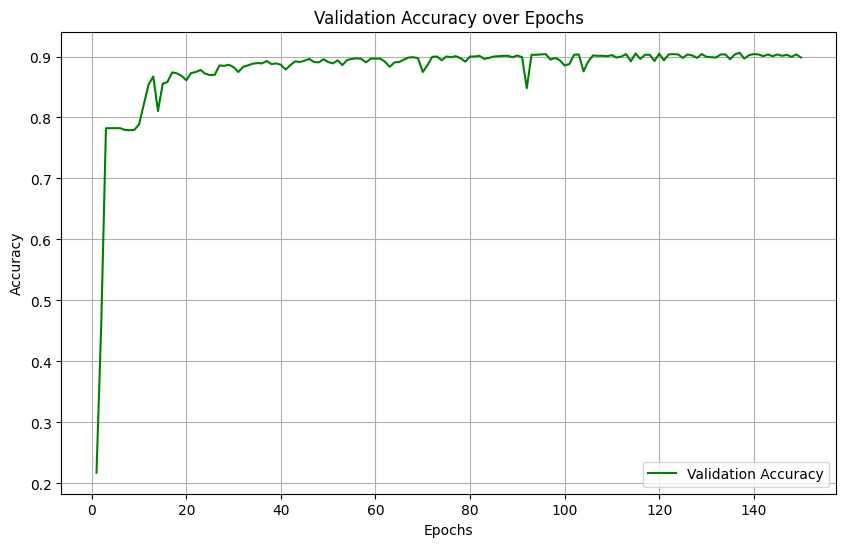

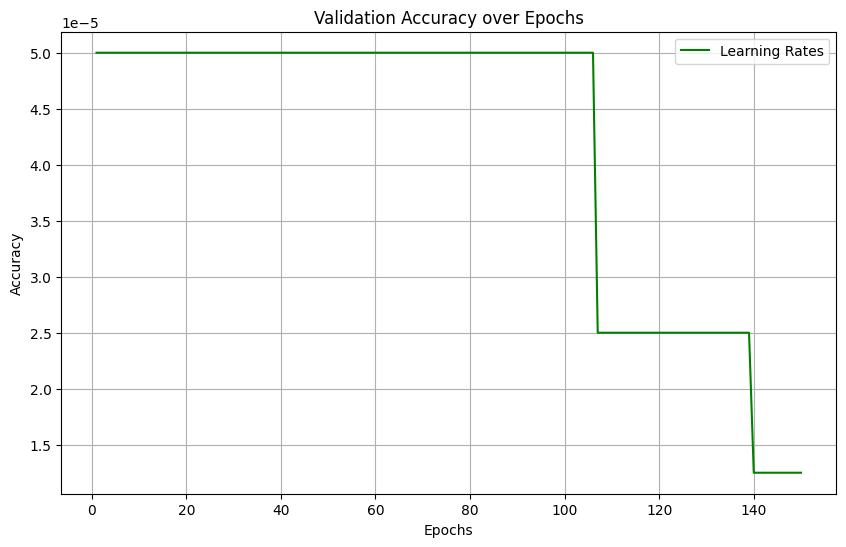

Model for bin 48 saved to 3DCholesterolModels-5A_exp4/model_bin_48.pth
1925 is length of subset grid
Training on bin 49
Bin 49, Epoch 1/150, Train Loss: 0.6933, Validation Loss: 0.6791, Validation Accuracy: 0.7825, Grad Norm: 0.0215, LR: 0.000050
Bin 49, Epoch 11/150, Train Loss: 0.5507, Validation Loss: 0.5453, Validation Accuracy: 0.8028, Grad Norm: 2.7723, LR: 0.000050
Bin 49, Epoch 21/150, Train Loss: 0.4695, Validation Loss: 0.4458, Validation Accuracy: 0.8746, Grad Norm: 1.9801, LR: 0.000050
Bin 49, Epoch 31/150, Train Loss: 0.4587, Validation Loss: 0.4402, Validation Accuracy: 0.8785, Grad Norm: 0.3320, LR: 0.000050
Bin 49, Epoch 41/150, Train Loss: 0.4511, Validation Loss: 0.4282, Validation Accuracy: 0.8853, Grad Norm: 2.4886, LR: 0.000050
Bin 49, Epoch 51/150, Train Loss: 0.4471, Validation Loss: 0.4253, Validation Accuracy: 0.8881, Grad Norm: 3.5600, LR: 0.000025
Bin 49, Epoch 61/150, Train Loss: 0.4457, Validation Loss: 0.4287, Validation Accuracy: 0.8870, Grad Norm: 3.3392

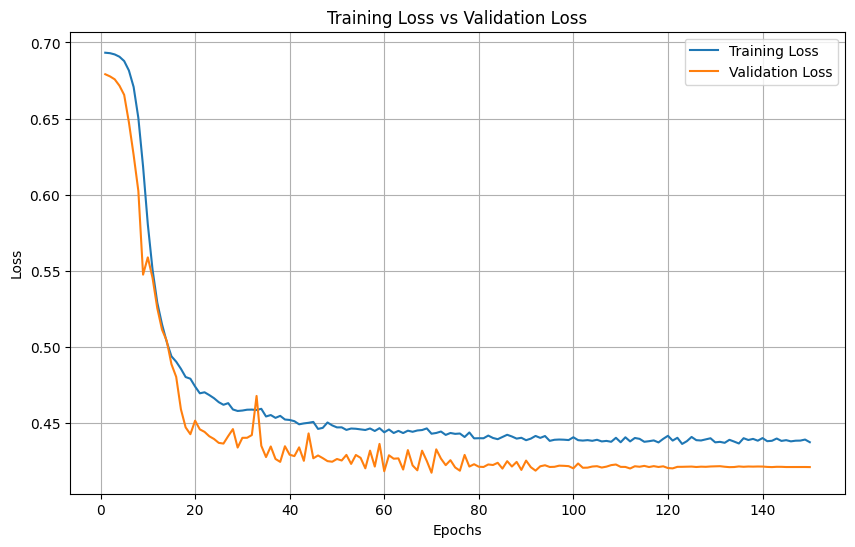

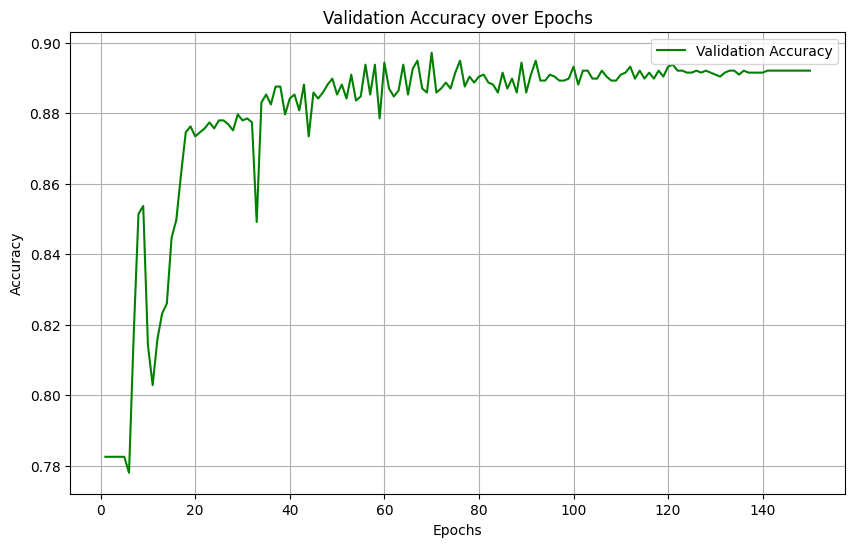

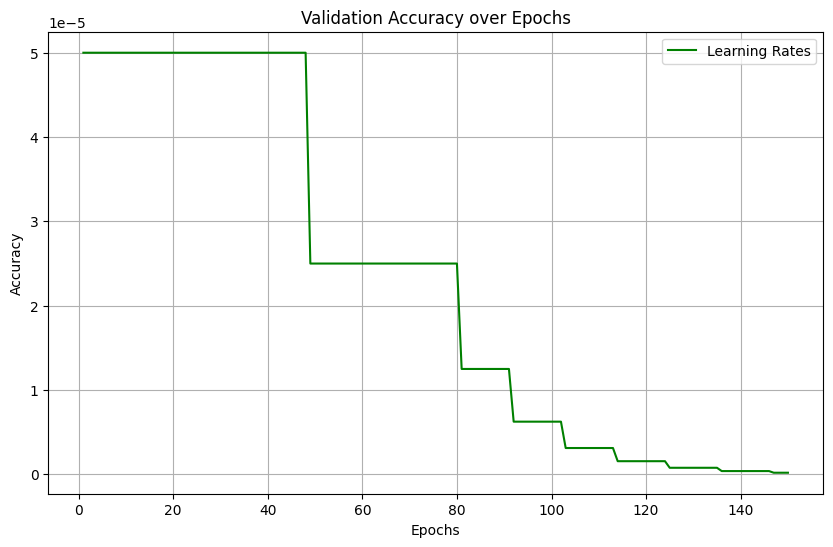

Model for bin 49 saved to 3DCholesterolModels-5A_exp4/model_bin_49.pth
1925 is length of subset grid
Training on bin 50
Bin 50, Epoch 1/150, Train Loss: 0.6933, Validation Loss: 0.7056, Validation Accuracy: 0.2175, Grad Norm: 0.0355, LR: 0.000050
Bin 50, Epoch 11/150, Train Loss: 0.6438, Validation Loss: 0.5711, Validation Accuracy: 0.8079, Grad Norm: 1.3091, LR: 0.000050
Bin 50, Epoch 21/150, Train Loss: 0.4677, Validation Loss: 0.4510, Validation Accuracy: 0.8706, Grad Norm: 1.4690, LR: 0.000050
Bin 50, Epoch 31/150, Train Loss: 0.4523, Validation Loss: 0.4453, Validation Accuracy: 0.8729, Grad Norm: 3.6800, LR: 0.000050
Bin 50, Epoch 41/150, Train Loss: 0.4430, Validation Loss: 0.4320, Validation Accuracy: 0.8802, Grad Norm: 4.8391, LR: 0.000050
Bin 50, Epoch 51/150, Train Loss: 0.4433, Validation Loss: 0.4242, Validation Accuracy: 0.8881, Grad Norm: 4.5716, LR: 0.000050
Bin 50, Epoch 61/150, Train Loss: 0.4391, Validation Loss: 0.4185, Validation Accuracy: 0.8904, Grad Norm: 1.2498

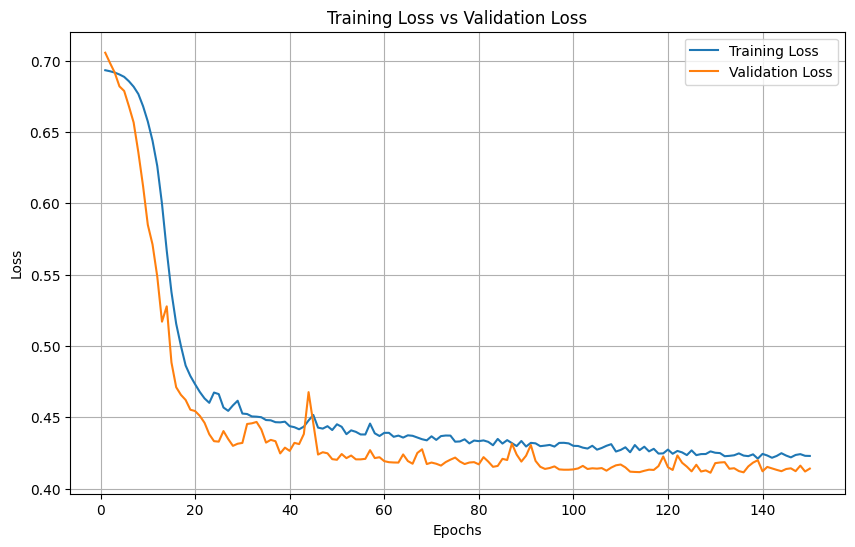

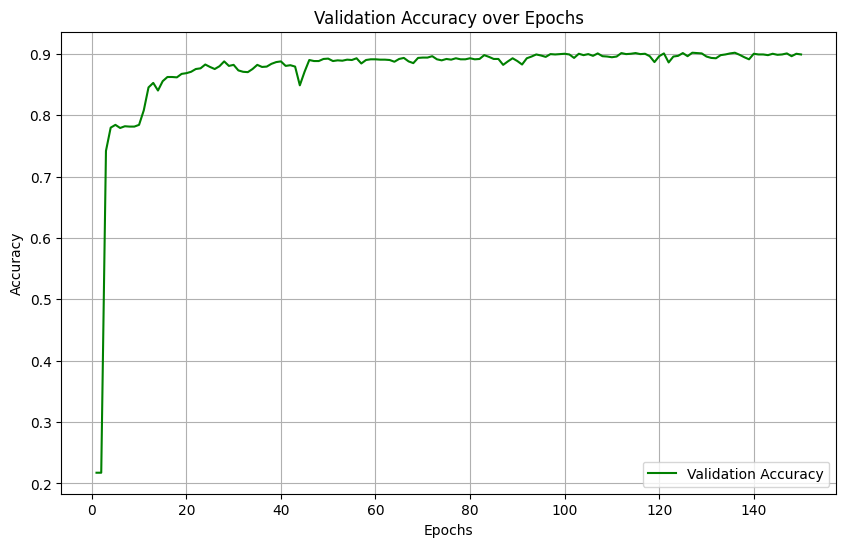

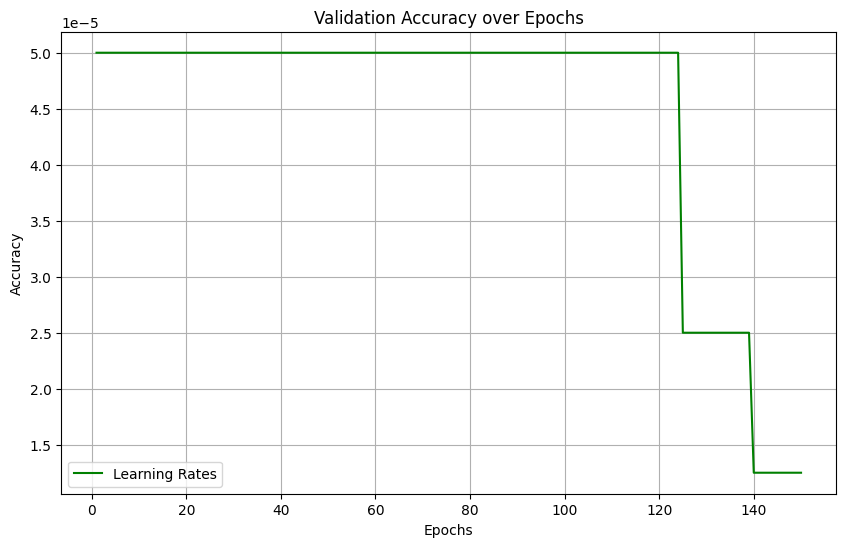

Model for bin 50 saved to 3DCholesterolModels-5A_exp4/model_bin_50.pth
Training complete.


In [6]:
import os

# Training loop
epochs = 150
batch_size = 512

validation_dataset = GridDataset(validation_grids)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

for i in range(0, 50):
    k = i + 1
    file_data = {}
    subset_grid = glob.glob(f'../../../Data/SplitData/Cholesterol/cholesterol-grid-5A_exp4/k_subsets/subset_{k}/*.npy')  # Adjust path as needed
    for file in subset_grid:
        # Load the numpy array and convert it to a PyTorch tensor
        grid = np.load(file)
        grid_tensor = torch.tensor(grid, dtype=torch.float32).permute(3, 0, 1, 2)  # Fix input format
        file_data[file] = {'label': 0, 'grid_tensor': grid_tensor} # 0 means unlabeled
    subset_grid = file_data
    print(len(subset_grid), "is length of subset grid")
    
    bin = {**positive_grids, **subset_grid} # merged
    
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # specify to run on 3 gpu, run on scrum, convert to .py 
    
    # Initialize the model
    criterion = nn.CrossEntropyLoss()
    
    # Define paths for saving models
    save_dir = "3DCholesterolModels-5A_exp4"
    os.makedirs(save_dir, exist_ok=True)
    
    model = CNN3D().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.00005, weight_decay=1e-4) # maybe try momentum 0.9
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, threshold=1e-4)
    #scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.90)  # Reduce LR every 10 epochs
    #scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.90)
    #scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5000, eta_min=1e-6)
    
    print(f"Training on bin {k}")
    dataset = GridDataset(bin)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    train_losses = []
    validation_losses = []
    validation_accuracies = []
    learning_rates = []
    
    for epoch in range(epochs):
        epoch_loss, grad_norm = train_model(model, dataloader, criterion, optimizer, device)
        validation_loss, validation_accuracy = validate_model(model, validation_dataloader, criterion, device)
        scheduler.step(validation_loss)
        current_lr = optimizer.param_groups[0]['lr'] 
        train_losses.append(epoch_loss)
        validation_losses.append(validation_loss)
        validation_accuracies.append(validation_accuracy)
        learning_rates.append(current_lr)
    
        if epoch % 10 == 0:
            print(
                f"Bin {k}, Epoch {epoch+1}/{epochs}, "
                f"Train Loss: {epoch_loss:.4f}, Validation Loss: {validation_loss:.4f}, "
                f"Validation Accuracy: {validation_accuracy:.4f}, Grad Norm: {grad_norm:.4f}, "
                f"LR: {current_lr:.6f}"
            )
            
    plot_graphs(train_losses, validation_losses, validation_accuracies, learning_rates)
    
    #Save the trained model
    model_path = os.path.join(save_dir, f"model_bin_{k}.pth")
    torch.save(model.state_dict(), model_path)
    print(f"Model for bin {k} saved to {model_path}")

print("Training complete.")

# 